In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nltk -q

In [3]:
!pip install -U sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00


# Combine All Document

In [7]:
import os
import pandas as pd

base_dir = '/content/drive/MyDrive/BDC SEMIFINAL/01 Datasets/04 txt raw files'

data = []

def extract_text(file_path):
  with open(file_path, 'r') as file:
    file_contents = file.read()
    isi_pasal_index = file_contents.find('Isi Pasal:')
    if isi_pasal_index != -1:
      extracted_text = file_contents[isi_pasal_index + len('Isi Pasal:'):]
      return extracted_text.strip()
  return None

for root, dirs, files in os.walk(base_dir):
  for file in files:
    if file.endswith('.txt'):
      file_path = os.path.join(root, file)
      extracted_text = extract_text(file_path)
      if extracted_text:
        # Extracting the subfolder name as 'Tingkatan'
        tingkatan = os.path.basename(root)
        # Removing '.txt' from the file name
        file_name = os.path.splitext(file)[0]
        data.append((tingkatan, file_name, extracted_text))

df = pd.DataFrame(data, columns=['Tingkatan', 'FileName', 'ExtractedText'])

In [8]:
df

Tingkatan                                           FileName  \
0    Peraturan Pemerintah  PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
1    Peraturan Pemerintah              Peraturan_Pemerintah_No.63_Tahun_2019   
2    Peraturan Pemerintah               Peraturan_Pemerintah_No.1_Tahun_2008   
3    Peraturan Pemerintah               Peraturan_Pemerintah_No.8_Tahun_2007   
4    Peraturan Pemerintah              Peraturan_Pemerintah_No.24_Tahun_2019   
..                    ...                                                ...   
103              UU_Perpu                     Undang-Undang_No.33_Tahun_2004   
104              UU_Perpu                      Undang-Undang_No.9_Tahun_2018   
105              UU_Perpu                     Undang-Undang_No.40_Tahun_2014   
106              UU_Perpu                           Perpu Nomor 1 Tahun 2020   
107              UU_Perpu                     Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  
0    Menetapkan\n"Peraturan Pemerintah Pengganti Un...  
1    :\n\nPERATURAN PEMERINTAH TENTANG INVESTASI\nP...  
2    :\n\nMenetapkan:\n\nPERATURAN PEMERINTAH TENTA...  
3    :\nMenetapkan:\nPERATURAN PEMERINTAH TENTANG I...  
4    : ...\n
Menetapkan\n\nSK No 005037 A\n\na\n\nB...  
..                                                 ...  
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...  
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...  
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...  
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...  
107  :\n\nMenetapkan : Undang-undang tentang CKeten...  

[108 rows x 3 columns]

## Import Library

In [9]:
import pandas as pd
import nltk
nltk.data.path.append("/root/nltk_data/tokenizers")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
nltk.download('punkt', download_dir="/root/nltk_data", quiet=True, raise_on_error=True)
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
!pip install Sastrawi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import networkx as nx
import textwrap

## Build the Function

In [13]:
def split_sentences(text):
  # Split the text into sentences based on '\n\n' pattern
  sentences = re.split(r'\n\n', text)

  # Clean up the sentences by removing leading/trailing whitespaces
  sentences = [sentence.lower().strip() for sentence in sentences]

  return sentences

def remove_punctuation(sentences):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
  cleaned_sentences = []
  for sentence in sentences:
    cleaned_sentence = sentence.translate(translator)
    cleaned_sentences.append(cleaned_sentence)
  return cleaned_sentences

def remove_stopwords(sentences_list):
  # Download Indonesian stopwords list from NLTK
  stop_words = set(stopwords.words('indonesian'))

  # Tokenize each sentence and remove stopwords
  cleaned_sentences = []
  for sentence in sentences_list:
    words = word_tokenize(sentence)
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    cleaned_sentences.append(' '.join(filtered_sentence))

  return cleaned_sentences

def remove_pasal_sentences(text_list):
  # Define the regular expression pattern to match 'pasal' followed by a space and digits
  pattern = r'pasal\s\d+'
  # Filter out sentences that match the regular expression
  filtered_list = [sentence for sentence in text_list if not re.search(pattern, sentence)]
  return filtered_list

def remove_empty_text(sentences_list):
  non_empty_sentences = [[sentence for sentence in sentences if sentence.strip() != ""] for sentences in sentences_list]
  non_empty_sentences = [sentences for sentences in non_empty_sentences if sentences]  # Remove empty lists
  return non_empty_sentences

def remove_numbering(sentences_list):
  # Define the regular expression pattern to match numbering patterns
  pattern = r'\b[A-Za-z1-9]\.'
  # Remove the numbering pattern from each sentence in the list
  filtered_list = [re.sub(pattern, '', sentence) for sentence in sentences_list]
  return filtered_list

def remove_numbering_in_parentheses(sentences_list):
  # Define the regular expression pattern to match the numbering in parentheses at the start of the sentence
  pattern = r'\(\d+\)'

  # Remove the numbering pattern from each sentence in the list
  filtered_list = [re.sub(pattern, '', sentence) for sentence in sentences_list]

  return filtered_list

def remove_danatau(sentences):
  # Remove 'danatau' from the text
  cleaned_sentences = [sentence.replace('danatau', '') for sentence in sentences]
  return cleaned_sentences

def replace_newlines_with_spaces(sentences_list):
  # Replace '\n' with a space in each sentence
  cleaned_list = [sentence.replace('\n', ' ') for sentence in sentences_list]
  return cleaned_list

def delete_link(sentence_list):
  filtered_sentences = [sentence for sentence in sentence_list if 'www' not in sentence and 'bphn' not in sentence]
  return filtered_sentences

def filter_sentences(sentences_list):
  # Remove sentences that only have 1 word or include 'bab' or 'presiden'
  filtered_sentences = [sentence for sentence in sentences_list if len(sentence.split()) > 2 and 'bab' not in sentence and 'presiden' not in sentence]
  return filtered_sentences

def stem_text(sentences_list):
  # Create a StemmerFactory and get the default Indonesian stemmer
  stemmer = StemmerFactory().create_stemmer()
  # Stem each sentence in the list
  stemmed_sentences = [stemmer.stem(sentence) for sentence in sentences_list]
  return stemmed_sentences

## Preprocess

In [14]:
df['cleaned_text'] = df['ExtractedText'].apply(split_sentences)
df['cleaned_text'][0]

['menetapkan\n"peraturan pemerintah pengganti undang-undang tentang penggunaan\ndan pengawasan atas penggunaan dana-dana investasi".',
 'pasal 1.',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan\nmenteri yang bersangkutan tersedia untuk diperbungakan\nkarena tidak/belum segera diperlukan untuk memenuhi maksud\npemupukannya, termasuk dana-dana cadangan pada perusahaan-\nperusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan\nfungsi utamanya harus secara teratur memperbungakan dana-\ndana investasinya dalam obyek-obyek pembungaan berjangka\natau perusahaan/badan yang memupuk dana-dana cadangan untuk\nkeperluan perluasan atau untuk menutup kerangka yang mungkin\ndiderita atau perusahaan/ badan lain semacam itu yang\nditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan,\npembiayaan da

In [15]:
df['cleaned_text'] = df['cleaned_text'].apply(replace_newlines_with_spaces)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'pasal 1.',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan 

In [16]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_pasal_sentences)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'a.dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'b.perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'c.menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang men

In [17]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbering)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang mengenai 

In [18]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbering_in_parentheses)
df['cleaned_text'][0]

['menetapkan "peraturan pemerintah pengganti undang-undang tentang penggunaan dan pengawasan atas penggunaan dana-dana investasi".',
 'dalam peraturan pemerintah pengganti undang-undang ini yang',
 'dimaksudkan dengan',
 'dana investasi, ialah : dana-dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak/belum segera diperlukan untuk memenuhi maksud pemupukannya, termasuk dana-dana cadangan pada perusahaan- perusahaan/badan-badan pada umumnya;',
 'perusahaan/badan, ialah perusahaan/badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana- dana investasinya dalam obyek-obyek pembungaan berjangka atau perusahaan/badan yang memupuk dana-dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan/ badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan.',
 'menteri yang bersangkutan, ialah: menteri urusan pendapatan, pembiayaan dan pengawasan sepanjang mengenai 

In [19]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [20]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_danatau)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [21]:
df['cleaned_text'] = df['cleaned_text'].apply(delete_link)
df['cleaned_text'][0]

['menetapkan  peraturan pemerintah pengganti undang undang tentang penggunaan dan pengawasan atas penggunaan dana dana investasi  ',
 'dalam peraturan pemerintah pengganti undang undang ini yang',
 'dimaksudkan dengan',
 'dana investasi  ialah   dana dana yang menurut ketetapan menteri yang bersangkutan tersedia untuk diperbungakan karena tidak belum segera diperlukan untuk memenuhi maksud pemupukannya  termasuk dana dana cadangan pada perusahaan  perusahaan badan badan pada umumnya ',
 'perusahaan badan  ialah perusahaan badan yang dalam menjalankan fungsi utamanya harus secara teratur memperbungakan dana  dana investasinya dalam obyek obyek pembungaan berjangka atau perusahaan badan yang memupuk dana dana cadangan untuk keperluan perluasan atau untuk menutup kerangka yang mungkin diderita atau perusahaan  badan lain semacam itu yang ditetapkan oleh menteri yang bersangkutan ',
 'menteri yang bersangkutan  ialah  menteri urusan pendapatan  pembiayaan dan pengawasan sepanjang mengenai 

In [22]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
df['cleaned_text'][0]

['menetapkan peraturan pemerintah pengganti undang undang penggunaan pengawasan penggunaan dana dana investasi',
 'peraturan pemerintah pengganti undang undang',
 '',
 'dana investasi dana dana ketetapan menteri bersangkutan tersedia diperbungakan memenuhi maksud pemupukannya dana dana cadangan perusahaan perusahaan badan badan',
 'perusahaan badan perusahaan badan menjalankan fungsi utamanya teratur memperbungakan dana dana investasinya obyek obyek pembungaan berjangka perusahaan badan memupuk dana dana cadangan keperluan perluasan menutup kerangka diderita perusahaan badan ditetapkan menteri bersangkutan',
 'menteri bersangkutan menteri urusan pendapatan pembiayaan pengawasan pengaturan dana investasi perusahaan perusahaan asuransi menteri urusan bank sentral pengaturan',
 'dana investasi perusahaan perusahaan badan',
 'badan',
 'menteri bersangkutan berwenang mengambil tindakan mengeluarkan peraturan peraturan pengawasan penggunaan dana dana investasi',
 'peraturan ditetapkan menter

In [23]:
df['cleaned_text'] = df['cleaned_text'].apply(filter_sentences)
df['cleaned_text'][0]

['menetapkan peraturan pemerintah pengganti undang undang penggunaan pengawasan penggunaan dana dana investasi',
 'peraturan pemerintah pengganti undang undang',
 'dana investasi dana dana ketetapan menteri bersangkutan tersedia diperbungakan memenuhi maksud pemupukannya dana dana cadangan perusahaan perusahaan badan badan',
 'perusahaan badan perusahaan badan menjalankan fungsi utamanya teratur memperbungakan dana dana investasinya obyek obyek pembungaan berjangka perusahaan badan memupuk dana dana cadangan keperluan perluasan menutup kerangka diderita perusahaan badan ditetapkan menteri bersangkutan',
 'menteri bersangkutan menteri urusan pendapatan pembiayaan pengawasan pengaturan dana investasi perusahaan perusahaan asuransi menteri urusan bank sentral pengaturan',
 'dana investasi perusahaan perusahaan badan',
 'menteri bersangkutan berwenang mengambil tindakan mengeluarkan peraturan peraturan pengawasan penggunaan dana dana investasi',
 'peraturan ditetapkan menteri bersangkutan 

In [24]:
df['cleaned_text'] = df['cleaned_text'].apply(stem_text)
df['cleaned_text'][0]

['tetap atur perintah ganti undang undang guna awas guna dana dana investasi',
 'atur perintah ganti undang undang',
 'dana investasi dana dana tetap menteri sangkut sedia bunga penuh maksud pupu dana dana cadang usaha usaha badan badan',
 'usaha badan usaha badan jalan fungsi utama atur bunga dana dana investasi obyek obyek bunga jangka usaha badan pupuk dana dana cadang perlu luas tutup kerangka derita usaha badan tetap menteri sangkut',
 'menteri sangkut menteri urus dapat biaya awas atur dana investasi usaha usaha asuransi menteri urus bank sentral atur',
 'dana investasi usaha usaha badan',
 'menteri sangkut wenang ambil tindak keluar atur atur awas guna dana dana investasi',
 'atur tetap menteri sangkut usaha badan usaha indonesia wajib dana investasi',
 'deposito bank indonesia',
 'kertas bendahara negara',
 'obyek obyek bunga tetap menteri',
 'menteri urus dapat biaya awas menteri urus bank sentral tetap atur keluar guna kertas bendahara negara simpang tentu tentu undang undang

In [25]:
def combine_sentences(sentences_list):
  # Combine the list of sentences into one text
  combined_text = ' '.join(sentences_list)

  return combined_text

In [26]:
df['final_text'] = df['cleaned_text'].apply(combine_sentences)
df['final_text'][0]

'tetap atur perintah ganti undang undang guna awas guna dana dana investasi atur perintah ganti undang undang dana investasi dana dana tetap menteri sangkut sedia bunga penuh maksud pupu dana dana cadang usaha usaha badan badan usaha badan usaha badan jalan fungsi utama atur bunga dana dana investasi obyek obyek bunga jangka usaha badan pupuk dana dana cadang perlu luas tutup kerangka derita usaha badan tetap menteri sangkut menteri sangkut menteri urus dapat biaya awas atur dana investasi usaha usaha asuransi menteri urus bank sentral atur dana investasi usaha usaha badan menteri sangkut wenang ambil tindak keluar atur atur awas guna dana dana investasi atur tetap menteri sangkut usaha badan usaha indonesia wajib dana investasi deposito bank indonesia kertas bendahara negara obyek obyek bunga tetap menteri menteri urus dapat biaya awas menteri urus bank sentral tetap atur keluar guna kertas bendahara negara simpang tentu tentu undang undang urus usaha badan usaha indonesia wajib teran

In [ ]:
def tfidf(text, max_feat = 1000):
  # Create the TfidfVectorizer with bigram and trigram
  vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range = (2,3), max_features = max_feat)
  tfidf_matrix = vectorizer.fit_transform(text)
  feature_names = vectorizer.get_feature_names_out()
  return tfidf_matrix, feature_names

# Antar Tingkat

## UU_Perpu vs PP

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah" or Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, asuransi janji ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi asuransi janji us...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(51, 1000)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 miliar' '00 puluh' '00 ratus' '00 triliun' '000 00' '000 00 miliar'
 '000 00 puluh' '000 00 ratus' '000 00 triliun' '000 000' '000 000 00'
 '000 000 000' '10 puluh' '10 puluh kerja' '10 puluh persen' '100 000'
 '12 belas' '15 belas' '15 belas persen' '20 puluh' '20 puluh persen'
 '30 puluh' '31 desember' '50 puluh' '50 puluh persen' '500 000'
 'ada barang' 'ada barang jasa' 'administratif ayat' 'agen asuransi'
 'agun aset' 'ajar formal' 'ajar formal nonformal' 'aksud ayat'
 'akuntan publik' 'akuntansi uang' 'alih aset' 'alokasi anggar'
 'alokasi anggar perintah' 'alokasi dana' 'ampun pajak' 'ana dim'
 'ana dim aksud' 'ana dm' 'ana dm aksud' 'anggar 2015' 'anggar 2021'
 'anggar belanja' 'anggar dapat' 'anggar dapat belanja' 'anggar dasar'
 'anggar didik' 'anggar menteri' 'anggar perintah' 'anggar tahun'
 'anggota bursa' 'anggota bursa efek' 'anggota dewan' 'anggota dewan awas'
 'anggota dewan komisioner' 'anggota direksi' 'antara dagang'
 'antara dagang efek' 'apbn a

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 miliar  00 puluh  \
FileName                                                                  
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...   0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                0.000000  0.000000   
Peraturan_Pemerintah_No.1_Tahun_2008                 0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                 0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...   0.000000  0.000000   
2021pp049                                            0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996                0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011               0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992                0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013                0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                 0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992                0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995               0.025254  0.006055   
Peraturan_Pemerintah_No.25_Tahun_2020                0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983                0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982                0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018                0.000000  0.000000   
PP_55_2015                                           0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017                0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984                0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013                0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992                0.000000  0.000000   
2022pp031                                            0.000000  0.000000   
PP Nomor 93 Tahun 2021                               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016                0.000000  0.000000   
PP_27_1985                                           0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993                0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993                0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000               0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000                0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995                        0.017080  0.000000   
Undang-Undang_No.11_Tahun_2016                       0.007183  0.013778   
Undang-Undang_No.1_Tahun_2004                        0.021992  0.008436   
Undang-Undang_No.4_Tahun_2016                        0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008                       0.000000  0.009328   
Salinan UU Nomor 9 Tahun 2020                        0.007932  0.057047   
Undang-Undang_No._24_Tahun_2011                      0.000000  0.000000   
UU411999                                             0.006718  0.000000   
UU Nomor 4 Tahun 2009                                0.000000  0.003616   
Undang-Undang_No.27_Tahun_2014                       0.000000  0.055119   
UU_34_1964                                           0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006                       0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004                       0.014092  0.000000   
Undang-Undang_No.33_Tahun_2004                       0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018                        0.000000  0.003588   
Undang-Undang_No.40_Tahun_2014                       0.000000  0.000000   
Perpu Nomor 1 Tahun 2020                             0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962                       0.000000  0.000000   

                                                    00 ratus  00 triliun  \


### Calculate the similarity

In [ ]:
# Import cosine_similarity measure
from sklearn.metrics.pairwise import cosine_similarity

# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Pemerintah'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'UU_Perpu'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PP_file_names]
filtered_df

FileName                                            Undang-Undang_No.8_Tahun_1995  \
FileName                                                                            
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                       0.031000   
Peraturan_Pemerintah_No.63_Tahun_2019                                    0.055079   
Peraturan_Pemerintah_No.1_Tahun_2008                                     0.014324   
Peraturan_Pemerintah_No.8_Tahun_2007                                     0.018750   
Peraturan_Pemerintah_No.24_Tahun_2019                                    0.014285   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                       0.038626   
2021pp049                                                                0.062411   
Peraturan_Pemerintah_No.28_Tahun_1996                                    0.041346   
Peraturan_Pemerintah_No._49_Tahun_2011                                   0.014804   
Peraturan_Pemerintah_No.75_Tahun_1992                                    0.023729   
Peraturan_Pemerintah_No.99_Tahun_2013                                    0.048995   
Peraturan_Pemerintah_No.5_Tahun_2018                                     0.009804   
Peraturan_Pemerintah_No.77_Tahun_1992                                    0.017507   
Peraturan_Pemerintah_No._45_Tahun_1995                                   0.656915   
Peraturan_Pemerintah_No.25_Tahun_2020                                    0.063099   
Peraturan_Pemerintah_No.48_Tahun_2008                                    0.009962   
Peraturan_Pemerintah_No.18_Tahun_1983                                    0.049305   
Peraturan_Pemerintah_No.30_Tahun_1982                                    0.057058   
Peraturan_Pemerintah_No.53_Tahun_2018                                    0.032924   
PP_55_2015                                                               0.087097   
Peraturan_Pemerintah_No.49_Tahun_2017                                    0.006590   
Peraturan_Pemerintah_No.28_Tahun_1984                                    0.020354   
Peraturan_Pemerintah_No.107_Tahun_2015                                   0.031361   
Peraturan_Pemerintah_No.33_Tahun_2013                                    0.002380   
Peraturan_Pemerintah_No.73_Tahun_1992                                    0.030383   
2022pp031                                                                0.314254   
PP Nomor 93 Tahun 2021                                                   0.030684   
Peraturan_Pemerintah_No.73_Tahun_2016                                    0.008694   
PP_27_1985                                                               0.040989   
Peraturan_Pemerintah_No.54_Tahun_1993                                    0.014531   
Peraturan_Pemerintah_No.33_Tahun_1993                                    0.021972   
Peraturan_Pemerintah_No.105_Tahun_2000                                   0.019748   
Peraturan_Pemerintah_No.40_Tahun_2000                                    0.013242   

FileName                                            Undang-Undang_No.11_Tahun_2016  \
FileName                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                        0.020258   
Peraturan_Pemerintah_No.63_Tahun_2019                                     0.024396   
Peraturan_Pemerintah_No.1_Tahun_2008                                      0.011541   
Peraturan_Pemerintah_No.8_Tahun_2007                                      0.011612   
Peraturan_Pemerintah_No.24_Tahun_2019                                     0.012344   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                        0.017155   
2021pp049                                                                 0.224567   
Peraturan_Pemerintah_No.28_Tahun_1996                                     0.022028   
Peraturan_Pemerintah_No._49_Tahun_2011                                    0.011124   
Peraturan_Pemerintah_No.75_Tahun_1992                                     0.02

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

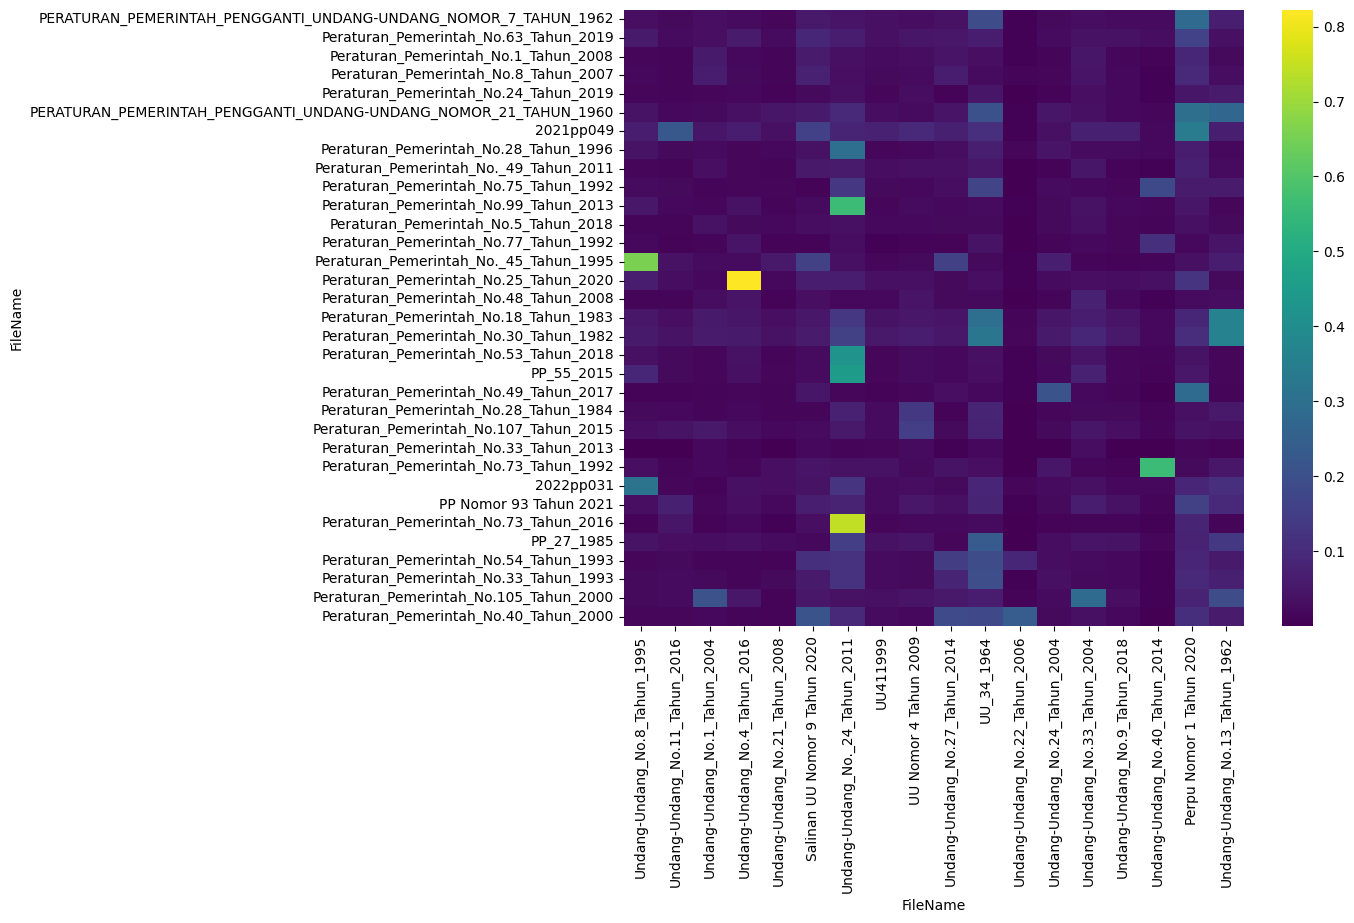

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
    if score < 0.2:
        return 'Tidak Selaras'
    elif score < 0.4:
        return 'Netral'
    else:
        return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Undang-Undang_No.8_Tahun_1995  \
FileName                                                                           
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                 Tidak Selaras   
Peraturan_Pemerintah_No.63_Tahun_2019                              Tidak Selaras   
Peraturan_Pemerintah_No.1_Tahun_2008                               Tidak Selaras   
Peraturan_Pemerintah_No.8_Tahun_2007                               Tidak Selaras   
Peraturan_Pemerintah_No.24_Tahun_2019                              Tidak Selaras   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                 Tidak Selaras   
2021pp049                                                          Tidak Selaras   
Peraturan_Pemerintah_No.28_Tahun_1996                              Tidak Selaras   
Peraturan_Pemerintah_No._49_Tahun_2011                             Tidak Selaras   
Peraturan_Pemerintah_No.75_Tahun_1992                              Tidak Selaras   
Peraturan_Pemerintah_No.99_Tahun_2013                              Tidak Selaras   
Peraturan_Pemerintah_No.5_Tahun_2018                               Tidak Selaras   
Peraturan_Pemerintah_No.77_Tahun_1992                              Tidak Selaras   
Peraturan_Pemerintah_No._45_Tahun_1995                                   Selaras   
Peraturan_Pemerintah_No.25_Tahun_2020                              Tidak Selaras   
Peraturan_Pemerintah_No.48_Tahun_2008                              Tidak Selaras   
Peraturan_Pemerintah_No.18_Tahun_1983                              Tidak Selaras   
Peraturan_Pemerintah_No.30_Tahun_1982                              Tidak Selaras   
Peraturan_Pemerintah_No.53_Tahun_2018                              Tidak Selaras   
PP_55_2015                                                         Tidak Selaras   
Peraturan_Pemerintah_No.49_Tahun_2017                              Tidak Selaras   
Peraturan_Pemerintah_No.28_Tahun_1984                              Tidak Selaras   
Peraturan_Pemerintah_No.107_Tahun_2015                             Tidak Selaras   
Peraturan_Pemerintah_No.33_Tahun_2013                              Tidak Selaras   
Peraturan_Pemerintah_No.73_Tahun_1992                              Tidak Selaras   
2022pp031                                                                 Netral   
PP Nomor 93 Tahun 2021                                             Tidak Selaras   
Peraturan_Pemerintah_No.73_Tahun_2016                              Tidak Selaras   
PP_27_1985                                                         Tidak Selaras   
Peraturan_Pemerintah_No.54_Tahun_1993                              Tidak Selaras   
Peraturan_Pemerintah_No.33_Tahun_1993                              Tidak Selaras   
Peraturan_Pemerintah_No.105_Tahun_2000                             Tidak Selaras   
Peraturan_Pemerintah_No.40_Tahun_2000                              Tidak Selaras   

FileName                                           Undang-Undang_No.11_Tahun_2016  \
FileName                                                                            
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                  Tidak Selaras   
Peraturan_Pemerintah_No.63_Tahun_2019                               Tidak Selaras   
Peraturan_Pemerintah_No.1_Tahun_2008                                Tidak Selaras   
Peraturan_Pemerintah_No.8_Tahun_2007                                Tidak Selaras   
Peraturan_Pemerintah_No.24_Tahun_2019                               Tidak Selaras   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                  Tidak Selaras   
2021pp049                                                                  Netral   
Peraturan_Pemerintah_No.28_Tahun_1996                               Tidak Selaras   
Peraturan_Pemerintah_No._49_Tahun_2011                              Tidak Selaras   
Peraturan_Pemerintah_No.75_Tahun_1992                               Tidak Selaras   
Peraturan_Pemerintah_No.99_Tahun_2013  

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil dari UU_Perpu dan Peraturan Pemerintah
pd.DataFrame(counts['Total'])

Total
Netral          19.0
Selaras          7.0
Tidak Selaras  568.0

### Peraturan UU_Perpu dan Peraturan Pemerintah yang Selaras

In [ ]:
import numpy as np

row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                     Perundangan2
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016
3   Peraturan_Pemerintah_No.53_Tahun_2018  Undang-Undang_No._24_Tahun_2011
4                              PP_55_2015  Undang-Undang_No._24_Tahun_2011
5   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014
6   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                     Perundangan2  \
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011   
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995   
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016   
3   Peraturan_Pemerintah_No.53_Tahun_2018  Undang-Undang_No._24_Tahun_2011   
4                              PP_55_2015  Undang-Undang_No._24_Tahun_2011   
5   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014   
6   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011   

                                              Topic1  \
0                         tetap atur perintah kelola   
1  tetap atur perintah selenggara giat bidang pas...   
2       atur perintah selenggara tabung rumah rakyat   
3  atur perintah ubah atur perintah nomor 87 2013...   
4  atur perintah ubah atur perintah nomor 99 2013...   
5        atur perintah republik indonesia selenggara   
6  atur perintah pajak hasil program jamin sosial...   

                                        Topic2  
0  undang undang badan selenggara jamin sosial  
1              tetap undang undang pasar modal  
2            undang undang tabung rumah rakyat  
3  undang undang badan selenggara jamin sosial  
4  undang undang badan selenggara jamin sosial  
5                 tetap undang undang asuransi  
6  undang undang badan selenggara jamin sosial

In [ ]:
all_selaras = pd.DataFrame()

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1                     Perundangan2  \
0   Peraturan_Pemerintah_No.99_Tahun_2013  Undang-Undang_No._24_Tahun_2011   
1  Peraturan_Pemerintah_No._45_Tahun_1995    Undang-Undang_No.8_Tahun_1995   
2   Peraturan_Pemerintah_No.25_Tahun_2020    Undang-Undang_No.4_Tahun_2016   
3   Peraturan_Pemerintah_No.53_Tahun_2018  Undang-Undang_No._24_Tahun_2011   
4                              PP_55_2015  Undang-Undang_No._24_Tahun_2011   
5   Peraturan_Pemerintah_No.73_Tahun_1992   Undang-Undang_No.40_Tahun_2014   
6   Peraturan_Pemerintah_No.73_Tahun_2016  Undang-Undang_No._24_Tahun_2011   

                                              Topic1  \
0                         tetap atur perintah kelola   
1  tetap atur perintah selenggara giat bidang pas...   
2       atur perintah selenggara tabung rumah rakyat   
3  atur perintah ubah atur perintah nomor 87 2013...   
4  atur perintah ubah atur perintah nomor 99 2013...   
5        atur perintah republik indonesia selenggara   
6  atur perintah pajak hasil program jamin sosial...   

                                        Topic2  
0  undang undang badan selenggara jamin sosial  
1              tetap undang undang pasar modal  
2            undang undang tabung rumah rakyat  
3  undang undang badan selenggara jamin sosial  
4  undang undang badan selenggara jamin sosial  
5                 tetap undang undang asuransi  
6  undang undang badan selenggara jamin sosial

## Peraturan Pemerintah vs Peraturan Presiden

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                             FileName  \
60  Peraturan Presiden  Keputusan_Presiden_No.28_Tahun_2010   
61  Peraturan Presiden                       Inpres_11_2011   
62  Peraturan Presiden               Inpres No 6 Tahun 2014   
63  Peraturan Presiden            Inpres Nomor 2 Tahun 2021   
64  Peraturan Presiden            INPRES Nomor 6 Tahun 2016   

                                        ExtractedText  \
60  :\n\nMenetapkan:\n\nKEPUTUSAN PRESIDEN TENTANG...   
61  PRESIDEN REPUBLIK INDONESIA\nNOMOR 11 TAHUN 20...   
62  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 6 TAHUN 2...   
63  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 2 TAHUN 2...   
64  PRESIDEN REPUBLIK INDONESIA\nNOMOR 6 TAHUN 201...   

                                         cleaned_text  \
60  [20 21 22, menteri koordinator bidang politik ...   
61  [laksana komitmen cetak biru masyarakat ekonom...   
62  [nomor 6 2014, tingkat daya saing nasional ran...   
63  [nomor 2 2021, optimalisasi laksana program ja...   
64  [cepat kembang industri farmasi alat sehat, wu...   

                                           final_text  
60  20 21 22 menteri koordinator bidang politik hu...  
61  laksana komitmen cetak biru masyarakat ekonomi...  
62  nomor 6 2014 tingkat daya saing nasional rangk...  
63  nomor 2 2021 optimalisasi laksana program jami...  
64  cepat kembang industri farmasi alat sehat wuju...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(65, 1000)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '00 ratus juta' '000 00' '000 00 ratus' '000 000' '000 000 00'
 '000 000 000' '10 puluh' '10 puluh kerja' '10 puluh persen' '12 belas'
 '15 belas' '15 belas persen' '20 puluh' '20 puluh persen' '31 desember'
 '50 puluh' '50 puluh persen' '500 000' '500 000 000' 'ada barang'
 'ada barang jasa' 'agun aset' 'ahli bidang' 'ahli bidang ekonomi'
 'ahli bidang hubung' 'ahli bidang hukum' 'ajar formal'
 'ajar formal nonformal' 'aksi mitigasi' 'aktif program'
 'aktif program jamin' 'akuntansi uang' 'alam jasa' 'alat sehat'
 'alih aset' 'alih partisipasi' 'alih partisipasi interes'
 'alokasi anggar' 'alokasi anggar perintah' 'ambil langkah' 'ampun pajak'
 'analisis evaluasi' 'analisis evaluasi lapor' 'anggar dapat'
 'anggar dapat belanja' 'anggar dasar' 'anggar perintah'
 'anggar perintah daerah' 'anggar tahun' 'anggota bursa'
 'anggota bursa efek' 'anggota direksi' 'antara dagang'
 'antara dagang efek' 'aparatur negara' 'aset bersih' 'aset bpjs'
 'aset bpjs ketenagake

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus  00 ratus juta  \
FileName                                                                      
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...       0.0            0.0   
Peraturan_Pemerintah_No.63_Tahun_2019                    0.0            0.0   
Peraturan_Pemerintah_No.1_Tahun_2008                     0.0            0.0   
Peraturan_Pemerintah_No.8_Tahun_2007                     0.0            0.0   
Peraturan_Pemerintah_No.24_Tahun_2019                    0.0            0.0   
...                                                      ...            ...   
Keputusan_Presiden_No.28_Tahun_2010                      0.0            0.0   
Inpres_11_2011                                           0.0            0.0   
Inpres No 6 Tahun 2014                                   0.0            0.0   
Inpres Nomor 2 Tahun 2021                                0.0            0.0   
INPRES Nomor 6 Tahun 2016                                0.0            0.0   

                                                    000 00  000 00 ratus  \
FileName                                                                   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...   0.000           0.0   
Peraturan_Pemerintah_No.63_Tahun_2019                0.012           0.0   
Peraturan_Pemerintah_No.1_Tahun_2008                 0.000           0.0   
Peraturan_Pemerintah_No.8_Tahun_2007                 0.000           0.0   
Peraturan_Pemerintah_No.24_Tahun_2019                0.000           0.0   
...                                                    ...           ...   
Keputusan_Presiden_No.28_Tahun_2010                  0.000           0.0   
Inpres_11_2011                                       0.000           0.0   
Inpres No 6 Tahun 2014                               0.000           0.0   
Inpres Nomor 2 Tahun 2021                            0.000           0.0   
INPRES Nomor 6 Tahun 2016                            0.000           0.0   

                                                     000 000  000 000 00  \
FileName                                                                   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000       0.000   
Peraturan_Pemerintah_No.63_Tahun_2019               0.031506       0.012   
Peraturan_Pemerintah_No.1_Tahun_2008                0.000000       0.000   
Peraturan_Pemerintah_No.8_Tahun_2007                0.000000       0.000   
Peraturan_Pemerintah_No.24_Tahun_2019               0.000000       0.000   
...                                                      ...         ...   
Keputusan_Presiden_No.28_Tahun_2010                 0.000000       0.000   
Inpres_11_2011                                      0.000000       0.000   
Inpres No 6 Tahun 2014                              0.000000       0.000   
Inpres Nomor 2 Tahun 2021                           0.000000       0.000   
INPRES Nomor 6 Tahun 2016                           0.000000       0.000   

                                                    000 000 000  10 puluh  \
FileName                                                                    
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...     0.000000       0.0   
Peraturan_Pemerintah_No.63_Tahun_2019                  0.022313       0.0   
Peraturan_Pemerintah_No.1_Tahun_2008                   0.000000       0.0   
Peraturan_Pemerintah_No.8_Tahun_2007                   0.000000       0.0   
Peraturan_Pemerintah_No.24_Tahun_2019                  0.000000       0.0   
...                                                         ...       ...   
Keputusan_Presiden_No.28_Tahun_2010                    0.000000       0.0   
Inpres_11_2011                                         0.000000       0.0   
Inpres No 6 Tahun 2014                                 0.000000       0.0   
Inpres Nomor 2 Tahun 2021                              0.000000       0.0   
INPRES Nomor 6 Tahun 2016                              0.000000       0.0   

                                            

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Pemerintah'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Presiden'
PPres_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PPres_file_names]
filtered_df

FileName                              PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                
Peraturan_Presiden_No.23_Tahun_2017                                            0.012460                 
PERPRES_49_2011                                                                0.041810                 
Peraturan_Presiden_No._27_Tahun_2009                                           0.007455                 
Perpres Nomor 31 Tahun 2021                                                    0.007038                 
Peraturan_Presiden_No.71_Tahun_2019                                            0.002875                 
Perpres Nomor 98 Tahun 2021                                                    0.003715                 
PERPRES_41_2015                                                                0.015921                 
Salinan Perpres Nomor 71 Tahun 2019                                            0.002873                 
Peraturan_Presiden_No.44_Tahun_2008                                            0.018789                 
Peraturan_Presiden_No.9_Tahun_2011                                             0.013883                 
Peraturan_Presiden_No.46_Tahun_2019                                            0.004557                 
Peraturan_Presiden_No.55_Tahun_2020                                            0.000772                 
Peraturan_Presiden_No.10_Tahun_1964                                            0.000000                 
Perpres Nomor 63 Tahun 2021                                                    0.007438                 
Keputusan_Presiden_No.101_Tahun_1998                                           0.009893                 
Keputusan_Presiden_No.108_Tahun_2001                                           0.004679                 
kp1831998                                                                      0.045970                 
Keppres2951965                                                                 0.111038                 
Keppres0541993                                                                 0.070584                 
Keputusan_Presiden_No.121_Tahun_1999                                           0.074335                 
Keputusan_Presiden_No.176_Tahun_2000                                           0.009866                 
Keputusan_Presiden_No.37_Tahun_1970                                            0.000000                 
Keputusan_Presiden_No.32_Tahun_2016                                            0.005151                 
Keppres Nomor 20 Tahun 2020                                                    0.001301                 
Keputusan_Presiden_No.12_Tahun_2006                                            0.007660                 
Keppres Nomor 11 Tahun 2021                                                    0.002108                 
Keputusan_Presiden_No.117_Tahun_1999                                           0.005029                 
Keputusan_Presiden_No.28_Tahun_2010                                            0.010909                 
Inpres_11_2011                                                                 0.004546                 
Inpres No 6 Tahun 2014                                                         0.003085                 
Inpres Nomor 2 Tahun 2021                                                      0.007238                 
INPRES Nomor 6 Tahun 2016                                                      0.002109                 

FileName                              Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                      
Peraturan_Presiden_No.23_Tahun_2017                                0.033974   
PERPRES_49_2011                                                    0.055039   
Peraturan_Presiden_No._27_Tahun_2009                               0.017522   
Perpres Nomor 31 Tahun 2021       

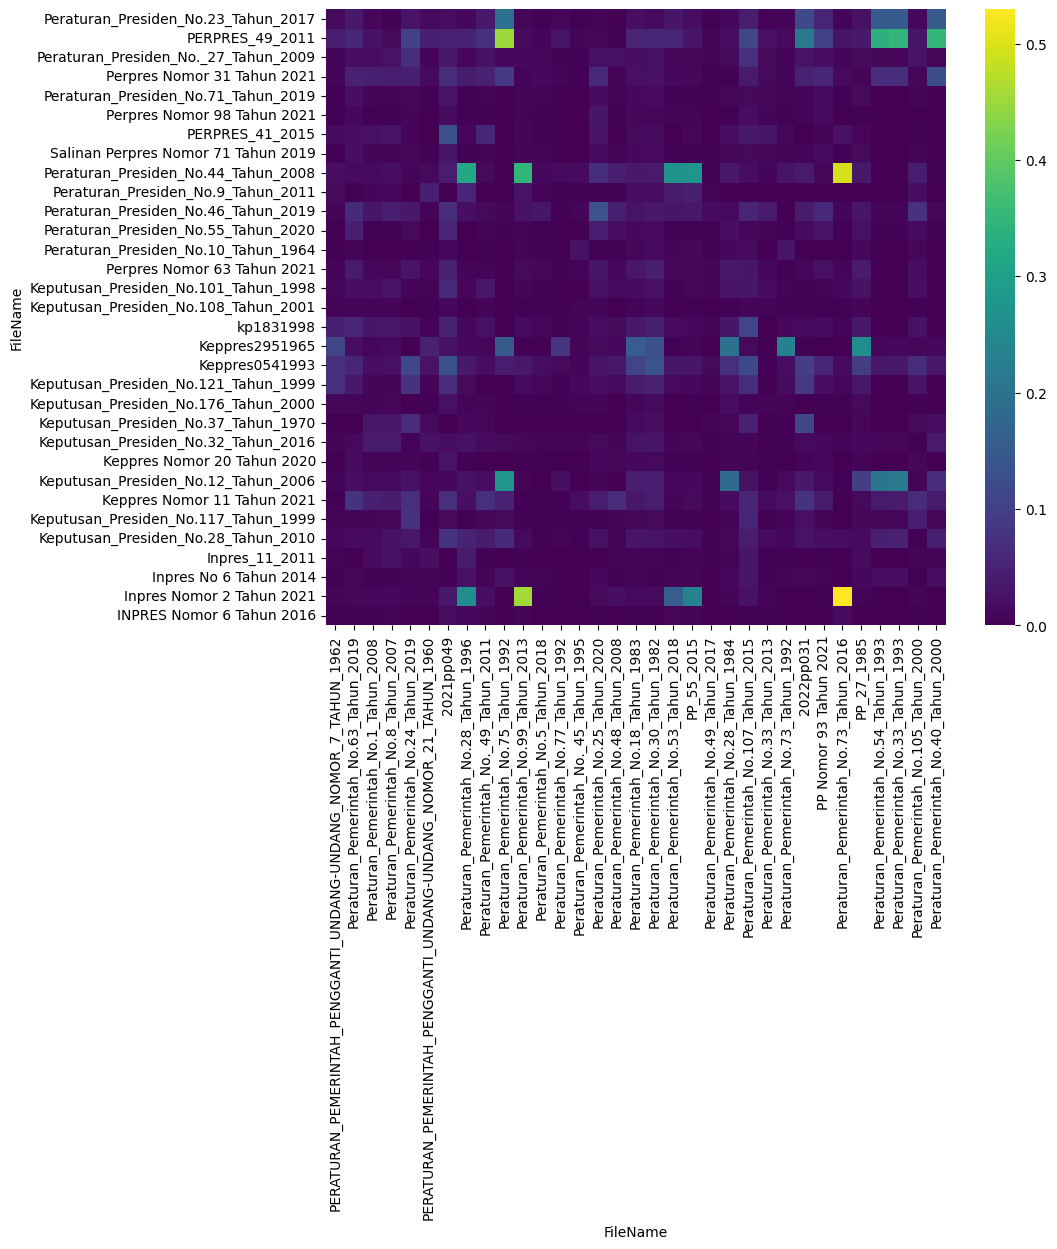

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                             PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                               
Peraturan_Presiden_No.23_Tahun_2017                                       Tidak Selaras                
PERPRES_49_2011                                                           Tidak Selaras                
Peraturan_Presiden_No._27_Tahun_2009                                      Tidak Selaras                
Perpres Nomor 31 Tahun 2021                                               Tidak Selaras                
Peraturan_Presiden_No.71_Tahun_2019                                       Tidak Selaras                
Perpres Nomor 98 Tahun 2021                                               Tidak Selaras                
PERPRES_41_2015                                                           Tidak Selaras                
Salinan Perpres Nomor 71 Tahun 2019                                       Tidak Selaras                
Peraturan_Presiden_No.44_Tahun_2008                                       Tidak Selaras                
Peraturan_Presiden_No.9_Tahun_2011                                        Tidak Selaras                
Peraturan_Presiden_No.46_Tahun_2019                                       Tidak Selaras                
Peraturan_Presiden_No.55_Tahun_2020                                       Tidak Selaras                
Peraturan_Presiden_No.10_Tahun_1964                                       Tidak Selaras                
Perpres Nomor 63 Tahun 2021                                               Tidak Selaras                
Keputusan_Presiden_No.101_Tahun_1998                                      Tidak Selaras                
Keputusan_Presiden_No.108_Tahun_2001                                      Tidak Selaras                
kp1831998                                                                 Tidak Selaras                
Keppres2951965                                                                   Netral                
Keppres0541993                                                            Tidak Selaras                
Keputusan_Presiden_No.121_Tahun_1999                                      Tidak Selaras                
Keputusan_Presiden_No.176_Tahun_2000                                      Tidak Selaras                
Keputusan_Presiden_No.37_Tahun_1970                                       Tidak Selaras                
Keputusan_Presiden_No.32_Tahun_2016                                       Tidak Selaras                
Keppres Nomor 20 Tahun 2020                                               Tidak Selaras                
Keputusan_Presiden_No.12_Tahun_2006                                       Tidak Selaras                
Keppres Nomor 11 Tahun 2021                                               Tidak Selaras                
Keputusan_Presiden_No.117_Tahun_1999                                      Tidak Selaras                
Keputusan_Presiden_No.28_Tahun_2010                                       Tidak Selaras                
Inpres_11_2011                                                            Tidak Selaras                
Inpres No 6 Tahun 2014                                                    Tidak Selaras                
Inpres Nomor 2 Tahun 2021                                                 Tidak Selaras                
INPRES Nomor 6 Tahun 2016                                                 Tidak Selaras                

FileName                             Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017                          Tidak Selaras   
PERPRES_49_2011                                              Tidak Selaras   
Peraturan_Presiden_No._27_Tahun_2009                         Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                  Tidak Selara

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral           39.0
Selaras           4.0
Tidak Selaras  1013.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                           Perundangan2
0                      PERPRES_49_2011  Peraturan_Pemerintah_No.75_Tahun_1992
1  Peraturan_Presiden_No.44_Tahun_2008  Peraturan_Pemerintah_No.73_Tahun_2016
2            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.99_Tahun_2013
3            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.73_Tahun_2016

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                           Perundangan2  \
0                      PERPRES_49_2011  Peraturan_Pemerintah_No.75_Tahun_1992   
1  Peraturan_Presiden_No.44_Tahun_2008  Peraturan_Pemerintah_No.73_Tahun_2016   
2            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.99_Tahun_2013   
3            Inpres Nomor 2 Tahun 2021  Peraturan_Pemerintah_No.73_Tahun_2016   

                                              Topic1  \
0  kesah asean comprehensive investment agreement...   
1                       sistem jamin sosial nasional   
2                                       nomor 2 2021   
3                                       nomor 2 2021   

                                              Topic2  
0  tetap atur perintah republik indonesia serta m...  
1  atur perintah pajak hasil program jamin sosial...  
2                         tetap atur perintah kelola  
3  atur perintah pajak hasil program jamin sosial...

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
5    Peraturan_Pemerintah_No.73_Tahun_1992   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7                          PERPRES_49_2011   
8      Peraturan_Presiden_No.44_Tahun_2008   
9                Inpres Nomor 2 Tahun 2021   
10               Inpres Nomor 2 Tahun 2021   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No._24_Tahun_2011   
5          Undang-Undang_No.40_Tahun_2014   
6         Undang-Undang_No._24_Tahun_2011   
7   Peraturan_Pemerintah_No.75_Tahun_1992   
8   Peraturan_Pemerintah_No.73_Tahun_2016   
9   Peraturan_Pemerintah_No.99_Tahun_2013   
10  Peraturan_Pemerintah_No.73_Tahun_2016   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
5         atur perintah republik indonesia selenggara   
6   atur perintah pajak hasil program jamin sosial...   
7   kesah asean comprehensive investment agreement...   
8                        sistem jamin sosial nasional   
9                                        nomor 2 2021   
10                                       nomor 2 2021   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
5                        tetap undang undang asuransi  
6         undang undang badan selenggara jamin sosial  
7   tetap atur perintah republik indonesia serta m...  
8   atur perintah pajak hasil program jamin sosial...  
9                          tetap atur perintah kelola  
10  atur perintah pajak hasil program jamin sosial...

## UU_Perpu vs Peraturan Presiden

In [ ]:
selected_df = df.query('Tingkatan == "UU_Perpu" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, asuransi janji ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi asuransi janji us...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'])
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(50, 1000)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 puluh' '00 puluh triliun' '00 ratus' '00 ratus puluh' '00 triliun'
 '000 00' '000 00 puluh' '000 00 ratus' '000 00 triliun' '000 000'
 '000 000 00' '000 000 000' '10 puluh' '20 puluh' '2019 covid'
 '2019 covid 19' '31 desember' '72 va' '72 va ny' 'ada barang'
 'ada barang jasa' 'agen asuransi' 'ahli bidang' 'ahli bidang ekonomi'
 'ahli bidang hubung' 'air minum' 'akad jain' 'akad jain tentang'
 'aksud ayat' 'aktif program' 'aktif program jamin' 'alat sehat'
 'alokasi anggar' 'alokasi dana' 'ambil langkah' 'ambil langkah langkah'
 'ampun pajak' 'ana dim' 'ana dim aksud' 'ana dm' 'ana dm aksud'
 'analisis evaluasi' 'analisis evaluasi lapor' 'anggar 2015' 'anggar 2021'
 'anggar anggar' 'anggar belanja' 'anggar dapat' 'anggar dapat belanja'
 'anggar didik' 'anggar jalan' 'anggar menteri' 'anggar menteri negara'
 'anggota dewan' 'anggota dewan awas' 'anggota dewan komisioner'
 'anggota direksi' 'antara dagang' 'antara dagang efek' 'aparatur negara'
 'apbn anggar' 'apbn u

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 puluh  00 puluh triliun  00 ratus  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017   0.000000          0.000000  0.000000   
PERPRES_49_2011                       0.000000          0.000000  0.000000   
Peraturan_Presiden_No._27_Tahun_2009  0.000000          0.000000  0.000000   
Perpres Nomor 31 Tahun 2021           0.000000          0.000000  0.000000   
Peraturan_Presiden_No.71_Tahun_2019   0.000000          0.000000  0.000000   
Perpres Nomor 98 Tahun 2021           0.000000          0.000000  0.000000   
PERPRES_41_2015                       0.000000          0.000000  0.000000   
Salinan Perpres Nomor 71 Tahun 2019   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.44_Tahun_2008   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.9_Tahun_2011    0.000000          0.000000  0.000000   
Peraturan_Presiden_No.46_Tahun_2019   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.55_Tahun_2020   0.000000          0.000000  0.000000   
Peraturan_Presiden_No.10_Tahun_1964   0.000000          0.000000  0.000000   
Perpres Nomor 63 Tahun 2021           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.101_Tahun_1998  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.108_Tahun_2001  0.000000          0.000000  0.000000   
kp1831998                             0.000000          0.000000  0.000000   
Keppres2951965                        0.000000          0.000000  0.000000   
Keppres0541993                        0.000000          0.000000  0.000000   
Keputusan_Presiden_No.121_Tahun_1999  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.176_Tahun_2000  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.37_Tahun_1970   0.000000          0.000000  0.000000   
Keputusan_Presiden_No.32_Tahun_2016   0.000000          0.000000  0.000000   
Keppres Nomor 20 Tahun 2020           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.12_Tahun_2006   0.000000          0.000000  0.000000   
Keppres Nomor 11 Tahun 2021           0.000000          0.000000  0.000000   
Keputusan_Presiden_No.117_Tahun_1999  0.000000          0.000000  0.000000   
Keputusan_Presiden_No.28_Tahun_2010   0.000000          0.000000  0.000000   
Inpres_11_2011                        0.000000          0.000000  0.000000   
Inpres No 6 Tahun 2014                0.000000          0.000000  0.000000   
Inpres Nomor 2 Tahun 2021             0.000000          0.000000  0.000000   
INPRES Nomor 6 Tahun 2016             0.000000          0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995         0.000000          0.000000  0.000000   
Undang-Undang_No.11_Tahun_2016        0.013444          0.000000  0.000000   
Undang-Undang_No.1_Tahun_2004         0.008380          0.000000  0.000000   
Undang-Undang_No.4_Tahun_2016         0.000000          0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008        0.008813          0.000000  0.018451   
Salinan UU Nomor 9 Tahun 2020         0.055007          0.044353  0.076777   
Undang-Undang_No._24_Tahun_2011       0.000000          0.000000  0.015071   
UU411999                              0.000000          0.000000  0.000000   
UU Nomor 4 Tahun 2009                 0.003674          0.000000  0.003846   
Undang-Undang_No.27_Tahun_2014        0.053508          0.055928  0.074684   
UU_34_1964                            0.000000          0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006        0.000000          0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004        0.000000          0.000000  0.007117   
Undang-Undang_No.33_Tahun_2004        0.000000          0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018         0.003682          0.000000  0.000000   
Undang-Undang_No.40_Tahun_2014        0.000000          0.000000  0.000000   
Perpu Nomor 1 Tahun 2020              0.000000          0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962        0.000000          0.00

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName' in df where 'Tingkatan' is 'UU_Perpu'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

# Filter the 'FileName' in df where 'Tingkatan' is 'Peraturan Presiden'
PPres_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PPres_file_names]
filtered_df

FileName                              Undang-Undang_No.8_Tahun_1995  \
FileName                                                              
Peraturan_Presiden_No.23_Tahun_2017                        0.005635   
PERPRES_49_2011                                            0.016532   
Peraturan_Presiden_No._27_Tahun_2009                       0.010656   
Perpres Nomor 31 Tahun 2021                                0.008040   
Peraturan_Presiden_No.71_Tahun_2019                        0.004650   
Perpres Nomor 98 Tahun 2021                                0.000874   
PERPRES_41_2015                                            0.002169   
Salinan Perpres Nomor 71 Tahun 2019                        0.004646   
Peraturan_Presiden_No.44_Tahun_2008                        0.016648   
Peraturan_Presiden_No.9_Tahun_2011                         0.003235   
Peraturan_Presiden_No.46_Tahun_2019                        0.011242   
Peraturan_Presiden_No.55_Tahun_2020                        0.004499   
Peraturan_Presiden_No.10_Tahun_1964                        0.001095   
Perpres Nomor 63 Tahun 2021                                0.010061   
Keputusan_Presiden_No.101_Tahun_1998                       0.004657   
Keputusan_Presiden_No.108_Tahun_2001                       0.002400   
kp1831998                                                  0.018378   
Keppres2951965                                             0.012024   
Keppres0541993                                             0.052868   
Keputusan_Presiden_No.121_Tahun_1999                       0.023894   
Keputusan_Presiden_No.176_Tahun_2000                       0.005228   
Keputusan_Presiden_No.37_Tahun_1970                        0.004584   
Keputusan_Presiden_No.32_Tahun_2016                        0.013240   
Keppres Nomor 20 Tahun 2020                                0.002969   
Keputusan_Presiden_No.12_Tahun_2006                        0.004173   
Keppres Nomor 11 Tahun 2021                                0.014187   
Keputusan_Presiden_No.117_Tahun_1999                       0.005071   
Keputusan_Presiden_No.28_Tahun_2010                        0.007423   
Inpres_11_2011                                             0.009059   
Inpres No 6 Tahun 2014                                     0.001948   
Inpres Nomor 2 Tahun 2021                                  0.002601   
INPRES Nomor 6 Tahun 2016                                  0.000685   

FileName                              Undang-Undang_No.11_Tahun_2016  \
FileName                                                               
Peraturan_Presiden_No.23_Tahun_2017                         0.014173   
PERPRES_49_2011                                             0.025247   
Peraturan_Presiden_No._27_Tahun_2009                        0.015936   
Perpres Nomor 31 Tahun 2021                                 0.008898   
Peraturan_Presiden_No.71_Tahun_2019                         0.005321   
Perpres Nomor 98 Tahun 2021                                 0.003957   
PERPRES_41_2015                                             0.006287   
Salinan Perpres Nomor 71 Tahun 2019                         0.005317   
Peraturan_Presiden_No.44_Tahun_2008                         0.018133   
Peraturan_Presiden_No.9_Tahun_2011                          0.000000   
Peraturan_Presiden_No.46_Tahun_2019                         0.023201   
Peraturan_Presiden_No.55_Tahun_2020                         0.005559   
Peraturan_Presiden_No.10_Tahun_1964                         0.061987   
Perpres Nomor 63 Tahun 2021                                 0.015366   
Keputusan_Presiden_No.101_Tahun_1998                        0.009941   
Keputusan_Presiden_No.108_Tahun_2001                        0.000712   
kp1831998                                                   0.020599   
Keppres2951965                                              0.009299   
Keppres0541993                                              0.076042   
Keputusan_Presiden_No.121_Tahun_1999                        0.028433   
K

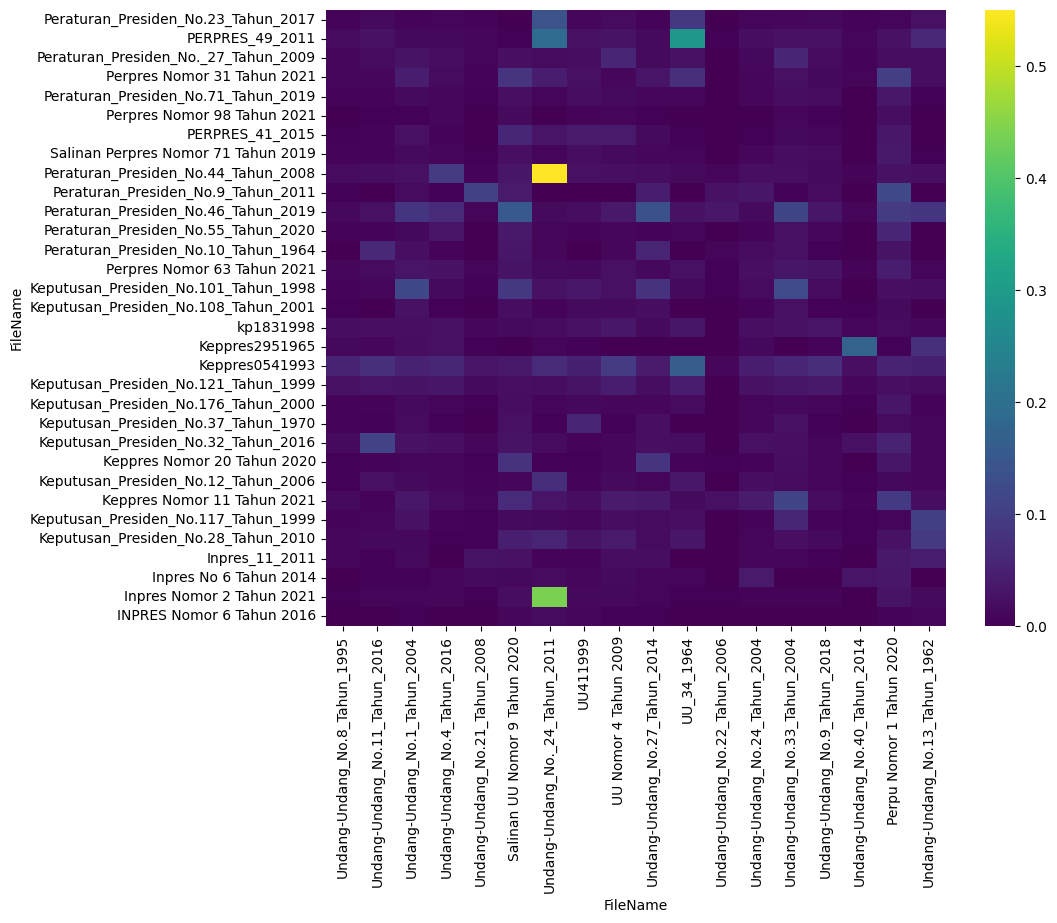

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                             Undang-Undang_No.8_Tahun_1995  \
FileName                                                             
Peraturan_Presiden_No.23_Tahun_2017                  Tidak Selaras   
PERPRES_49_2011                                      Tidak Selaras   
Peraturan_Presiden_No._27_Tahun_2009                 Tidak Selaras   
Perpres Nomor 31 Tahun 2021                          Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                  Tidak Selaras   
Perpres Nomor 98 Tahun 2021                          Tidak Selaras   
PERPRES_41_2015                                      Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                  Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                  Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                   Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019                  Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020                  Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                  Tidak Selaras   
Perpres Nomor 63 Tahun 2021                          Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                 Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                 Tidak Selaras   
kp1831998                                            Tidak Selaras   
Keppres2951965                                       Tidak Selaras   
Keppres0541993                                       Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                 Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                 Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                  Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                  Tidak Selaras   
Keppres Nomor 20 Tahun 2020                          Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                  Tidak Selaras   
Keppres Nomor 11 Tahun 2021                          Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                 Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                  Tidak Selaras   
Inpres_11_2011                                       Tidak Selaras   
Inpres No 6 Tahun 2014                               Tidak Selaras   
Inpres Nomor 2 Tahun 2021                            Tidak Selaras   
INPRES Nomor 6 Tahun 2016                            Tidak Selaras   

FileName                             Undang-Undang_No.11_Tahun_2016  \
FileName                                                              
Peraturan_Presiden_No.23_Tahun_2017                   Tidak Selaras   
PERPRES_49_2011                                       Tidak Selaras   
Peraturan_Presiden_No._27_Tahun_2009                  Tidak Selaras   
Perpres Nomor 31 Tahun 2021                           Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                   Tidak Selaras   
Perpres Nomor 98 Tahun 2021                           Tidak Selaras   
PERPRES_41_2015                                       Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                   Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                   Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                    Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019                   Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020                   Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                   Tidak Selaras   
Perpres Nomor 63 Tahun 2021                           Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                  Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                  Tidak Selaras   
kp1831998                                             Tidak Selaras   
Keppres2951965                                        Tidak Selaras   
Keppres0541993                                        Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                  Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                  Tid

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          15.0
Selaras          2.0
Tidak Selaras  559.0

### Peraturan Peraturan Presiden dan UU_Perpu yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                     Perundangan2
0  Peraturan_Presiden_No.44_Tahun_2008  Undang-Undang_No._24_Tahun_2011
1            Inpres Nomor 2 Tahun 2021  Undang-Undang_No._24_Tahun_2011

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                     Perundangan2  \
0  Peraturan_Presiden_No.44_Tahun_2008  Undang-Undang_No._24_Tahun_2011   
1            Inpres Nomor 2 Tahun 2021  Undang-Undang_No._24_Tahun_2011   

                         Topic1                                       Topic2  
0  sistem jamin sosial nasional  undang undang badan selenggara jamin sosial  
1                  nomor 2 2021  undang undang badan selenggara jamin sosial

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
5    Peraturan_Pemerintah_No.73_Tahun_1992   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7                          PERPRES_49_2011   
8      Peraturan_Presiden_No.44_Tahun_2008   
9                Inpres Nomor 2 Tahun 2021   
10               Inpres Nomor 2 Tahun 2021   
11     Peraturan_Presiden_No.44_Tahun_2008   
12               Inpres Nomor 2 Tahun 2021   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No._24_Tahun_2011   
5          Undang-Undang_No.40_Tahun_2014   
6         Undang-Undang_No._24_Tahun_2011   
7   Peraturan_Pemerintah_No.75_Tahun_1992   
8   Peraturan_Pemerintah_No.73_Tahun_2016   
9   Peraturan_Pemerintah_No.99_Tahun_2013   
10  Peraturan_Pemerintah_No.73_Tahun_2016   
11        Undang-Undang_No._24_Tahun_2011   
12        Undang-Undang_No._24_Tahun_2011   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
5         atur perintah republik indonesia selenggara   
6   atur perintah pajak hasil program jamin sosial...   
7   kesah asean comprehensive investment agreement...   
8                        sistem jamin sosial nasional   
9                                        nomor 2 2021   
10                                       nomor 2 2021   
11                       sistem jamin sosial nasional   
12                                       nomor 2 2021   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
5                        tetap undang undang asuransi  
6         undang undang badan selenggara jamin sosial  
7   tetap atur perintah republik indonesia serta m...  
8   atur perintah pajak hasil program jamin sosial...  
9                          tetap atur perintah kelola  
10  atur perintah pajak hasil program jamin sosial...  
11        undang undang badan selenggara jamin sosial  
12        undang undang badan selenggara jamin sosial

## UU_Perpu vs Peraturan Menteri

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, asuransi janji ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi asuransi janji us...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(43, 500)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 puluh' '00 ratus' '00 triliun' '000 00' '000 00 puluh' '000 00 ratus'
 '000 00 triliun' '000 000' '000 000 00' '000 000 000' '20 puluh'
 '2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' 'aksud ayat'
 'akuntan publik' 'akuntansi lapor' 'akuntansi lapor uang'
 'alokasi anggar' 'ampun pajak' 'ana dm' 'ana dm aksud' 'anggar 2015'
 'anggar 2021' 'anggar anggar' 'anggar belanja' 'anggar dapat'
 'anggar dapat belanja' 'anggar menteri' 'anggar satu' 'anggar satu kerja'
 'anggota dewan' 'anggota dewan komisioner' 'anggota direksi'
 'arsip dinamis' 'asisten deputi' 'asuransi syariah'
 'asuransi syariah usaha' 'asuransi usaha' 'asuransi usaha asuransi'
 'asuransi wajib' 'atur atur' 'atur atur menteri' 'atur atur otoritas'
 'atur atur perintah' 'atur bank' 'atur bank indonesia' 'atur daerah'
 'atur daerah apbd' 'atur laksana' 'atur menteri' 'atur menteri uang'
 'atur otoritas' 'atur otoritas jasa' 'atur perintah' 'atur undang'
 'atur undang undang' 'aval lalitt' 'aval lalitt

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 puluh  00 ratus  \
FileName                                                                 
PERMEN_KEU_231PMK062017_2017                        0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000  0.010934   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000  0.000000   
KEPMNG_LH_9_2001                                    0.000000  0.000000   
PERMEN_DAGRI_52_2012                                0.000000  0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000  0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000  0.000000   
PERMEN_KOMARVES_6_2020                              0.000000  0.000000   
pmmarves001_2022                                    0.000000  0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000  0.021039   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000  0.000000   
1_PMK.05_2021                                       0.000000  0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.098408  0.094400   
pmmarves002_2021                                    0.000000  0.000000   
PERMEN_PERIN_64MINDPER72016_2016                    0.000000  0.000000   
KEPMGK_INVBKPM_12SK1999_1999                        0.000000  0.000000   
KEPMGK_INVBKPM_33SK1998_1998                        0.000000  0.000000   
KEPMGK_INVBKPM_38SK1999_1999                        0.000000  0.000000   
PERMEN_KEU_53PMK052020_2020                         0.000000  0.000000   
Undang-Undang_No.8_Tahun_1995                       0.000000  0.000000   
Undang-Undang_No.11_Tahun_2016                      0.014449  0.000000   
Undang-Undang_No.1_Tahun_2004                       0.008585  0.000000   
Undang-Undang_No.4_Tahun_2016                       0.000000  0.000000   
Undang-Undang_No.21_Tahun_2008                      0.008771  0.016827   
Salinan UU Nomor 9 Tahun 2020                       0.057344  0.073344   
Undang-Undang_No._24_Tahun_2011                     0.000000  0.012990   
UU411999                                            0.000000  0.000000   
UU Nomor 4 Tahun 2009                               0.003609  0.003462   
Undang-Undang_No.27_Tahun_2014                      0.057517  0.073566   
UU_34_1964                                          0.000000  0.000000   
Undang-Undang_No.22_Tahun_2006                      0.000000  0.000000   
Undang-Undang_No.24_Tahun_2004                      0.000000  0.006688   
Undang-Undang_No.33_Tahun_2004                      0.000000  0.000000   
Undang-Undang_No.9_Tahun_2018                       0.003627  0.000000   
Undang-Undang_No.40_Tahun_2014                      0.000000  0.000000   
Perpu Nomor 1 Tahun 2020                            0.000000  0.000000   
Undang-Undang_No.13_Tahun_1962                      0.000000  0.000000   

                                                    00 triliun    000 00  \
FileName                                                                   
PERMEN_KEU_231PMK062017_2017                          0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                          0.000000  0.008344   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                 0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                   0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                  0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                          0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                          0.000000  0.000000   
KEPMNG_LH_9_2001                     

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
UU_file_names = df[df['Tingkatan'] == 'UU_Perpu']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[UU_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            Undang-Undang_No.8_Tahun_1995  \
FileName                                                                            
PERMEN_KEU_231PMK062017_2017                                             0.004636   
KEPMEN_KEU_511KMK062002_2002                                             0.055266   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                    0.000150   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                      0.018173   
KEPMEN_DAGRI_29_2002                                                     0.016469   
KEPMEN_KEU_509KMK062002_2002                                             0.015361   
PERMEN_KEU_103PMK052019_2019                                             0.011121   
KEPMNG_LH_9_2001                                                         0.003347   
PERMEN_DAGRI_52_2012                                                     0.012433   
PERMEN_KEU_91PMK012017_2017                                              0.022888   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       0.013356   
PERMEN_KEU_209PMK052015_2015                                             0.006655   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       0.035395   
PERMEN_KOMARVES_6_2020                                                   0.039777   
pmmarves001_2022                                                         0.018839   
PERMEN_KEU_119PMK082016_2016                                             0.159701   
Keputusan Menteri_KP_45_Tahun_2015                                       0.025589   
1_PMK.05_2021                                                            0.004832   
PERMEN_KEU_50PMK0102019_2019                                             0.036306   
pmmarves002_2021                                                         0.013540   
PERMEN_PERIN_64MINDPER72016_2016                                         0.018715   
KEPMGK_INVBKPM_12SK1999_1999                                             0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                             0.000000   
KEPMGK_INVBKPM_38SK1999_1999                                             0.020055   
PERMEN_KEU_53PMK052020_2020                                              0.000000   

FileName                                            Undang-Undang_No.11_Tahun_2016  \
FileName                                                                             
PERMEN_KEU_231PMK062017_2017                                              0.006161   
KEPMEN_KEU_511KMK062002_2002                                              0.020479   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                     0.001013   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                       0.014376   
KEPMEN_DAGRI_29_2002                                                      0.019184   
KEPMEN_KEU_509KMK062002_2002                                              0.020987   
PERMEN_KEU_103PMK052019_2019                                              0.018268   
KEPMNG_LH_9_2001                                                          0.005851   
PERMEN_DAGRI_52_2012                                                      0.013058   
PERMEN_KEU_91PMK012017_2017                                               0.037595   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                        0.015635   
PERMEN_KEU_209PMK052015_2015                                              0.012613   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                        0.037548   
PERMEN_KOMARVES_6_2020                                                    0.031202   
pmmarves001_2022                                                          0.028318   
PERMEN_KEU_119PMK082016_2016                                              0.617551   
Keputusan Menteri_KP_45_Tahun_2015                                        0.039716   
1_PMK.05_2021                                                         

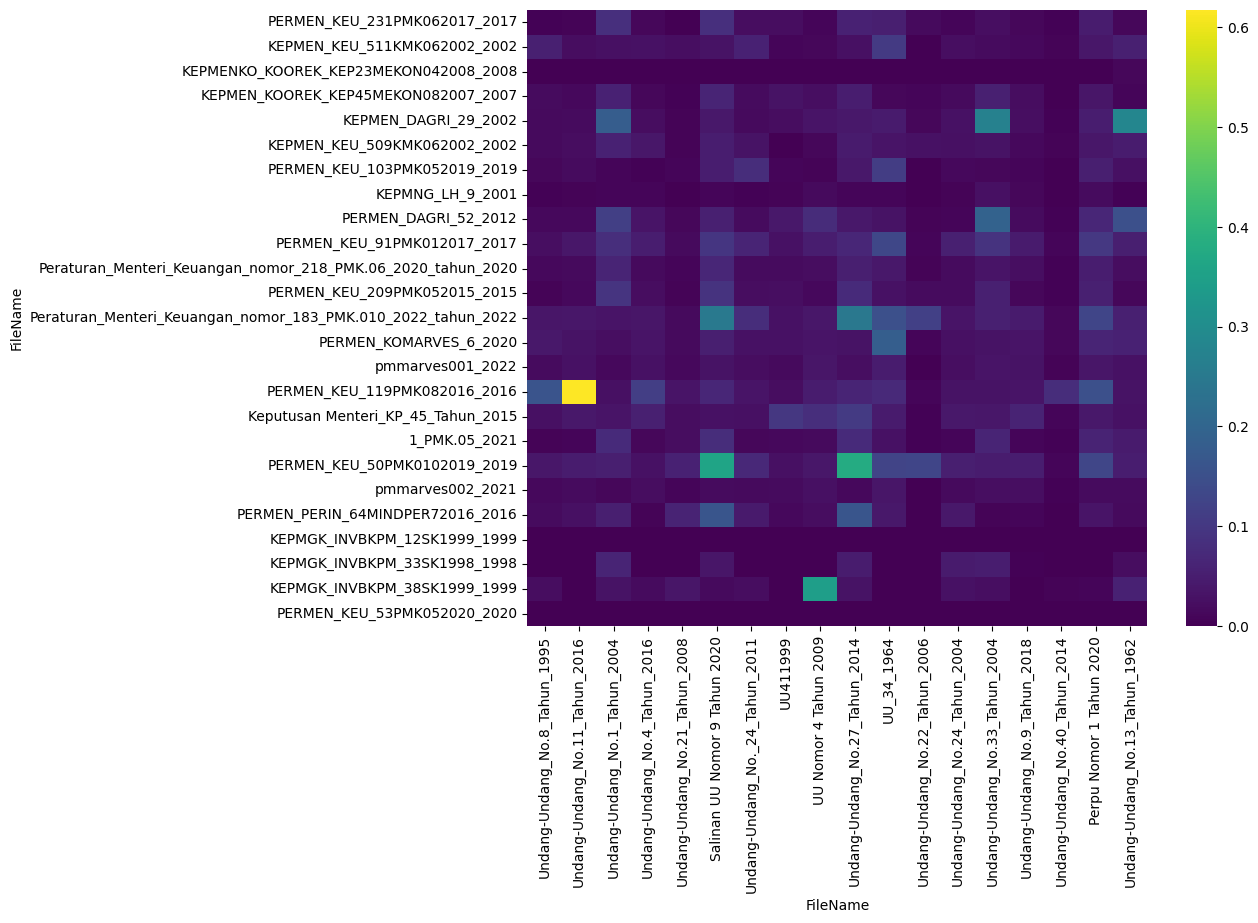

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Undang-Undang_No.8_Tahun_1995  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                       Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                       Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                              Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                Tidak Selaras   
KEPMEN_DAGRI_29_2002                                               Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                       Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                       Tidak Selaras   
KEPMNG_LH_9_2001                                                   Tidak Selaras   
PERMEN_DAGRI_52_2012                                               Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                        Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                 Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                 Tidak Selaras   
PERMEN_KOMARVES_6_2020                                             Tidak Selaras   
pmmarves001_2022                                                   Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                              Netral   
Keputusan Menteri_KP_45_Tahun_2015                                 Tidak Selaras   
1_PMK.05_2021                                                      Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                       Tidak Selaras   
pmmarves002_2021                                                   Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                   Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                       Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                       Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                       Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                        Tidak Selaras   

FileName                                           Undang-Undang_No.11_Tahun_2016  \
FileName                                                                            
PERMEN_KEU_231PMK062017_2017                                        Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                        Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                               Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                 Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                        Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                        Tidak Selaras   
KEPMNG_LH_9_2001                                                    Tidak Selaras   
PERMEN_DAGRI_52_2012                                                Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                         Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                  Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                        Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                  Tidak Selaras   
PERMEN_KOMARVES_6_2020                                              Tidak Selaras   
pmmarves001_2022                                                    Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                              Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                  Tidak Selaras   
1_PMK.05_2021                                                       Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019   

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          28.0
Selaras          1.0
Tidak Selaras  421.0

### Peraturan UU_Perpu dan Peraturan Menteri yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                    Perundangan2
0  PERMEN_KEU_119PMK082016_2016  Undang-Undang_No.11_Tahun_2016

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                    Perundangan2  \
0  PERMEN_KEU_119PMK082016_2016  Undang-Undang_No.11_Tahun_2016   

                   Topic1                     Topic2  
0  atur menteri uang tata  undang undang ampun pajak

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
5    Peraturan_Pemerintah_No.73_Tahun_1992   
6    Peraturan_Pemerintah_No.73_Tahun_2016   
7                          PERPRES_49_2011   
8      Peraturan_Presiden_No.44_Tahun_2008   
9                Inpres Nomor 2 Tahun 2021   
10               Inpres Nomor 2 Tahun 2021   
11     Peraturan_Presiden_No.44_Tahun_2008   
12               Inpres Nomor 2 Tahun 2021   
13            PERMEN_KEU_119PMK082016_2016   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No._24_Tahun_2011   
5          Undang-Undang_No.40_Tahun_2014   
6         Undang-Undang_No._24_Tahun_2011   
7   Peraturan_Pemerintah_No.75_Tahun_1992   
8   Peraturan_Pemerintah_No.73_Tahun_2016   
9   Peraturan_Pemerintah_No.99_Tahun_2013   
10  Peraturan_Pemerintah_No.73_Tahun_2016   
11        Undang-Undang_No._24_Tahun_2011   
12        Undang-Undang_No._24_Tahun_2011   
13         Undang-Undang_No.11_Tahun_2016   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
5         atur perintah republik indonesia selenggara   
6   atur perintah pajak hasil program jamin sosial...   
7   kesah asean comprehensive investment agreement...   
8                        sistem jamin sosial nasional   
9                                        nomor 2 2021   
10                                       nomor 2 2021   
11                       sistem jamin sosial nasional   
12                                       nomor 2 2021   
13                             atur menteri uang tata   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
5                        tetap undang undang asuransi  
6         undang undang badan selenggara jamin sosial  
7   tetap atur perintah republik indonesia serta m...  
8   atur perintah pajak hasil program jamin sosial...  
9                          tetap atur perintah kelola  
10  atur perintah pajak hasil program jamin sosial...  
11        undang undang badan selenggara jamin sosial  
12        undang undang badan selenggara jamin sosial  
13                          undang undang ampun pajak

## Peraturan Pemerintah vs Peraturan Menteri

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "Peraturan Pemerintah"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(58, 500)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '000 00' '000 00 ratus' '000 000' '000 000 00' '000 000 000'
 '10 puluh' '10 puluh persen' '15 belas' '20 puluh' '20 puluh persen'
 '2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' '50 puluh'
 '50 puluh persen' 'agun aset' 'akuntan publik' 'akuntansi lapor'
 'akuntansi lapor uang' 'akuntansi uang' 'alokasi anggar'
 'alokasi anggar perintah' 'anggar dapat' 'anggar dapat belanja'
 'anggar perintah' 'anggar satu' 'anggar satu kerja' 'anggar tahun'
 'anggota direksi' 'arsip dinamis' 'aset bersih' 'aset bpjs'
 'aset bpjs ketenagakerjaan' 'aset dana' 'aset dana jamin'
 'asisten deputi' 'asuransi jiwa' 'asuransi usaha' 'atur atur'
 'atur atur menteri' 'atur daerah' 'atur laksana' 'atur menteri'
 'atur menteri uang' 'atur perintah' 'atur perintah atur'
 'atur perintah laku' 'atur perintah nomor' 'atur perintah tempat'
 'atur undang' 'atur undang undang' 'aval lalitt' 'aval lalitt maelii'
 'awas internal' 'ayat atur' 'ayat atur atur' 'ayat ayat' 'ayat huruf'
 'ayat

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus    000 00  \
FileName                                                                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019               0.000000  0.011653   
Peraturan_Pemerintah_No.1_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019               0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
2021pp049                                           0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996               0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011              0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995              0.155785  0.288746   
Peraturan_Pemerintah_No.25_Tahun_2020               0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008               0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983               0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982               0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018               0.000000  0.000000   
PP_55_2015                                          0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984               0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015              0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992               0.000000  0.000000   
2022pp031                                           0.000000  0.000000   
PP Nomor 93 Tahun 2021                              0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016               0.000000  0.000000   
PP_27_1985                                          0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000              0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000               0.000000  0.000000   
PERMEN_KEU_231PMK062017_2017                        0.000000  0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.014305  0.012917   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000  0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000  0.000000   
KEPMEN_DAGRI_29_2002                                0.000000  0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000  0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000  0.000000   
KEPMNG_LH_9_2001                                    0.000000  0.000000   
PERMEN_DAGRI_52_2012                                0.000000  0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000  0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000  0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000  0.000000   
PERMEN_KOMARVES_6_2020                              0.000000  0.000000   
pmmarves001_2022                                    0.000000  0.000000   
PERMEN_KEU_119PMK082016_2016                        0.033180  0.059921   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000  0.000000   
1_PMK.05_2021                                       0.000000  0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.120116  0.325387   
pmmarves002_2021                                    0.00

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Pemerintah']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                              
PERMEN_KEU_231PMK062017_2017                                                                 0.035220                 
KEPMEN_KEU_511KMK062002_2002                                                                 0.032281                 
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                                        0.000984                 
KEPMEN_KOOREK_KEP45MEKON082007_2007                                                          0.016251                 
KEPMEN_DAGRI_29_2002                                                                         0.035131                 
KEPMEN_KEU_509KMK062002_2002                                                                 0.006052                 
PERMEN_KEU_103PMK052019_2019                                                                 0.024553                 
KEPMNG_LH_9_2001                                                                             0.003529                 
PERMEN_DAGRI_52_2012                                                                         0.025499                 
PERMEN_KEU_91PMK012017_2017                                                                  0.026056                 
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                                           0.051660                 
PERMEN_KEU_209PMK052015_2015                                                                 0.023489                 
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                                           0.060774                 
PERMEN_KOMARVES_6_2020                                                                       0.069171                 
pmmarves001_2022                                                                             0.017273                 
PERMEN_KEU_119PMK082016_2016                                                                 0.063838                 
Keputusan Menteri_KP_45_Tahun_2015                                                           0.048843                 
1_PMK.05_2021                                                                                0.003326                 
PERMEN_KEU_50PMK0102019_2019                                                                 0.051944                 
pmmarves002_2021                                                                             0.016990                 
PERMEN_PERIN_64MINDPER72016_2016                                                             0.003402                 
KEPMGK_INVBKPM_12SK1999_1999                                                                 0.000000                 
KEPMGK_INVBKPM_33SK1998_1998                                                                 0.000000                 
KEPMGK_INVBKPM_38SK1999_1999                                                                 0.000000                 
PERMEN_KEU_53PMK052020_2020                                                                  0.000000                 

FileName                                            Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                                    
PERMEN_KEU_231PMK062017_2017                                                     0.371035   
KEPMEN_KEU_511KMK062002_2002                                                     0.060905   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                            0.000189   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                              0.016604   
KEPMEN_DAGRI_29_2002                                                             0.021441   
KEPMEN_KEU_509KMK062002_2002                                                     0.024770   
PERMEN_KEU_103PMK052019_2019              

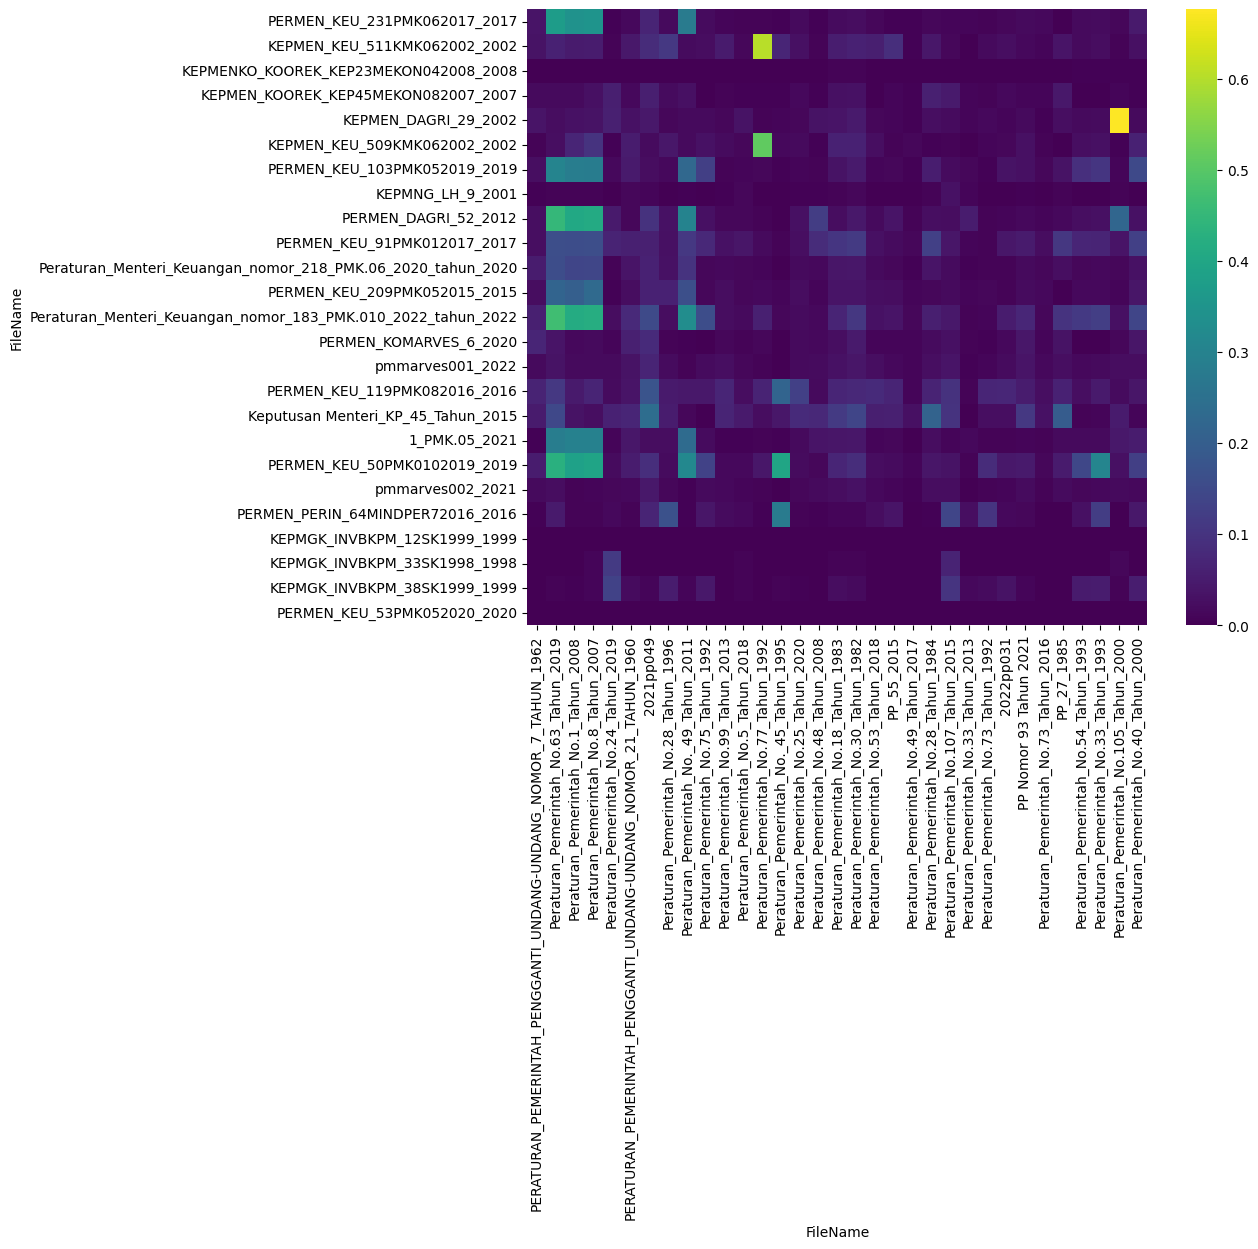

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERMEN_KEU_231PMK062017_2017                                                            Tidak Selaras                
KEPMEN_KEU_511KMK062002_2002                                                            Tidak Selaras                
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                                   Tidak Selaras                
KEPMEN_KOOREK_KEP45MEKON082007_2007                                                     Tidak Selaras                
KEPMEN_DAGRI_29_2002                                                                    Tidak Selaras                
KEPMEN_KEU_509KMK062002_2002                                                            Tidak Selaras                
PERMEN_KEU_103PMK052019_2019                                                            Tidak Selaras                
KEPMNG_LH_9_2001                                                                        Tidak Selaras                
PERMEN_DAGRI_52_2012                                                                    Tidak Selaras                
PERMEN_KEU_91PMK012017_2017                                                             Tidak Selaras                
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                                      Tidak Selaras                
PERMEN_KEU_209PMK052015_2015                                                            Tidak Selaras                
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                                      Tidak Selaras                
PERMEN_KOMARVES_6_2020                                                                  Tidak Selaras                
pmmarves001_2022                                                                        Tidak Selaras                
PERMEN_KEU_119PMK082016_2016                                                            Tidak Selaras                
Keputusan Menteri_KP_45_Tahun_2015                                                      Tidak Selaras                
1_PMK.05_2021                                                                           Tidak Selaras                
PERMEN_KEU_50PMK0102019_2019                                                            Tidak Selaras                
pmmarves002_2021                                                                        Tidak Selaras                
PERMEN_PERIN_64MINDPER72016_2016                                                        Tidak Selaras                
KEPMGK_INVBKPM_12SK1999_1999                                                            Tidak Selaras                
KEPMGK_INVBKPM_33SK1998_1998                                                            Tidak Selaras                
KEPMGK_INVBKPM_38SK1999_1999                                                            Tidak Selaras                
PERMEN_KEU_53PMK052020_2020                                                             Tidak Selaras                

FileName                                           Peraturan_Pemerintah_No.63_Tahun_2019  \
FileName                                                                                   
PERMEN_KEU_231PMK062017_2017                                                      Netral   
KEPMEN_KEU_511KMK062002_2002                                               Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                      Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                        Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                       Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                               Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                                 

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          69.0
Selaras         10.0
Tidak Selaras  746.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0                       KEPMEN_KEU_511KMK062002_2002   
1                               KEPMEN_DAGRI_29_2002   
2                       KEPMEN_KEU_509KMK062002_2002   
3                               PERMEN_DAGRI_52_2012   
4                               PERMEN_DAGRI_52_2012   
5                               PERMEN_DAGRI_52_2012   
6  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
7  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
8  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
9                       PERMEN_KEU_50PMK0102019_2019   

                             Perundangan2  
0   Peraturan_Pemerintah_No.77_Tahun_1992  
1  Peraturan_Pemerintah_No.105_Tahun_2000  
2   Peraturan_Pemerintah_No.77_Tahun_1992  
3   Peraturan_Pemerintah_No.63_Tahun_2019  
4    Peraturan_Pemerintah_No.1_Tahun_2008  
5    Peraturan_Pemerintah_No.8_Tahun_2007  
6   Peraturan_Pemerintah_No.63_Tahun_2019  
7    Peraturan_Pemerintah_No.1_Tahun_2008  
8    Peraturan_Pemerintah_No.8_Tahun_2007  
9   Peraturan_Pemerintah_No.63_Tahun_2019

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1  \
0                       KEPMEN_KEU_511KMK062002_2002   
1                               KEPMEN_DAGRI_29_2002   
2                       KEPMEN_KEU_509KMK062002_2002   
3                               PERMEN_DAGRI_52_2012   
4                               PERMEN_DAGRI_52_2012   
5                               PERMEN_DAGRI_52_2012   
6  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
7  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
8  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
9                       PERMEN_KEU_50PMK0102019_2019   

                             Perundangan2  \
0   Peraturan_Pemerintah_No.77_Tahun_1992   
1  Peraturan_Pemerintah_No.105_Tahun_2000   
2   Peraturan_Pemerintah_No.77_Tahun_1992   
3   Peraturan_Pemerintah_No.63_Tahun_2019   
4    Peraturan_Pemerintah_No.1_Tahun_2008   
5    Peraturan_Pemerintah_No.8_Tahun_2007   
6   Peraturan_Pemerintah_No.63_Tahun_2019   
7    Peraturan_Pemerintah_No.1_Tahun_2008   
8    Peraturan_Pemerintah_No.8_Tahun_2007   
9   Peraturan_Pemerintah_No.63_Tahun_2019   

                                              Topic1  \
0  putus menteri uang investasi dana pensiun ment...   
1  putus menteri negeri pedoman urus pertanggungj...   
2  putus menteri uang lapor uang dana pensiun men...   
3                          tetap atur menteri negeri   
4                          tetap atur menteri negeri   
5                          tetap atur menteri negeri   
6  tetap atur menteri uang tambah investasi perin...   
7  tetap atur menteri uang tambah investasi perin...   
8  tetap atur menteri uang tambah investasi perin...   
9                                  atur menteri uang   

                                              Topic2  
0  tetap atur perintah republik indonesia dana pe...  
1  tetap atur perintah kelola pertanggungjawaban ...  
2  tetap atur perintah republik indonesia dana pe...  
3                   atur perintah investasi perintah  
4                   atur perintah investasi perintah  
5             tetap atur perintah investasi perintah  
6                   atur perintah investasi perintah  
7                   atur perintah investasi perintah  
8             tetap atur perintah investasi perintah  
9                   atur perintah investasi perintah

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3               Peraturan_Pemerintah_No.53_Tahun_2018   
4                                          PP_55_2015   
5               Peraturan_Pemerintah_No.73_Tahun_1992   
6               Peraturan_Pemerintah_No.73_Tahun_2016   
7                                     PERPRES_49_2011   
8                 Peraturan_Presiden_No.44_Tahun_2008   
9                           Inpres Nomor 2 Tahun 2021   
10                          Inpres Nomor 2 Tahun 2021   
11                Peraturan_Presiden_No.44_Tahun_2008   
12                          Inpres Nomor 2 Tahun 2021   
13                       PERMEN_KEU_119PMK082016_2016   
14                       KEPMEN_KEU_511KMK062002_2002   
15                               KEPMEN_DAGRI_29_2002   
16                       KEPMEN_KEU_509KMK062002_2002   
17                               PERMEN_DAGRI_52_2012   
18                               PERMEN_DAGRI_52_2012   
19                               PERMEN_DAGRI_52_2012   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
22  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
23                       PERMEN_KEU_50PMK0102019_2019   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No._24_Tahun_2011   
5           Undang-Undang_No.40_Tahun_2014   
6          Undang-Undang_No._24_Tahun_2011   
7    Peraturan_Pemerintah_No.75_Tahun_1992   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9    Peraturan_Pemerintah_No.99_Tahun_2013   
10   Peraturan_Pemerintah_No.73_Tahun_2016   
11         Undang-Undang_No._24_Tahun_2011   
12         Undang-Undang_No._24_Tahun_2011   
13          Undang-Undang_No.11_Tahun_2016   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15  Peraturan_Pemerintah_No.105_Tahun_2000   
16   Peraturan_Pemerintah_No.77_Tahun_1992   
17   Peraturan_Pemerintah_No.63_Tahun_2019   
18    Peraturan_Pemerintah_No.1_Tahun_2008   
19    Peraturan_Pemerintah_No.8_Tahun_2007   
20   Peraturan_Pemerintah_No.63_Tahun_2019   
21    Peraturan_Pemerintah_No.1_Tahun_2008   
22    Peraturan_Pemerintah_No.8_Tahun_2007   
23   Peraturan_Pemerintah_No.63_Tahun_2019   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
5         atur perintah republik indonesia selenggara   
6   atur perintah pajak hasil program jamin sosial...   
7   kesah asean comprehensive investment agreement...   
8                        sistem jamin sosial nasional   
9                                        nomor 2 2021   
10                                       nomor 2 2021   
11                       sistem jamin sosial nasional   
12                                       nomor 2 2021   
13                             atur menteri uang tata   
14  putus menteri uang investasi dana pensiun ment...   
15  putus menteri negeri pedoman urus pertanggungj...   
16  putus menteri uang lapor uang dana pensiun men...   
17                          tetap atur menteri negeri   
18                          tetap atur menteri negeri   
19                          tetap atur menteri negeri   
20  tetap atur menteri uang tambah investasi perin...   
21  tetap atur menteri uang tambah investasi perin...   
22  tetap atur menteri uang tambah investasi perin...   
23                                  atur menteri uang   

                                      

## Peraturan Presiden vs Peraturan Menteri

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Menteri" or Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 500)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(57, 500)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' 'ahli bidang'
 'ahli bidang ekonomi' 'ahli bidang hubung' 'aktif program'
 'aktif program jamin' 'akuntan publik' 'akuntansi lapor'
 'akuntansi lapor uang' 'alat sehat' 'ampun pajak' 'analisis evaluasi'
 'anggar dapat' 'anggar dapat belanja' 'anggar satu' 'anggar satu kerja'
 'aparatur negara' 'arsip dinamis' 'aset daerah' 'asisten deputi'
 'atur atur' 'atur daerah' 'atur menteri' 'atur menteri uang'
 'atur undang' 'atur undang undang' 'aval lalitt' 'aval lalitt maelii'
 'ayat ayat' 'ayat cantum' 'ayat cantum lampir' 'ayat huruf' 'ayat tetap'
 'ba bun' 'badan koordinasi' 'badan koordinasi tanam' 'badan layan'
 'badan usaha' 'badan usaha milik' 'bahan koordinasi'
 'bahan koordinasi telaah' 'bahan rancang' 'bahan rancang rumus'
 'bangun manusia' 'bangun manusia budaya' 'bangun nasional'
 'baseline emisi' 'baseline emisi grk' 'beban anggar' 'belanja daerah'
 'belanja negara' 'bendahara negara' 'beri dukung'
 'beri dukung 

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

2015 no  2015 no 1785  \
FileName                                                                     
Peraturan_Presiden_No.23_Tahun_2017                 0.000000      0.000000   
PERPRES_49_2011                                     0.000000      0.000000   
Peraturan_Presiden_No._27_Tahun_2009                0.000000      0.000000   
Perpres Nomor 31 Tahun 2021                         0.000000      0.000000   
Peraturan_Presiden_No.71_Tahun_2019                 0.000000      0.000000   
Perpres Nomor 98 Tahun 2021                         0.000000      0.000000   
PERPRES_41_2015                                     0.000000      0.000000   
Salinan Perpres Nomor 71 Tahun 2019                 0.000000      0.000000   
Peraturan_Presiden_No.44_Tahun_2008                 0.000000      0.000000   
Peraturan_Presiden_No.9_Tahun_2011                  0.000000      0.000000   
Peraturan_Presiden_No.46_Tahun_2019                 0.000000      0.000000   
Peraturan_Presiden_No.55_Tahun_2020                 0.000000      0.000000   
Peraturan_Presiden_No.10_Tahun_1964                 0.000000      0.000000   
Perpres Nomor 63 Tahun 2021                         0.000000      0.000000   
Keputusan_Presiden_No.101_Tahun_1998                0.000000      0.000000   
Keputusan_Presiden_No.108_Tahun_2001                0.000000      0.000000   
kp1831998                                           0.000000      0.000000   
Keppres2951965                                      0.000000      0.000000   
Keppres0541993                                      0.000000      0.000000   
Keputusan_Presiden_No.121_Tahun_1999                0.000000      0.000000   
Keputusan_Presiden_No.176_Tahun_2000                0.000000      0.000000   
Keputusan_Presiden_No.37_Tahun_1970                 0.000000      0.000000   
Keputusan_Presiden_No.32_Tahun_2016                 0.000000      0.000000   
Keppres Nomor 20 Tahun 2020                         0.000000      0.000000   
Keputusan_Presiden_No.12_Tahun_2006                 0.000000      0.000000   
Keppres Nomor 11 Tahun 2021                         0.000000      0.000000   
Keputusan_Presiden_No.117_Tahun_1999                0.000000      0.000000   
Keputusan_Presiden_No.28_Tahun_2010                 0.000000      0.000000   
Inpres_11_2011                                      0.000000      0.000000   
Inpres No 6 Tahun 2014                              0.000000      0.000000   
Inpres Nomor 2 Tahun 2021                           0.000000      0.000000   
INPRES Nomor 6 Tahun 2016                           0.000000      0.000000   
PERMEN_KEU_231PMK062017_2017                        0.000000      0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000      0.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000      0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000      0.000000   
KEPMEN_DAGRI_29_2002                                0.000000      0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000      0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000      0.000000   
KEPMNG_LH_9_2001                                    0.000000      0.000000   
PERMEN_DAGRI_52_2012                                0.000000      0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000      0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000      0.000000   
PERMEN_KEU_209PMK052015_2015                        0.353311      0.353311   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000      0.000000   
PERMEN_KOMARVES_6_2020                              0.000000      0.000000   
pmmarves001_2022                                    0.000000      0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000      0.000000   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000      0.000000   
1_PMK.05_2021                                       0.000000      0.000000 

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

# Filter the 'FileName'
PM_file_names = df[df['Tingkatan'] == 'Peraturan Menteri']['FileName'].values

# Filter the 'FileName'
PP_file_names = df[df['Tingkatan'] == 'Peraturan Presiden']['FileName'].values

In [ ]:
filtered_df = cosine_similarity_df[PP_file_names]
filtered_df = filtered_df.loc[PM_file_names]
filtered_df

FileName                                            Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                                  
PERMEN_KEU_231PMK062017_2017                                                   0.010048   
KEPMEN_KEU_511KMK062002_2002                                                   0.014133   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                          0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                            0.000000   
KEPMEN_DAGRI_29_2002                                                           0.003686   
KEPMEN_KEU_509KMK062002_2002                                                   0.017603   
PERMEN_KEU_103PMK052019_2019                                                   0.058878   
KEPMNG_LH_9_2001                                                               0.000000   
PERMEN_DAGRI_52_2012                                                           0.004858   
PERMEN_KEU_91PMK012017_2017                                                    0.053116   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                             0.004024   
PERMEN_KEU_209PMK052015_2015                                                   0.002851   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                             0.196930   
PERMEN_KOMARVES_6_2020                                                         0.000000   
pmmarves001_2022                                                               0.008974   
PERMEN_KEU_119PMK082016_2016                                                   0.016543   
Keputusan Menteri_KP_45_Tahun_2015                                             0.000000   
1_PMK.05_2021                                                                  0.009208   
PERMEN_KEU_50PMK0102019_2019                                                   0.093303   
pmmarves002_2021                                                               0.008014   
PERMEN_PERIN_64MINDPER72016_2016                                               0.047305   
KEPMGK_INVBKPM_12SK1999_1999                                                   0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                                   0.000000   
KEPMGK_INVBKPM_38SK1999_1999                                                   0.000000   
PERMEN_KEU_53PMK052020_2020                                                    0.000000   

FileName                                            PERPRES_49_2011  \
FileName                                                              
PERMEN_KEU_231PMK062017_2017                               0.023825   
KEPMEN_KEU_511KMK062002_2002                               0.030490   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                      0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                        0.103018   
KEPMEN_DAGRI_29_2002                                       0.006893   
KEPMEN_KEU_509KMK062002_2002                               0.046517   
PERMEN_KEU_103PMK052019_2019                               0.169135   
KEPMNG_LH_9_2001                                           0.000000   
PERMEN_DAGRI_52_2012                                       0.013954   
PERMEN_KEU_91PMK012017_2017                                0.106930   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...         0.010633   
PERMEN_KEU_209PMK052015_2015                               0.010426   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...         0.205976   
PERMEN_KOMARVES_6_2020                                     0.000000   
pmmarves001_2022                                           0.025781   
PERMEN_KEU_119PMK082016_2016                               0.041332   
Keputusan Menteri_KP_45_Tahun_2015                         0.000000   
1_PMK.05_2021                                              0.026451   
PERMEN_KEU_50PMK0102019_2019                               0.223893   
pmmarves002_2021                                   

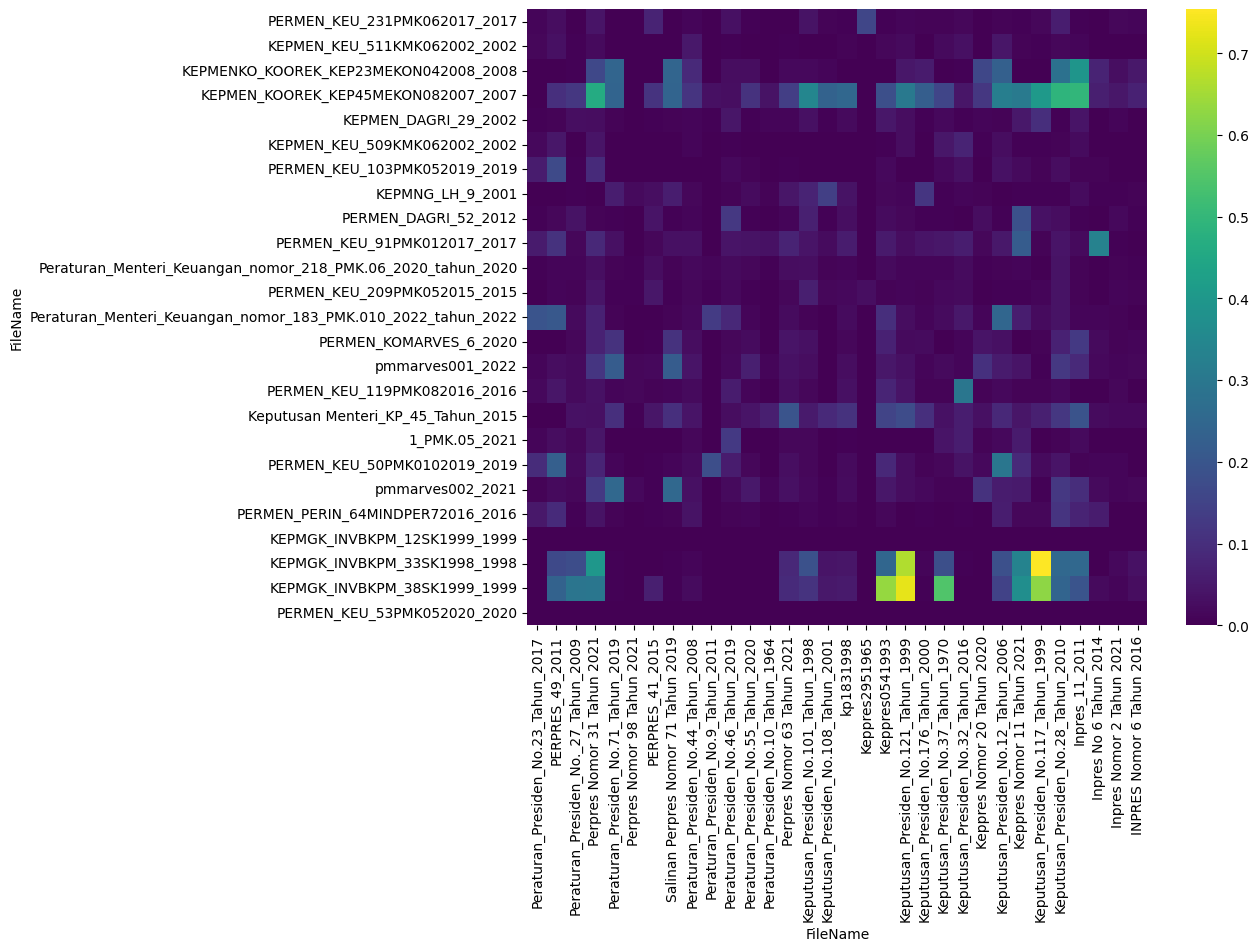

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = filtered_df.applymap(convert_to_label)
label_df

FileName                                           Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                                 
PERMEN_KEU_231PMK062017_2017                                             Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                             Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                    Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                      Tidak Selaras   
KEPMEN_DAGRI_29_2002                                                     Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                             Tidak Selaras   
KEPMNG_LH_9_2001                                                         Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                              Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                             Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                              Netral   
PERMEN_KOMARVES_6_2020                                                   Tidak Selaras   
pmmarves001_2022                                                         Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                       Tidak Selaras   
1_PMK.05_2021                                                            Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                             Tidak Selaras   
pmmarves002_2021                                                         Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                         Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                             Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                             Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                             Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                              Tidak Selaras   

FileName                                           PERPRES_49_2011  \
FileName                                                             
PERMEN_KEU_231PMK062017_2017                         Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                         Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                         Netral   
KEPMEN_DAGRI_29_2002                                 Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                         Tidak Selaras   
PERMEN_KEU_103PMK052019_2019                                Netral   
KEPMNG_LH_9_2001                                     Tidak Selaras   
PERMEN_DAGRI_52_2012                                 Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                 Netral   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...   Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                         Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...          Netral   
PERMEN_KOMARVES_6_2020                               Tidak Selaras   
pmmarves001_2022                                     Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                         Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                   Tidak Selaras   
1_PMK.05_2021                                        Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                Netral   
pmmarves002_2021                                     Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          84.0
Selaras         10.0
Tidak Selaras  706.0

### Peraturan Peraturan Presiden dan Peraturan Pemerintah yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                          Perundangan2
0  KEPMEN_KOOREK_KEP45MEKON082007_2007           Perpres Nomor 31 Tahun 2021
1  KEPMEN_KOOREK_KEP45MEKON082007_2007  Keputusan_Presiden_No.117_Tahun_1999
2  KEPMEN_KOOREK_KEP45MEKON082007_2007   Keputusan_Presiden_No.28_Tahun_2010
3  KEPMEN_KOOREK_KEP45MEKON082007_2007                        Inpres_11_2011
4         KEPMGK_INVBKPM_33SK1998_1998  Keputusan_Presiden_No.121_Tahun_1999
5         KEPMGK_INVBKPM_33SK1998_1998  Keputusan_Presiden_No.117_Tahun_1999
6         KEPMGK_INVBKPM_38SK1999_1999                        Keppres0541993
7         KEPMGK_INVBKPM_38SK1999_1999  Keputusan_Presiden_No.121_Tahun_1999
8         KEPMGK_INVBKPM_38SK1999_1999   Keputusan_Presiden_No.37_Tahun_1970
9         KEPMGK_INVBKPM_38SK1999_1999  Keputusan_Presiden_No.117_Tahun_1999

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                          Perundangan2  \
0  KEPMEN_KOOREK_KEP45MEKON082007_2007           Perpres Nomor 31 Tahun 2021   
1  KEPMEN_KOOREK_KEP45MEKON082007_2007  Keputusan_Presiden_No.117_Tahun_1999   
2  KEPMEN_KOOREK_KEP45MEKON082007_2007   Keputusan_Presiden_No.28_Tahun_2010   
3  KEPMEN_KOOREK_KEP45MEKON082007_2007                        Inpres_11_2011   
4         KEPMGK_INVBKPM_33SK1998_1998  Keputusan_Presiden_No.121_Tahun_1999   
5         KEPMGK_INVBKPM_33SK1998_1998  Keputusan_Presiden_No.117_Tahun_1999   
6         KEPMGK_INVBKPM_38SK1999_1999                        Keppres0541993   
7         KEPMGK_INVBKPM_38SK1999_1999  Keputusan_Presiden_No.121_Tahun_1999   
8         KEPMGK_INVBKPM_38SK1999_1999   Keputusan_Presiden_No.37_Tahun_1970   
9         KEPMGK_INVBKPM_38SK1999_1999  Keputusan_Presiden_No.117_Tahun_1999   

                                              Topic1  \
0  bentuk tim kembang sistem layan informasi izin...   
1  bentuk tim kembang sistem layan informasi izin...   
2  bentuk tim kembang sistem layan informasi izin...   
3  bentuk tim kembang sistem layan informasi izin...   
4  tetap putus menteri negara investasi kepala ba...   
5  tetap putus menteri negara investasi kepala ba...   
6  tetap putus menteri negara investasi kepala ba...   
7  tetap putus menteri negara investasi kepala ba...   
8  tetap putus menteri negara investasi kepala ba...   
9  tetap putus menteri negara investasi kepala ba...   

                                              Topic2  
0  menteri didik budaya riset teknologi menteri d...  
1  laksana limpah wenang ayat gubernur kepala dae...  
2                                           20 21 22  
3  laksana komitmen cetak biru masyarakat ekonomi...  
4  laksana nilai mohon tanam modal negeri pmdn ta...  
5  laksana limpah wenang ayat gubernur kepala dae...  
6                            usaha tutup tanam modal  
7  laksana nilai mohon tanam modal negeri pmdn ta...  
8  bentuk team panitia laksana tanam modal asing ...  
9  laksana limpah wenang ayat gubernur kepala dae...

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3               Peraturan_Pemerintah_No.53_Tahun_2018   
4                                          PP_55_2015   
5               Peraturan_Pemerintah_No.73_Tahun_1992   
6               Peraturan_Pemerintah_No.73_Tahun_2016   
7                                     PERPRES_49_2011   
8                 Peraturan_Presiden_No.44_Tahun_2008   
9                           Inpres Nomor 2 Tahun 2021   
10                          Inpres Nomor 2 Tahun 2021   
11                Peraturan_Presiden_No.44_Tahun_2008   
12                          Inpres Nomor 2 Tahun 2021   
13                       PERMEN_KEU_119PMK082016_2016   
14                       KEPMEN_KEU_511KMK062002_2002   
15                               KEPMEN_DAGRI_29_2002   
16                       KEPMEN_KEU_509KMK062002_2002   
17                               PERMEN_DAGRI_52_2012   
18                               PERMEN_DAGRI_52_2012   
19                               PERMEN_DAGRI_52_2012   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
22  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
23                       PERMEN_KEU_50PMK0102019_2019   
24                KEPMEN_KOOREK_KEP45MEKON082007_2007   
25                KEPMEN_KOOREK_KEP45MEKON082007_2007   
26                KEPMEN_KOOREK_KEP45MEKON082007_2007   
27                KEPMEN_KOOREK_KEP45MEKON082007_2007   
28                       KEPMGK_INVBKPM_33SK1998_1998   
29                       KEPMGK_INVBKPM_33SK1998_1998   
30                       KEPMGK_INVBKPM_38SK1999_1999   
31                       KEPMGK_INVBKPM_38SK1999_1999   
32                       KEPMGK_INVBKPM_38SK1999_1999   
33                       KEPMGK_INVBKPM_38SK1999_1999   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No._24_Tahun_2011   
5           Undang-Undang_No.40_Tahun_2014   
6          Undang-Undang_No._24_Tahun_2011   
7    Peraturan_Pemerintah_No.75_Tahun_1992   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9    Peraturan_Pemerintah_No.99_Tahun_2013   
10   Peraturan_Pemerintah_No.73_Tahun_2016   
11         Undang-Undang_No._24_Tahun_2011   
12         Undang-Undang_No._24_Tahun_2011   
13          Undang-Undang_No.11_Tahun_2016   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15  Peraturan_Pemerintah_No.105_Tahun_2000   
16   Peraturan_Pemerintah_No.77_Tahun_1992   
17   Peraturan_Pemerintah_No.63_Tahun_2019   
18    Peraturan_Pemerintah_No.1_Tahun_2008   
19    Peraturan_Pemerintah_No.8_Tahun_2007   
20   Peraturan_Pemerintah_No.63_Tahun_2019   
21    Peraturan_Pemerintah_No.1_Tahun_2008   
22    Peraturan_Pemerintah_No.8_Tahun_2007   
23   Peraturan_Pemerintah_No.63_Tahun_2019   
24             Perpres Nomor 31 Tahun 2021   
25    Keputusan_Presiden_No.117_Tahun_1999   
26     Keputusan_Presiden_No.28_Tahun_2010   
27                          Inpres_11_2011   
28    Keputusan_Presiden_No.121_Tahun_1999   
29    Keputusan_Presiden_No.117_Tahun_1999   
30                          Keppres0541993   
31    Keputusan_Presiden_No.121_Tahun_1999   
32     Keputusan_Presiden_No.37_Tahun_1970   
33    Keputusan_Presiden_No.117_Tahun_1999   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
5         atur perintah republik indonesia selenggara   
6   atur perintah pajak hasil progr

# Antar 1 Tingkat

## UU_Perpu

In [ ]:
selected_df = df.query('Tingkatan == "UU_Perpu"')
selected_df.tail()

Tingkatan                        FileName  \
103  UU_Perpu  Undang-Undang_No.33_Tahun_2004   
104  UU_Perpu   Undang-Undang_No.9_Tahun_2018   
105  UU_Perpu  Undang-Undang_No.40_Tahun_2014   
106  UU_Perpu        Perpu Nomor 1 Tahun 2020   
107  UU_Perpu  Undang-Undang_No.13_Tahun_1962   

                                         ExtractedText  \
103  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERIMB...   
104  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PENERI...   
105  :\n\nMenetapkan : UNDANG-UNDANG TENTANG PERASU...   
106  :\n\nPERATURAN PEMERINTAH PENGGANTI UNDANG-UND...   
107  :\n\nMenetapkan : Undang-undang tentang CKeten...   

                                          cleaned_text  \
103  [tetap undang undang imbang uang perintah pusa...   
104  [tetap undang undang terima negara pajak, teri...   
105  [tetap undang undang asuransi, asuransi janji ...   
106  [atur perintah ganti undang undang bijak uang ...   
107  [tetap undang undang cketentuan tentu pokok ba...   

                                            final_text  
103  tetap undang undang imbang uang perintah pusat...  
104  tetap undang undang terima negara pajak terima...  
105  tetap undang undang asuransi asuransi janji us...  
106  atur perintah ganti undang undang bijak uang n...  
107  tetap undang undang cketentuan tentu pokok ban...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 200)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(18, 200)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '00 triliun' '000 00' '000 00 ratus' '000 00 triliun'
 '000 000' '000 000 00' '000 000 000' 'anggar belanja' 'anggar dapat'
 'anggota dewan' 'anggota direksi' 'asuransi syariah'
 'asuransi syariah usaha' 'asuransi usaha' 'asuransi usaha asuransi'
 'atur atur' 'atur atur menteri' 'atur atur otoritas' 'atur atur perintah'
 'atur menteri' 'atur menteri uang' 'atur otoritas' 'atur otoritas jasa'
 'atur perintah' 'atur undang' 'atur undang undang' 'ayat atur'
 'ayat atur atur' 'ayat ayat' 'ayat ayat atur' 'ayat ayat ayat'
 'ayat huruf' 'ayat huruf rencana' 'ayat tetap' 'ayat wajib' 'badan hukum'
 'badan usaha' 'badan usaha milik' 'bank gagal' 'bank indonesia'
 'bank kustodian' 'bank syariah' 'bank syariah uus' 'barang milik'
 'barang milik negara' 'belanja negara' 'belanja perintah'
 'belanja perintah pusat' 'bendahara negara' 'bp tapera' 'bupati walikota'
 'bursa efek' 'dana jamin' 'dapat belanja' 'dapat pajak' 'dasar akad'
 'dasar prinsip' 'dasar prinsip syariah

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus  00 triliun    000 00  000 00 ratus  \
FileName                                                                        
Undang-Undang_No.8_Tahun_1995    0.000000    0.000000  0.014516      0.000000   
Undang-Undang_No.11_Tahun_2016   0.000000    0.000000  0.015743      0.000000   
Undang-Undang_No.1_Tahun_2004    0.000000    0.000000  0.022620      0.000000   
Undang-Undang_No.4_Tahun_2016    0.000000    0.000000  0.000000      0.000000   
Undang-Undang_No.21_Tahun_2008   0.018824    0.000000  0.040984      0.018824   
Salinan UU Nomor 9 Tahun 2020    0.084222    0.098401  0.231047      0.084222   
Undang-Undang_No._24_Tahun_2011  0.014939    0.000000  0.009758      0.014939   
UU411999                         0.000000    0.000000  0.004298      0.000000   
UU Nomor 4 Tahun 2009            0.003607    0.000000  0.004712      0.003607   
Undang-Undang_No.27_Tahun_2014   0.086044    0.100530  0.234173      0.086044   
UU_34_1964                       0.000000    0.000000  0.000000      0.000000   
Undang-Undang_No.22_Tahun_2006   0.000000    0.000000  0.000000      0.000000   
Undang-Undang_No.24_Tahun_2004   0.008048    0.009403  0.026282      0.008048   
Undang-Undang_No.33_Tahun_2004   0.000000    0.000000  0.000000      0.000000   
Undang-Undang_No.9_Tahun_2018    0.000000    0.000000  0.004754      0.000000   
Undang-Undang_No.40_Tahun_2014   0.000000    0.000000  0.000829      0.000000   
Perpu Nomor 1 Tahun 2020         0.000000    0.022384  0.012514      0.000000   
Undang-Undang_No.13_Tahun_1962   0.000000    0.000000  0.000000      0.000000   

                                 000 00 triliun   000 000  000 000 00  \
FileName                                                                
Undang-Undang_No.8_Tahun_1995          0.000000  0.027498    0.014516   
Undang-Undang_No.11_Tahun_2016         0.000000  0.024851    0.015743   
Undang-Undang_No.1_Tahun_2004          0.000000  0.042849    0.022620   
Undang-Undang_No.4_Tahun_2016          0.000000  0.000000    0.000000   
Undang-Undang_No.21_Tahun_2008         0.000000  0.077635    0.040984   
Salinan UU Nomor 9 Tahun 2020          0.098401  0.174547    0.110022   
Undang-Undang_No._24_Tahun_2011        0.000000  0.018484    0.009758   
UU411999                               0.000000  0.008141    0.004298   
UU Nomor 4 Tahun 2009                  0.000000  0.006694    0.004712   
Undang-Undang_No.27_Tahun_2014         0.100530  0.186309    0.135820   
UU_34_1964                             0.000000  0.000000    0.000000   
Undang-Undang_No.22_Tahun_2006         0.000000  0.000000    0.000000   
Undang-Undang_No.24_Tahun_2004         0.009403  0.054765    0.026282   
Undang-Undang_No.33_Tahun_2004         0.000000  0.000000    0.000000   
Undang-Undang_No.9_Tahun_2018          0.000000  0.004503    0.004754   
Undang-Undang_No.40_Tahun_2014         0.000000  0.001571    0.000829   
Perpu Nomor 1 Tahun 2020               0.022384  0.035557    0.012514   
Undang-Undang_No.13_Tahun_1962         0.000000  0.039854    0.000000   

                                 000 000 000  anggar belanja  anggar dapat  \
FileName                                                                     
Undang-Undang_No.8_Tahun_1995       0.015340        0.000000      0.000000   
Undang-Undang_No.11_Tahun_2016      0.011091        0.000000      0.000000   
Undang-Undang_No.1_Tahun_2004       0.023904        0.027977      0.007569   
Undang-Undang_No.4_Tahun_2016       0.000000        0.000000      0.006945   
Undang-Undang_No.21_Tahun_2008      0.043310        0.000000      0.000000   
Salinan UU Nomor 9 Tahun 2020       0.078481        0.086182      0.018408   
Undang-Undang_No._24_Tahun_2011     0.010312        0.000000      0.000000   
UU411999                            0.004542        0.000000      0.000000   
UU Nomor 4 Tahun 2009               0.002490        0.000000      0.000000   
Undang-Undang_No.27_Tahun_2014      0.064341        0.123574      0.043881   
UU_34_1964     

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [ ]:
cosine_similarity_df

FileName                         Undang-Undang_No.8_Tahun_1995  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                         1.000000   
Undang-Undang_No.11_Tahun_2016                        0.041525   
Undang-Undang_No.1_Tahun_2004                         0.029327   
Undang-Undang_No.4_Tahun_2016                         0.137752   
Undang-Undang_No.21_Tahun_2008                        0.040403   
Salinan UU Nomor 9 Tahun 2020                         0.043472   
Undang-Undang_No._24_Tahun_2011                       0.049370   
UU411999                                              0.051776   
UU Nomor 4 Tahun 2009                                 0.063558   
Undang-Undang_No.27_Tahun_2014                        0.039347   
UU_34_1964                                            0.212904   
Undang-Undang_No.22_Tahun_2006                        0.008832   
Undang-Undang_No.24_Tahun_2004                        0.069530   
Undang-Undang_No.33_Tahun_2004                        0.056591   
Undang-Undang_No.9_Tahun_2018                         0.037645   
Undang-Undang_No.40_Tahun_2014                        0.023230   
Perpu Nomor 1 Tahun 2020                              0.101228   
Undang-Undang_No.13_Tahun_1962                        0.104224   

FileName                         Undang-Undang_No.11_Tahun_2016  \
FileName                                                          
Undang-Undang_No.8_Tahun_1995                          0.041525   
Undang-Undang_No.11_Tahun_2016                         1.000000   
Undang-Undang_No.1_Tahun_2004                          0.021947   
Undang-Undang_No.4_Tahun_2016                          0.038847   
Undang-Undang_No.21_Tahun_2008                         0.020588   
Salinan UU Nomor 9 Tahun 2020                          0.047842   
Undang-Undang_No._24_Tahun_2011                        0.039310   
UU411999                                               0.028174   
UU Nomor 4 Tahun 2009                                  0.046200   
Undang-Undang_No.27_Tahun_2014                         0.041832   
UU_34_1964                                             0.107430   
Undang-Undang_No.22_Tahun_2006                         0.009726   
Undang-Undang_No.24_Tahun_2004                         0.035632   
Undang-Undang_No.33_Tahun_2004                         0.043942   
Undang-Undang_No.9_Tahun_2018                          0.040408   
Undang-Undang_No.40_Tahun_2014                         0.012100   
Perpu Nomor 1 Tahun 2020                               0.148542   
Undang-Undang_No.13_Tahun_1962                         0.051919   

FileName                         Undang-Undang_No.1_Tahun_2004  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                         0.029327   
Undang-Undang_No.11_Tahun_2016                        0.021947   
Undang-Undang_No.1_Tahun_2004                         1.000000   
Undang-Undang_No.4_Tahun_2016                         0.031854   
Undang-Undang_No.21_Tahun_2008                        0.100199   
Salinan UU Nomor 9 Tahun 2020                         0.127061   
Undang-Undang_No._24_Tahun_2011                       0.028889   
UU411999                                              0.029832   
UU Nomor 4 Tahun 2009                                 0.088935   
Undang-Undang_No.27_Tahun_2014                        0.139926   
UU_34_1964                                            0.086868   
Undang-Undang_No.22_Tahun_2006                        0.017606   
Undang-Undang_No.24_Tahun_2004                        0.030503   
Undang-Undang_No.33_Tahun_2004                        0.728641   
Undang-Undang_No.9_Tahun_2018                         0.033245   
Undang-Undang_No.40_Tahun_2014                        0.006048   
Perpu Nomor 1 Tahun 2020                              0.085548   
Undang-Undang_No.13_Tahun_1962                        0.065857   

FileName         

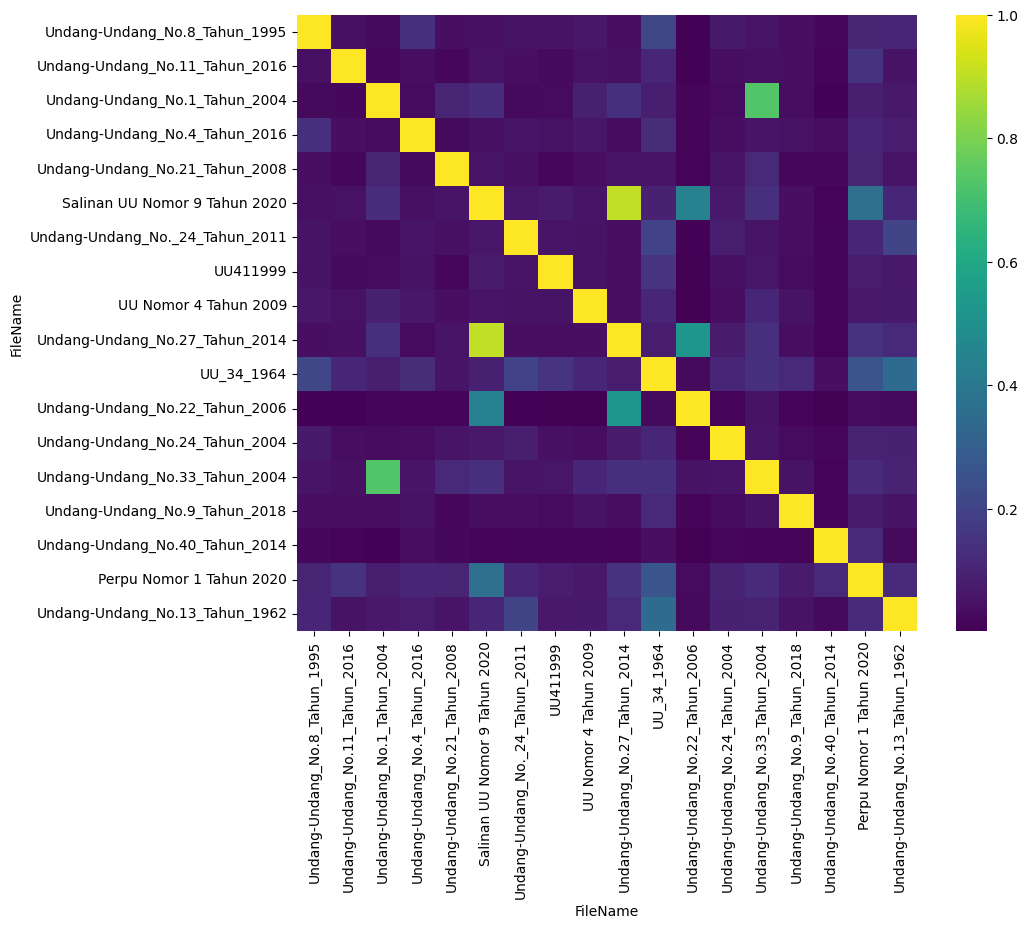

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                        Undang-Undang_No.8_Tahun_1995  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                         Selaras   
Undang-Undang_No.11_Tahun_2016                  Tidak Selaras   
Undang-Undang_No.1_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                          Netral   
Undang-Undang_No.21_Tahun_2008                  Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                   Tidak Selaras   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                  Tidak Selaras   
UU_34_1964                                             Netral   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                               Netral   
Undang-Undang_No.13_Tahun_1962                         Netral   

FileName                        Undang-Undang_No.11_Tahun_2016  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                    Tidak Selaras   
Undang-Undang_No.11_Tahun_2016                         Selaras   
Undang-Undang_No.1_Tahun_2004                    Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                    Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                   Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                    Tidak Selaras   
Undang-Undang_No._24_Tahun_2011                  Tidak Selaras   
UU411999                                         Tidak Selaras   
UU Nomor 4 Tahun 2009                            Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                   Tidak Selaras   
UU_34_1964                                              Netral   
Undang-Undang_No.22_Tahun_2006                   Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                    Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                   Tidak Selaras   
Perpu Nomor 1 Tahun 2020                                Netral   
Undang-Undang_No.13_Tahun_1962                   Tidak Selaras   

FileName                        Undang-Undang_No.1_Tahun_2004  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                   Tidak Selaras   
Undang-Undang_No.11_Tahun_2016                  Tidak Selaras   
Undang-Undang_No.1_Tahun_2004                         Selaras   
Undang-Undang_No.4_Tahun_2016                   Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                         Netral   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                      Tidak Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                        Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                        Tidak Selaras   
Undang-Undang_No.13_Tahun_1962                  Tidak Selaras   

FileName                        Undang-Undang_No.4_Tahun_2016  \
FileName    

In [ ]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [ ]:
label_df

FileName                        Undang-Undang_No.8_Tahun_1995  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                             NaN   
Undang-Undang_No.11_Tahun_2016                  Tidak Selaras   
Undang-Undang_No.1_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                          Netral   
Undang-Undang_No.21_Tahun_2008                  Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                   Tidak Selaras   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                  Tidak Selaras   
UU_34_1964                                             Netral   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                               Netral   
Undang-Undang_No.13_Tahun_1962                         Netral   

FileName                        Undang-Undang_No.11_Tahun_2016  \
FileName                                                         
Undang-Undang_No.8_Tahun_1995                              NaN   
Undang-Undang_No.11_Tahun_2016                             NaN   
Undang-Undang_No.1_Tahun_2004                    Tidak Selaras   
Undang-Undang_No.4_Tahun_2016                    Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                   Tidak Selaras   
Salinan UU Nomor 9 Tahun 2020                    Tidak Selaras   
Undang-Undang_No._24_Tahun_2011                  Tidak Selaras   
UU411999                                         Tidak Selaras   
UU Nomor 4 Tahun 2009                            Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                   Tidak Selaras   
UU_34_1964                                              Netral   
Undang-Undang_No.22_Tahun_2006                   Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                   Tidak Selaras   
Undang-Undang_No.9_Tahun_2018                    Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                   Tidak Selaras   
Perpu Nomor 1 Tahun 2020                                Netral   
Undang-Undang_No.13_Tahun_1962                   Tidak Selaras   

FileName                        Undang-Undang_No.1_Tahun_2004  \
FileName                                                        
Undang-Undang_No.8_Tahun_1995                             NaN   
Undang-Undang_No.11_Tahun_2016                            NaN   
Undang-Undang_No.1_Tahun_2004                             NaN   
Undang-Undang_No.4_Tahun_2016                   Tidak Selaras   
Undang-Undang_No.21_Tahun_2008                         Netral   
Salinan UU Nomor 9 Tahun 2020                          Netral   
Undang-Undang_No._24_Tahun_2011                 Tidak Selaras   
UU411999                                        Tidak Selaras   
UU Nomor 4 Tahun 2009                           Tidak Selaras   
Undang-Undang_No.27_Tahun_2014                         Netral   
UU_34_1964                                      Tidak Selaras   
Undang-Undang_No.22_Tahun_2006                  Tidak Selaras   
Undang-Undang_No.24_Tahun_2004                  Tidak Selaras   
Undang-Undang_No.33_Tahun_2004                        Selaras   
Undang-Undang_No.9_Tahun_2018                   Tidak Selaras   
Undang-Undang_No.40_Tahun_2014                  Tidak Selaras   
Perpu Nomor 1 Tahun 2020                        Tidak Selaras   
Undang-Undang_No.13_Tahun_1962                  Tidak Selaras   

FileName                        Undang-Undang_No.4_Tahun_2016  \
FileName    

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          33.0
Selaras          4.0
Tidak Selaras  116.0

### UU_Perpu yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                    Perundangan2
0  Undang-Undang_No.27_Tahun_2014   Salinan UU Nomor 9 Tahun 2020
1  Undang-Undang_No.22_Tahun_2006   Salinan UU Nomor 9 Tahun 2020
2  Undang-Undang_No.22_Tahun_2006  Undang-Undang_No.27_Tahun_2014
3  Undang-Undang_No.33_Tahun_2004   Undang-Undang_No.1_Tahun_2004

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                    Perundangan2  \
0  Undang-Undang_No.27_Tahun_2014   Salinan UU Nomor 9 Tahun 2020   
1  Undang-Undang_No.22_Tahun_2006   Salinan UU Nomor 9 Tahun 2020   
2  Undang-Undang_No.22_Tahun_2006  Undang-Undang_No.27_Tahun_2014   
3  Undang-Undang_No.33_Tahun_2004   Undang-Undang_No.1_Tahun_2004   

                                              Topic1  \
0  tetap undang undang anggar dapat belanja negar...   
1  undang undang tanggung jaw aban laksana anggar...   
2  undang undang tanggung jaw aban laksana anggar...   
3  tetap undang undang imbang uang perintah pusat...   

                                              Topic2  
0  undang undang anggar dapat belanja negara angg...  
1  undang undang anggar dapat belanja negara angg...  
2  tetap undang undang anggar dapat belanja negar...  
3               tetap undang undang bendahara negara

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0               Peraturan_Pemerintah_No.99_Tahun_2013   
1              Peraturan_Pemerintah_No._45_Tahun_1995   
2               Peraturan_Pemerintah_No.25_Tahun_2020   
3               Peraturan_Pemerintah_No.53_Tahun_2018   
4                                          PP_55_2015   
5               Peraturan_Pemerintah_No.73_Tahun_1992   
6               Peraturan_Pemerintah_No.73_Tahun_2016   
7                                     PERPRES_49_2011   
8                 Peraturan_Presiden_No.44_Tahun_2008   
9                           Inpres Nomor 2 Tahun 2021   
10                          Inpres Nomor 2 Tahun 2021   
11                Peraturan_Presiden_No.44_Tahun_2008   
12                          Inpres Nomor 2 Tahun 2021   
13                       PERMEN_KEU_119PMK082016_2016   
14                       KEPMEN_KEU_511KMK062002_2002   
15                               KEPMEN_DAGRI_29_2002   
16                       KEPMEN_KEU_509KMK062002_2002   
17                               PERMEN_DAGRI_52_2012   
18                               PERMEN_DAGRI_52_2012   
19                               PERMEN_DAGRI_52_2012   
20  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
21  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
22  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
23                       PERMEN_KEU_50PMK0102019_2019   
24                KEPMEN_KOOREK_KEP45MEKON082007_2007   
25                KEPMEN_KOOREK_KEP45MEKON082007_2007   
26                KEPMEN_KOOREK_KEP45MEKON082007_2007   
27                KEPMEN_KOOREK_KEP45MEKON082007_2007   
28                       KEPMGK_INVBKPM_33SK1998_1998   
29                       KEPMGK_INVBKPM_33SK1998_1998   
30                       KEPMGK_INVBKPM_38SK1999_1999   
31                       KEPMGK_INVBKPM_38SK1999_1999   
32                       KEPMGK_INVBKPM_38SK1999_1999   
33                       KEPMGK_INVBKPM_38SK1999_1999   
34                     Undang-Undang_No.27_Tahun_2014   
35                     Undang-Undang_No.22_Tahun_2006   
36                     Undang-Undang_No.22_Tahun_2006   
37                     Undang-Undang_No.33_Tahun_2004   

                              Perundangan2  \
0          Undang-Undang_No._24_Tahun_2011   
1            Undang-Undang_No.8_Tahun_1995   
2            Undang-Undang_No.4_Tahun_2016   
3          Undang-Undang_No._24_Tahun_2011   
4          Undang-Undang_No._24_Tahun_2011   
5           Undang-Undang_No.40_Tahun_2014   
6          Undang-Undang_No._24_Tahun_2011   
7    Peraturan_Pemerintah_No.75_Tahun_1992   
8    Peraturan_Pemerintah_No.73_Tahun_2016   
9    Peraturan_Pemerintah_No.99_Tahun_2013   
10   Peraturan_Pemerintah_No.73_Tahun_2016   
11         Undang-Undang_No._24_Tahun_2011   
12         Undang-Undang_No._24_Tahun_2011   
13          Undang-Undang_No.11_Tahun_2016   
14   Peraturan_Pemerintah_No.77_Tahun_1992   
15  Peraturan_Pemerintah_No.105_Tahun_2000   
16   Peraturan_Pemerintah_No.77_Tahun_1992   
17   Peraturan_Pemerintah_No.63_Tahun_2019   
18    Peraturan_Pemerintah_No.1_Tahun_2008   
19    Peraturan_Pemerintah_No.8_Tahun_2007   
20   Peraturan_Pemerintah_No.63_Tahun_2019   
21    Peraturan_Pemerintah_No.1_Tahun_2008   
22    Peraturan_Pemerintah_No.8_Tahun_2007   
23   Peraturan_Pemerintah_No.63_Tahun_2019   
24             Perpres Nomor 31 Tahun 2021   
25    Keputusan_Presiden_No.117_Tahun_1999   
26     Keputusan_Presiden_No.28_Tahun_2010   
27                          Inpres_11_2011   
28    Keputusan_Presiden_No.121_Tahun_1999   
29    Keputusan_Presiden_No.117_Tahun_1999   
30                          Keppres0541993   
31    Keputusan_Presiden_No.121_Tahun_1999   
32     Keputusan_Presiden_No.37_Tahun_1970   
33    Keputusan_Presiden_No.117_Tahun_1999   
34           Salinan UU Nomor 9 Tahun 2020   
35           Salinan UU Nomor 9 Tahun 2020   
36          Undang-Undang_No.27_Tahun_2014   
37           Undang-Undang_No.1_Tahun_2004   

                      

## Peraturan Pemerintah

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Pemerintah"')
selected_df.tail()

Tingkatan                                FileName  \
28  Peraturan Pemerintah                              PP_27_1985   
29  Peraturan Pemerintah   Peraturan_Pemerintah_No.54_Tahun_1993   
30  Peraturan Pemerintah   Peraturan_Pemerintah_No.33_Tahun_1993   
31  Peraturan Pemerintah  Peraturan_Pemerintah_No.105_Tahun_2000   
32  Peraturan Pemerintah   Peraturan_Pemerintah_No.40_Tahun_2000   

                                        ExtractedText  \
28  Menetapkan\nPERATURAN PEMERINTAH REPUBLIK INDO...   
29  «...\n
Menetapkan :\n\n \n\nPRESIDEN\nREPUBLIK...   
30  :\n\nMenetapkan : PERATURAN PEMERINTAH REPUBLI...   
31  Menetapkan :\nPERATURAN PEMERINTAH TENTANG PEN...   
32  :\n\nMenetapkan:\n\nPERATURAN PEMERINTAH TENTA...   

                                         cleaned_text  \
28  [perintah perintah republik indonesia, menteri...   
29  [atur perintah republik indonesia tambah serta...   
30  [tetap atur perintah republik indonesia tambah...   
31  [tetap atur perintah kelola pertanggungjawaban...   
32  [atur perintah tambah serta modal negara repub...   

                                           final_text  
28  perintah perintah republik indonesia menteri m...  
29  atur perintah republik indonesia tambah serta ...  
30  tetap atur perintah republik indonesia tambah ...  
31  tetap atur perintah kelola pertanggungjawaban ...  
32  atur perintah tambah serta modal negara republ...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 400)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(33, 400)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['00 ratus' '000 00' '000 00 ratus' '000 000' '000 000 00' '10 puluh'
 '10 puluh kerja' '10 puluh persen' '12 belas' '15 belas' '20 puluh'
 '20 puluh persen' '31 desember' '50 puluh' '50 puluh persen' 'agun aset'
 'ajar formal' 'ajar formal nonformal' 'akuntansi uang' 'alokasi anggar'
 'alokasi anggar perintah' 'anggar dapat' 'anggar dapat belanja'
 'anggar dasar' 'anggar perintah' 'anggar tahun' 'anggota direksi'
 'aset bpjs' 'aset bpjs ketenagakerjaan' 'aset dana' 'aset dana jamin'
 'asuransi jiwa' 'asuransi usaha' 'atur atur' 'atur atur menteri'
 'atur laksana' 'atur menteri' 'atur perintah' 'atur perintah atur'
 'atur perintah laku' 'atur perintah nomor' 'atur perintah tempat'
 'atur undang' 'atur undang undang' 'ayat atur' 'ayat atur atur'
 'ayat ayat' 'ayat huruf' 'ayat laksana' 'ayat menteri' 'ayat tetap'
 'ayat tetap menteri' 'badan hukum' 'badan investasi'
 'badan investasi perintah' 'badan kelola' 'badan periksa'
 'badan periksa uang' 'badan selenggara' 'badan 

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

00 ratus    000 00  \
FileName                                                                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019               0.000000  0.012159   
Peraturan_Pemerintah_No.1_Tahun_2008                0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019               0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...  0.000000  0.000000   
2021pp049                                           0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996               0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011              0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992               0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995              0.173028  0.317596   
Peraturan_Pemerintah_No.25_Tahun_2020               0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008               0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983               0.000000  0.000000   
Peraturan_Pemerintah_No.30_Tahun_1982               0.000000  0.000000   
Peraturan_Pemerintah_No.53_Tahun_2018               0.000000  0.000000   
PP_55_2015                                          0.000000  0.000000   
Peraturan_Pemerintah_No.49_Tahun_2017               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1984               0.000000  0.000000   
Peraturan_Pemerintah_No.107_Tahun_2015              0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_2013               0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_1992               0.000000  0.000000   
2022pp031                                           0.000000  0.000000   
PP Nomor 93 Tahun 2021                              0.000000  0.000000   
Peraturan_Pemerintah_No.73_Tahun_2016               0.000000  0.000000   
PP_27_1985                                          0.000000  0.000000   
Peraturan_Pemerintah_No.54_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.33_Tahun_1993               0.000000  0.000000   
Peraturan_Pemerintah_No.105_Tahun_2000              0.000000  0.000000   
Peraturan_Pemerintah_No.40_Tahun_2000               0.000000  0.000000   

                                                    000 00 ratus   000 000  \
FileName                                                                     
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...      0.000000  0.000000   
Peraturan_Pemerintah_No.63_Tahun_2019                   0.000000  0.031040   
Peraturan_Pemerintah_No.1_Tahun_2008                    0.000000  0.000000   
Peraturan_Pemerintah_No.8_Tahun_2007                    0.000000  0.000000   
Peraturan_Pemerintah_No.24_Tahun_2019                   0.000000  0.000000   
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...      0.000000  0.000000   
2021pp049                                               0.000000  0.000000   
Peraturan_Pemerintah_No.28_Tahun_1996                   0.000000  0.000000   
Peraturan_Pemerintah_No._49_Tahun_2011                  0.000000  0.000000   
Peraturan_Pemerintah_No.75_Tahun_1992                   0.000000  0.000000   
Peraturan_Pemerintah_No.99_Tahun_2013                   0.000000  0.000000   
Peraturan_Pemerintah_No.5_Tahun_2018                    0.000000  0.000000   
Peraturan_Pemerintah_No.77_Tahun_1992                   0.000000  0.000000   
Peraturan_Pemerintah_No._45_Tahun_1995                  0.173028  0.263336   
Peraturan_Pemerintah_No.25_Tahun_2020                   0.000000  0.000000   
Peraturan_Pemerintah_No.48_Tahun_2008                   0.000000  0.000000   
Peraturan_Pemerintah_No.18_Tahun_1983                   0

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [ ]:
cosine_similarity_df

FileName                                            PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                              
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                           1.000000                 
Peraturan_Pemerintah_No.63_Tahun_2019                                                        0.064446                 
Peraturan_Pemerintah_No.1_Tahun_2008                                                         0.072495                 
Peraturan_Pemerintah_No.8_Tahun_2007                                                         0.103693                 
Peraturan_Pemerintah_No.24_Tahun_2019                                                        0.032335                 
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                           0.406110                 
2021pp049                                                                                    0.103025                 
Peraturan_Pemerintah_No.28_Tahun_1996                                                        0.054868                 
Peraturan_Pemerintah_No._49_Tahun_2011                                                       0.131123                 
Peraturan_Pemerintah_No.75_Tahun_1992                                                        0.123463                 
Peraturan_Pemerintah_No.99_Tahun_2013                                                        0.026352                 
Peraturan_Pemerintah_No.5_Tahun_2018                                                         0.013918                 
Peraturan_Pemerintah_No.77_Tahun_1992                                                        0.038709                 
Peraturan_Pemerintah_No._45_Tahun_1995                                                       0.021644                 
Peraturan_Pemerintah_No.25_Tahun_2020                                                        0.031442                 
Peraturan_Pemerintah_No.48_Tahun_2008                                                        0.021021                 
Peraturan_Pemerintah_No.18_Tahun_1983                                                        0.203622                 
Peraturan_Pemerintah_No.30_Tahun_1982                                                        0.219847                 
Peraturan_Pemerintah_No.53_Tahun_2018                                                        0.031149                 
PP_55_2015                                                                                   0.035373                 
Peraturan_Pemerintah_No.49_Tahun_2017                                                        0.009556                 
Peraturan_Pemerintah_No.28_Tahun_1984                                                        0.294072                 
Peraturan_Pemerintah_No.107_Tahun_2015                                                       0.049786                 
Peraturan_Pemerintah_No.33_Tahun_2013                                                        0.013729                 
Peraturan_Pemerintah_No.73_Tahun_1992                                                        0.068810                 
2022pp031                                                                                    0.073287                 
PP Nomor 93 Tahun 2021                                                                       0.055719                 
Peraturan_Pemerintah_No.73_Tahun_2016                                                        0.019966                 
PP_27_1985                                                                                   0.200910                 
Peraturan_Pemerintah_No.54_Tahun_1993                                                        0.131757                 
Peraturan_Pemerintah_No.33_Tahun_1993                                                        0.138215                 
Peraturan_Pemerintah_No.105_Tahun_2000                                   

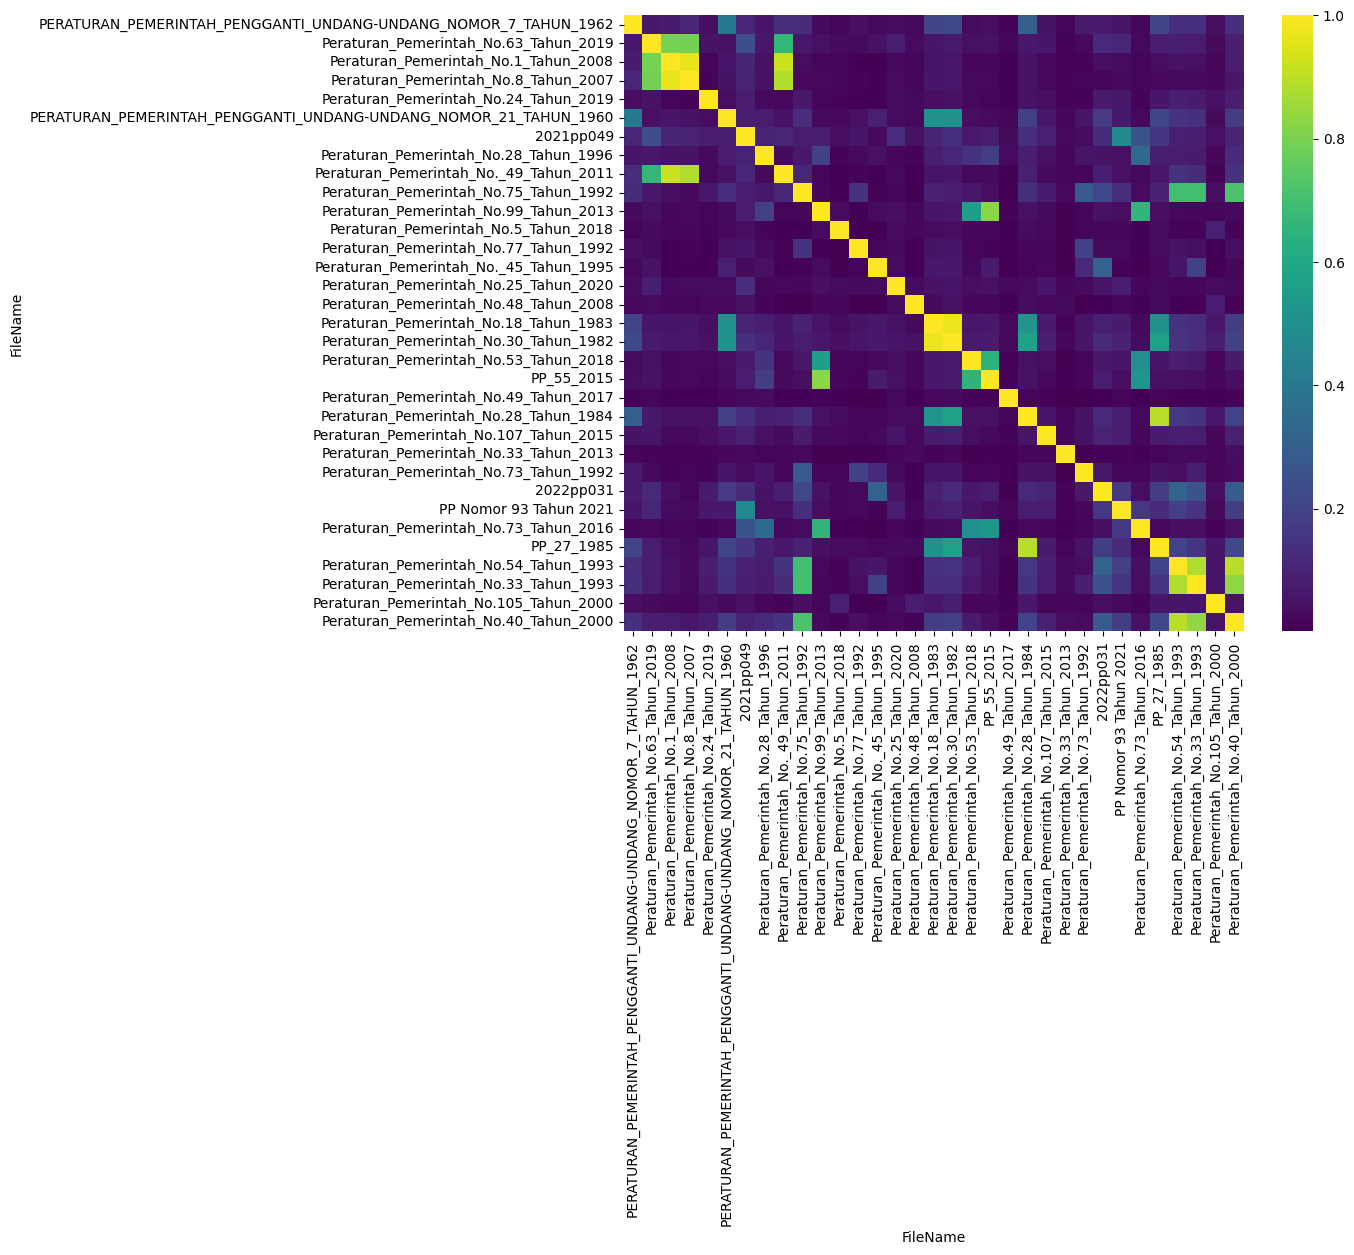

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                            Selaras                
Peraturan_Pemerintah_No.63_Tahun_2019                                                   Tidak Selaras                
Peraturan_Pemerintah_No.1_Tahun_2008                                                    Tidak Selaras                
Peraturan_Pemerintah_No.8_Tahun_2007                                                           Netral                
Peraturan_Pemerintah_No.24_Tahun_2019                                                   Tidak Selaras                
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                            Selaras                
2021pp049                                                                                      Netral                
Peraturan_Pemerintah_No.28_Tahun_1996                                                   Tidak Selaras                
Peraturan_Pemerintah_No._49_Tahun_2011                                                         Netral                
Peraturan_Pemerintah_No.75_Tahun_1992                                                          Netral                
Peraturan_Pemerintah_No.99_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.5_Tahun_2018                                                    Tidak Selaras                
Peraturan_Pemerintah_No.77_Tahun_1992                                                   Tidak Selaras                
Peraturan_Pemerintah_No._45_Tahun_1995                                                  Tidak Selaras                
Peraturan_Pemerintah_No.25_Tahun_2020                                                   Tidak Selaras                
Peraturan_Pemerintah_No.48_Tahun_2008                                                   Tidak Selaras                
Peraturan_Pemerintah_No.18_Tahun_1983                                                          Netral                
Peraturan_Pemerintah_No.30_Tahun_1982                                                          Netral                
Peraturan_Pemerintah_No.53_Tahun_2018                                                   Tidak Selaras                
PP_55_2015                                                                              Tidak Selaras                
Peraturan_Pemerintah_No.49_Tahun_2017                                                   Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1984                                                          Netral                
Peraturan_Pemerintah_No.107_Tahun_2015                                                  Tidak Selaras                
Peraturan_Pemerintah_No.33_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_1992                                                   Tidak Selaras                
2022pp031                                                                               Tidak Selaras                
PP Nomor 93 Tahun 2021                                                                  Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_2016                                                   Tidak Selaras                
PP_27_1985                                                                                     Netral                
Peraturan_Pemerintah_No.54_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.33_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.105_Tahun_2000                                                  Tidak Selaras     

In [ ]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [ ]:
label_df

FileName                                           PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NOMOR_7_TAHUN_1962  \
FileName                                                                                                             
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                                NaN                
Peraturan_Pemerintah_No.63_Tahun_2019                                                   Tidak Selaras                
Peraturan_Pemerintah_No.1_Tahun_2008                                                    Tidak Selaras                
Peraturan_Pemerintah_No.8_Tahun_2007                                                           Netral                
Peraturan_Pemerintah_No.24_Tahun_2019                                                   Tidak Selaras                
PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_NO...                                            Selaras                
2021pp049                                                                                      Netral                
Peraturan_Pemerintah_No.28_Tahun_1996                                                   Tidak Selaras                
Peraturan_Pemerintah_No._49_Tahun_2011                                                         Netral                
Peraturan_Pemerintah_No.75_Tahun_1992                                                          Netral                
Peraturan_Pemerintah_No.99_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.5_Tahun_2018                                                    Tidak Selaras                
Peraturan_Pemerintah_No.77_Tahun_1992                                                   Tidak Selaras                
Peraturan_Pemerintah_No._45_Tahun_1995                                                  Tidak Selaras                
Peraturan_Pemerintah_No.25_Tahun_2020                                                   Tidak Selaras                
Peraturan_Pemerintah_No.48_Tahun_2008                                                   Tidak Selaras                
Peraturan_Pemerintah_No.18_Tahun_1983                                                          Netral                
Peraturan_Pemerintah_No.30_Tahun_1982                                                          Netral                
Peraturan_Pemerintah_No.53_Tahun_2018                                                   Tidak Selaras                
PP_55_2015                                                                              Tidak Selaras                
Peraturan_Pemerintah_No.49_Tahun_2017                                                   Tidak Selaras                
Peraturan_Pemerintah_No.28_Tahun_1984                                                          Netral                
Peraturan_Pemerintah_No.107_Tahun_2015                                                  Tidak Selaras                
Peraturan_Pemerintah_No.33_Tahun_2013                                                   Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_1992                                                   Tidak Selaras                
2022pp031                                                                               Tidak Selaras                
PP Nomor 93 Tahun 2021                                                                  Tidak Selaras                
Peraturan_Pemerintah_No.73_Tahun_2016                                                   Tidak Selaras                
PP_27_1985                                                                                     Netral                
Peraturan_Pemerintah_No.54_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.33_Tahun_1993                                                          Netral                
Peraturan_Pemerintah_No.105_Tahun_2000                                                  Tidak Selaras     

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral          73.0
Selaras         28.0
Tidak Selaras  427.0

### Peraturan Pemerintah yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0                Peraturan_Pemerintah_No.1_Tahun_2008   
1                Peraturan_Pemerintah_No.8_Tahun_2007   
2                Peraturan_Pemerintah_No.8_Tahun_2007   
3   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
4              Peraturan_Pemerintah_No._49_Tahun_2011   
5              Peraturan_Pemerintah_No._49_Tahun_2011   
6              Peraturan_Pemerintah_No._49_Tahun_2011   
7               Peraturan_Pemerintah_No.18_Tahun_1983   
8               Peraturan_Pemerintah_No.30_Tahun_1982   
9               Peraturan_Pemerintah_No.30_Tahun_1982   
10              Peraturan_Pemerintah_No.53_Tahun_2018   
11                                         PP_55_2015   
12                                         PP_55_2015   
13              Peraturan_Pemerintah_No.28_Tahun_1984   
14              Peraturan_Pemerintah_No.28_Tahun_1984   
15                             PP Nomor 93 Tahun 2021   
16              Peraturan_Pemerintah_No.73_Tahun_2016   
17              Peraturan_Pemerintah_No.73_Tahun_2016   
18              Peraturan_Pemerintah_No.73_Tahun_2016   
19                                         PP_27_1985   
20                                         PP_27_1985   
21                                         PP_27_1985   
22              Peraturan_Pemerintah_No.54_Tahun_1993   
23              Peraturan_Pemerintah_No.33_Tahun_1993   
24              Peraturan_Pemerintah_No.33_Tahun_1993   
25              Peraturan_Pemerintah_No.40_Tahun_2000   
26              Peraturan_Pemerintah_No.40_Tahun_2000   
27              Peraturan_Pemerintah_No.40_Tahun_2000   

                                         Perundangan2  
0               Peraturan_Pemerintah_No.63_Tahun_2019  
1               Peraturan_Pemerintah_No.63_Tahun_2019  
2                Peraturan_Pemerintah_No.1_Tahun_2008  
3   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...  
4               Peraturan_Pemerintah_No.63_Tahun_2019  
5                Peraturan_Pemerintah_No.1_Tahun_2008  
6                Peraturan_Pemerintah_No.8_Tahun_2007  
7   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...  
8   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...  
9               Peraturan_Pemerintah_No.18_Tahun_1983  
10              Peraturan_Pemerintah_No.99_Tahun_2013  
11              Peraturan_Pemerintah_No.99_Tahun_2013  
12              Peraturan_Pemerintah_No.53_Tahun_2018  
13              Peraturan_Pemerintah_No.18_Tahun_1983  
14              Peraturan_Pemerintah_No.30_Tahun_1982  
15                                          2021pp049  
16              Peraturan_Pemerintah_No.99_Tahun_2013  
17              Peraturan_Pemerintah_No.53_Tahun_2018  
18                                         PP_55_2015  
19              Peraturan_Pemerintah_No.18_Tahun_1983  
20              Peraturan_Pemerintah_No.30_Tahun_1982  
21              Peraturan_Pemerintah_No.28_Tahun_1984  
22              Peraturan_Pemerintah_No.75_Tahun_1992  
23              Peraturan_Pemerintah_No.75_Tahun_1992  
24              Peraturan_Pemerintah_No.54_Tahun_1993  
25              Peraturan_Pemerintah_No.75_Tahun_1992  
26              Peraturan_Pemerintah_No.54_Tahun_1993  
27              Peraturan_Pemerintah_No.33_Tahun_1993

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1  \
0                Peraturan_Pemerintah_No.1_Tahun_2008   
1                Peraturan_Pemerintah_No.8_Tahun_2007   
2                Peraturan_Pemerintah_No.8_Tahun_2007   
3   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
4              Peraturan_Pemerintah_No._49_Tahun_2011   
5              Peraturan_Pemerintah_No._49_Tahun_2011   
6              Peraturan_Pemerintah_No._49_Tahun_2011   
7               Peraturan_Pemerintah_No.18_Tahun_1983   
8               Peraturan_Pemerintah_No.30_Tahun_1982   
9               Peraturan_Pemerintah_No.30_Tahun_1982   
10              Peraturan_Pemerintah_No.53_Tahun_2018   
11                                         PP_55_2015   
12                                         PP_55_2015   
13              Peraturan_Pemerintah_No.28_Tahun_1984   
14              Peraturan_Pemerintah_No.28_Tahun_1984   
15                             PP Nomor 93 Tahun 2021   
16              Peraturan_Pemerintah_No.73_Tahun_2016   
17              Peraturan_Pemerintah_No.73_Tahun_2016   
18              Peraturan_Pemerintah_No.73_Tahun_2016   
19                                         PP_27_1985   
20                                         PP_27_1985   
21                                         PP_27_1985   
22              Peraturan_Pemerintah_No.54_Tahun_1993   
23              Peraturan_Pemerintah_No.33_Tahun_1993   
24              Peraturan_Pemerintah_No.33_Tahun_1993   
25              Peraturan_Pemerintah_No.40_Tahun_2000   
26              Peraturan_Pemerintah_No.40_Tahun_2000   
27              Peraturan_Pemerintah_No.40_Tahun_2000   

                                         Perundangan2  \
0               Peraturan_Pemerintah_No.63_Tahun_2019   
1               Peraturan_Pemerintah_No.63_Tahun_2019   
2                Peraturan_Pemerintah_No.1_Tahun_2008   
3   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
4               Peraturan_Pemerintah_No.63_Tahun_2019   
5                Peraturan_Pemerintah_No.1_Tahun_2008   
6                Peraturan_Pemerintah_No.8_Tahun_2007   
7   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
8   PERATURAN_PEMERINTAH_PENGGANTI_UNDANG-UNDANG_N...   
9               Peraturan_Pemerintah_No.18_Tahun_1983   
10              Peraturan_Pemerintah_No.99_Tahun_2013   
11              Peraturan_Pemerintah_No.99_Tahun_2013   
12              Peraturan_Pemerintah_No.53_Tahun_2018   
13              Peraturan_Pemerintah_No.18_Tahun_1983   
14              Peraturan_Pemerintah_No.30_Tahun_1982   
15                                          2021pp049   
16              Peraturan_Pemerintah_No.99_Tahun_2013   
17              Peraturan_Pemerintah_No.53_Tahun_2018   
18                                         PP_55_2015   
19              Peraturan_Pemerintah_No.18_Tahun_1983   
20              Peraturan_Pemerintah_No.30_Tahun_1982   
21              Peraturan_Pemerintah_No.28_Tahun_1984   
22              Peraturan_Pemerintah_No.75_Tahun_1992   
23              Peraturan_Pemerintah_No.75_Tahun_1992   
24              Peraturan_Pemerintah_No.54_Tahun_1993   
25              Peraturan_Pemerintah_No.75_Tahun_1992   
26              Peraturan_Pemerintah_No.54_Tahun_1993   
27              Peraturan_Pemerintah_No.33_Tahun_1993   

                                               Topic1  \
0                    atur perintah investasi perintah   
1              tetap atur perintah investasi perintah   
2              tetap atur perintah investasi perintah   
3   atur perintah ganti undang undang bank bangun ...   
4   atur perintah ubah atur perintah nomor 1 2008 ...   
5   atur perintah ubah atur perintah nomor 1 2008 ...   
6   atur perintah ubah atur perintah nomor 1 2008 ...   
7                             atur perintah usaha eru   
8        apkan uran perintah alih bentuk usaha negara   
9        apkan uran perintah alih bentuk usaha negara   
10  atur perintah ubah atur perintah nomor 87 2013...   
11  atur perintah ubah atur perintah nomor 99 201

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
..                                     ...   
61   Peraturan_Pemerintah_No.33_Tahun_1993   
62   Peraturan_Pemerintah_No.33_Tahun_1993   
63   Peraturan_Pemerintah_No.40_Tahun_2000   
64   Peraturan_Pemerintah_No.40_Tahun_2000   
65   Peraturan_Pemerintah_No.40_Tahun_2000   

                             Perundangan2  \
0         Undang-Undang_No._24_Tahun_2011   
1           Undang-Undang_No.8_Tahun_1995   
2           Undang-Undang_No.4_Tahun_2016   
3         Undang-Undang_No._24_Tahun_2011   
4         Undang-Undang_No._24_Tahun_2011   
..                                    ...   
61  Peraturan_Pemerintah_No.75_Tahun_1992   
62  Peraturan_Pemerintah_No.54_Tahun_1993   
63  Peraturan_Pemerintah_No.75_Tahun_1992   
64  Peraturan_Pemerintah_No.54_Tahun_1993   
65  Peraturan_Pemerintah_No.33_Tahun_1993   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
..                                                ...   
61  tetap atur perintah republik indonesia tambah ...   
62  tetap atur perintah republik indonesia tambah ...   
63  atur perintah tambah serta modal negara republ...   
64  atur perintah tambah serta modal negara republ...   
65  atur perintah tambah serta modal negara republ...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
..                                                ...  
61  tetap atur perintah republik indonesia serta m...  
62  atur perintah republik indonesia tambah serta ...  
63  tetap atur perintah republik indonesia serta m...  
64  atur perintah republik indonesia tambah serta ...  
65  tetap atur perintah republik indonesia tambah ...  

[66 rows x 4 columns]

## Peraturan Presiden

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Presiden"')
selected_df.tail()

Tingkatan                             FileName  \
60  Peraturan Presiden  Keputusan_Presiden_No.28_Tahun_2010   
61  Peraturan Presiden                       Inpres_11_2011   
62  Peraturan Presiden               Inpres No 6 Tahun 2014   
63  Peraturan Presiden            Inpres Nomor 2 Tahun 2021   
64  Peraturan Presiden            INPRES Nomor 6 Tahun 2016   

                                        ExtractedText  \
60  :\n\nMenetapkan:\n\nKEPUTUSAN PRESIDEN TENTANG...   
61  PRESIDEN REPUBLIK INDONESIA\nNOMOR 11 TAHUN 20...   
62  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 6 TAHUN 2...   
63  PRESIDEN REPUBLIK INDONESIA\n\nNOMOR 2 TAHUN 2...   
64  PRESIDEN REPUBLIK INDONESIA\nNOMOR 6 TAHUN 201...   

                                         cleaned_text  \
60  [20 21 22, menteri koordinator bidang politik ...   
61  [laksana komitmen cetak biru masyarakat ekonom...   
62  [nomor 6 2014, tingkat daya saing nasional ran...   
63  [nomor 2 2021, optimalisasi laksana program ja...   
64  [cepat kembang industri farmasi alat sehat, wu...   

                                           final_text  
60  20 21 22 menteri koordinator bidang politik hu...  
61  laksana komitmen cetak biru masyarakat ekonomi...  
62  nomor 6 2014 tingkat daya saing nasional rangk...  
63  nomor 2 2021 optimalisasi laksana program jami...  
64  cepat kembang industri farmasi alat sehat wuju...

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 400)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(32, 400)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['administrasi menteri' 'ahli bidang' 'ahli bidang ekonomi'
 'ahli bidang hubung' 'ahli bidang hukum' 'ahli bidang kembang'
 'aksi mitigasi' 'aksi mitigasi ubah' 'aktif program'
 'aktif program jamin' 'alam jasa' 'alat sehat' 'ambil langkah'
 'ambil langkah langkah' 'ampun pajak' 'analisis evaluasi'
 'analisis evaluasi lapor' 'anggar dapat' 'anggar dapat belanja'
 'anggota djsn' 'aparatur negara' 'atur menteri' 'atur undang'
 'atur undang undang' 'awas laksana' 'ayat atur' 'ayat ayat' 'ayat huruf'
 'badan koordinasi' 'badan koordinasi tanam' 'badan selenggara'
 'badan usaha' 'badan usaha milik' 'bangun manusia'
 'bangun manusia budaya' 'bangun nasional' 'bangun sejahtera'
 'bangun sejahtera provinsi' 'baseline emisi' 'baseline emisi grk'
 'beban anggar' 'belanja negara' 'beri dukung' 'beri dukung administrasi'
 'bidang bangun' 'bidang bangun manusia' 'bidang ekonomi' 'bidang hubung'
 'bidang hubung lembaga' 'bidang hukum' 'bidang infrastruktur'
 'bidang investasi' 'bidan

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

administrasi menteri  ahli bidang  \
FileName                                                                  
Peraturan_Presiden_No.23_Tahun_2017               0.000000     0.000000   
PERPRES_49_2011                                   0.000000     0.000000   
Peraturan_Presiden_No._27_Tahun_2009              0.000000     0.000000   
Perpres Nomor 31 Tahun 2021                       0.000000     0.000000   
Peraturan_Presiden_No.71_Tahun_2019               0.000000     0.049383   
Perpres Nomor 98 Tahun 2021                       0.000000     0.000000   
PERPRES_41_2015                                   0.000000     0.016108   
Salinan Perpres Nomor 71 Tahun 2019               0.000000     0.049343   
Peraturan_Presiden_No.44_Tahun_2008               0.000000     0.049897   
Peraturan_Presiden_No.9_Tahun_2011                0.000000     0.000000   
Peraturan_Presiden_No.46_Tahun_2019               0.000000     0.000000   
Peraturan_Presiden_No.55_Tahun_2020               0.000000     0.000000   
Peraturan_Presiden_No.10_Tahun_1964               0.000000     0.000000   
Perpres Nomor 63 Tahun 2021                       0.000000     0.249476   
Keputusan_Presiden_No.101_Tahun_1998              0.041573     0.000000   
Keputusan_Presiden_No.108_Tahun_2001              0.053583     0.327799   
kp1831998                                         0.000000     0.000000   
Keppres2951965                                    0.000000     0.000000   
Keppres0541993                                    0.000000     0.000000   
Keputusan_Presiden_No.121_Tahun_1999              0.000000     0.000000   
Keputusan_Presiden_No.176_Tahun_2000              0.000000     0.324112   
Keputusan_Presiden_No.37_Tahun_1970               0.000000     0.000000   
Keputusan_Presiden_No.32_Tahun_2016               0.000000     0.000000   
Keppres Nomor 20 Tahun 2020                       0.000000     0.000000   
Keputusan_Presiden_No.12_Tahun_2006               0.000000     0.000000   
Keppres Nomor 11 Tahun 2021                       0.000000     0.000000   
Keputusan_Presiden_No.117_Tahun_1999              0.000000     0.000000   
Keputusan_Presiden_No.28_Tahun_2010               0.000000     0.000000   
Inpres_11_2011                                    0.000000     0.000000   
Inpres No 6 Tahun 2014                            0.000000     0.000000   
Inpres Nomor 2 Tahun 2021                         0.000000     0.000000   
INPRES Nomor 6 Tahun 2016                         0.000000     0.000000   

                                      ahli bidang ekonomi  ahli bidang hubung  \
FileName                                                                        
Peraturan_Presiden_No.23_Tahun_2017              0.000000            0.000000   
PERPRES_49_2011                                  0.000000            0.000000   
Peraturan_Presiden_No._27_Tahun_2009             0.000000            0.000000   
Perpres Nomor 31 Tahun 2021                      0.000000            0.000000   
Peraturan_Presiden_No.71_Tahun_2019              0.013815            0.000000   
Perpres Nomor 98 Tahun 2021                      0.000000            0.000000   
PERPRES_41_2015                                  0.000000            0.000000   
Salinan Perpres Nomor 71 Tahun 2019              0.013804            0.000000   
Peraturan_Presiden_No.44_Tahun_2008              0.000000            0.000000   
Peraturan_Presiden_No.9_Tahun_2011               0.000000            0.000000   
Peraturan_Presiden_No.46_Tahun_2019              0.000000            0.000000   
Peraturan_Presiden_No.55_Tahun_2020              0.000000            0.000000   
Peraturan_Presiden_No.10_Tahun_1964              0.000000            0.000000   
Perpres Nomor 63 Tahun 2021                      0.055834            0.070142   
Keputusan_Presiden_No.101_Tahun_1998             0.000000            0.000000   
Keputusan_Presiden_No.108_Tahun_2001             0.034122            0.075017   
kp1831998                    

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [ ]:
cosine_similarity_df

FileName                              Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                    
Peraturan_Presiden_No.23_Tahun_2017                              1.000000   
PERPRES_49_2011                                                  0.199434   
Peraturan_Presiden_No._27_Tahun_2009                             0.007273   
Perpres Nomor 31 Tahun 2021                                      0.017739   
Peraturan_Presiden_No.71_Tahun_2019                              0.000000   
Perpres Nomor 98 Tahun 2021                                      0.000000   
PERPRES_41_2015                                                  0.000000   
Salinan Perpres Nomor 71 Tahun 2019                              0.000000   
Peraturan_Presiden_No.44_Tahun_2008                              0.000000   
Peraturan_Presiden_No.9_Tahun_2011                               0.000000   
Peraturan_Presiden_No.46_Tahun_2019                              0.313529   
Peraturan_Presiden_No.55_Tahun_2020                              0.003232   
Peraturan_Presiden_No.10_Tahun_1964                              0.000000   
Perpres Nomor 63 Tahun 2021                                      0.000000   
Keputusan_Presiden_No.101_Tahun_1998                             0.000000   
Keputusan_Presiden_No.108_Tahun_2001                             0.000000   
kp1831998                                                        0.000000   
Keppres2951965                                                   0.000000   
Keppres0541993                                                   0.019262   
Keputusan_Presiden_No.121_Tahun_1999                             0.000000   
Keputusan_Presiden_No.176_Tahun_2000                             0.000000   
Keputusan_Presiden_No.37_Tahun_1970                              0.000000   
Keputusan_Presiden_No.32_Tahun_2016                              0.006867   
Keppres Nomor 20 Tahun 2020                                      0.000000   
Keputusan_Presiden_No.12_Tahun_2006                              0.121891   
Keppres Nomor 11 Tahun 2021                                      0.022793   
Keputusan_Presiden_No.117_Tahun_1999                             0.015423   
Keputusan_Presiden_No.28_Tahun_2010                              0.028980   
Inpres_11_2011                                                   0.000000   
Inpres No 6 Tahun 2014                                           0.009719   
Inpres Nomor 2 Tahun 2021                                        0.001045   
INPRES Nomor 6 Tahun 2016                                        0.000000   

FileName                              PERPRES_49_2011  \
FileName                                                
Peraturan_Presiden_No.23_Tahun_2017          0.199434   
PERPRES_49_2011                              1.000000   
Peraturan_Presiden_No._27_Tahun_2009         0.312118   
Perpres Nomor 31 Tahun 2021                  0.203106   
Peraturan_Presiden_No.71_Tahun_2019          0.002683   
Perpres Nomor 98 Tahun 2021                  0.000000   
PERPRES_41_2015                              0.000000   
Salinan Perpres Nomor 71 Tahun 2019          0.002681   
Peraturan_Presiden_No.44_Tahun_2008          0.000000   
Peraturan_Presiden_No.9_Tahun_2011           0.000000   
Peraturan_Presiden_No.46_Tahun_2019          0.000000   
Peraturan_Presiden_No.55_Tahun_2020          0.009272   
Peraturan_Presiden_No.10_Tahun_1964          0.000000   
Perpres Nomor 63 Tahun 2021                  0.086745   
Keputusan_Presiden_No.101_Tahun_1998         0.000000   
Keputusan_Presiden_No.108_Tahun_2001         0.000000   
kp1831998                                    0.018948   
Keppres2951965                               0.000000   
Keppres0541993                               0.468477   
Keputusan_Presiden_No.121_Tahun_1999         0.326639   
Keputusan_Presiden_No.176_Tahun_2000         0.000000   
Keputusan_Presiden_No.37_Tahun_1970          0.346309   
Keputusan_Pre

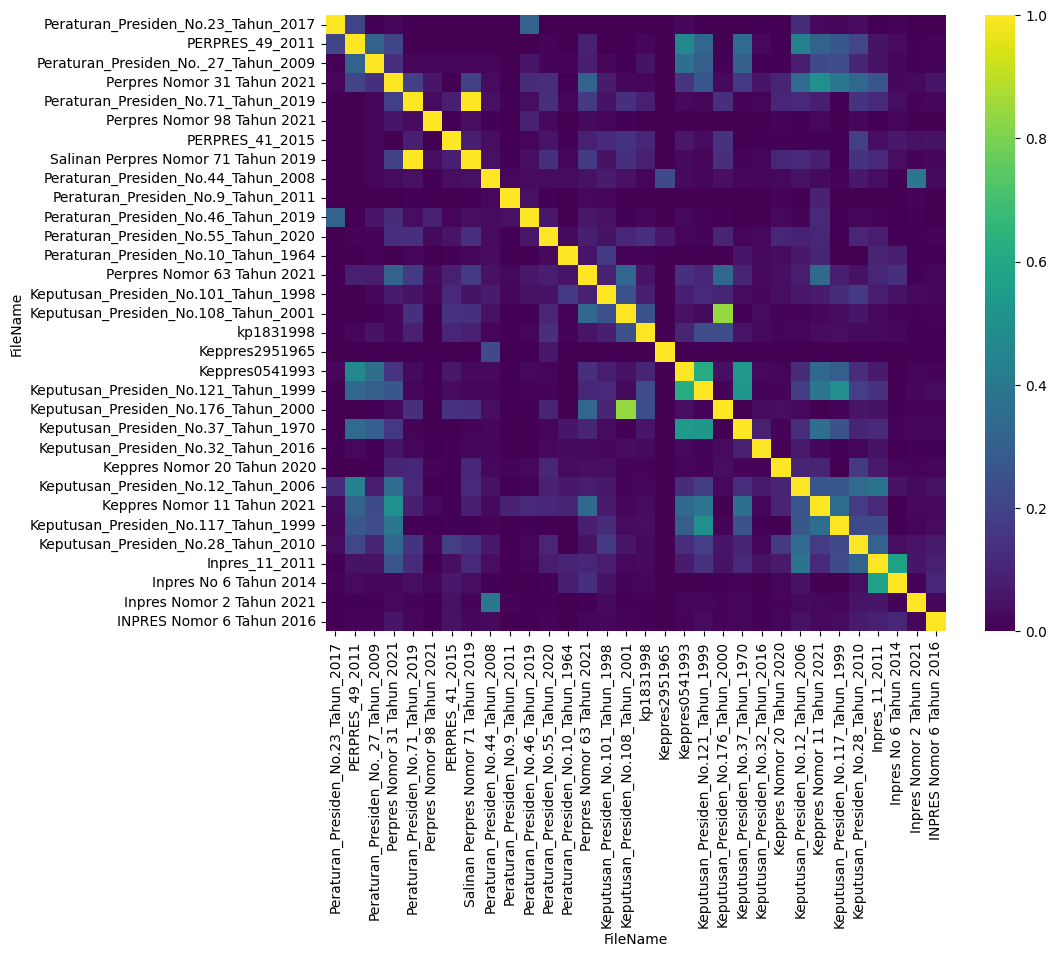

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                             Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                   
Peraturan_Presiden_No.23_Tahun_2017                              Selaras   
PERPRES_49_2011                                                   Netral   
Peraturan_Presiden_No._27_Tahun_2009                       Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                        Tidak Selaras   
Perpres Nomor 98 Tahun 2021                                Tidak Selaras   
PERPRES_41_2015                                            Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                        Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                        Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                         Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019                               Netral   
Peraturan_Presiden_No.55_Tahun_2020                        Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                        Tidak Selaras   
Perpres Nomor 63 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                       Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                       Tidak Selaras   
kp1831998                                                  Tidak Selaras   
Keppres2951965                                             Tidak Selaras   
Keppres0541993                                             Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                       Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                        Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                        Tidak Selaras   
Keppres Nomor 20 Tahun 2020                                Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                               Netral   
Keppres Nomor 11 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                        Tidak Selaras   
Inpres_11_2011                                             Tidak Selaras   
Inpres No 6 Tahun 2014                                     Tidak Selaras   
Inpres Nomor 2 Tahun 2021                                  Tidak Selaras   
INPRES Nomor 6 Tahun 2016                                  Tidak Selaras   

FileName                             PERPRES_49_2011  \
FileName                                               
Peraturan_Presiden_No.23_Tahun_2017           Netral   
PERPRES_49_2011                              Selaras   
Peraturan_Presiden_No._27_Tahun_2009          Netral   
Perpres Nomor 31 Tahun 2021                   Netral   
Peraturan_Presiden_No.71_Tahun_2019    Tidak Selaras   
Perpres Nomor 98 Tahun 2021            Tidak Selaras   
PERPRES_41_2015                        Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019    Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008    Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011     Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019    Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020    Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964    Tidak Selaras   
Perpres Nomor 63 Tahun 2021            Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998   Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001   Tidak Selaras   
kp1831998                              Tidak Selaras   
Keppres2951965                         Tidak Selaras   
Keppres0541993                               Selaras   
Keputusan_Presiden_No.121_Tahun_1999          Netral   
Keputusan_Presiden_No.176_Tahun_2000   Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970           Netral   
Keputusan_Presiden_No.32_Tahun_2016    Tidak Selaras   
Keppres Nomor 2

In [ ]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [ ]:
label_df

FileName                             Peraturan_Presiden_No.23_Tahun_2017  \
FileName                                                                   
Peraturan_Presiden_No.23_Tahun_2017                                  NaN   
PERPRES_49_2011                                                   Netral   
Peraturan_Presiden_No._27_Tahun_2009                       Tidak Selaras   
Perpres Nomor 31 Tahun 2021                                Tidak Selaras   
Peraturan_Presiden_No.71_Tahun_2019                        Tidak Selaras   
Perpres Nomor 98 Tahun 2021                                Tidak Selaras   
PERPRES_41_2015                                            Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019                        Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008                        Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011                         Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019                               Netral   
Peraturan_Presiden_No.55_Tahun_2020                        Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964                        Tidak Selaras   
Perpres Nomor 63 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998                       Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001                       Tidak Selaras   
kp1831998                                                  Tidak Selaras   
Keppres2951965                                             Tidak Selaras   
Keppres0541993                                             Tidak Selaras   
Keputusan_Presiden_No.121_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.176_Tahun_2000                       Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970                        Tidak Selaras   
Keputusan_Presiden_No.32_Tahun_2016                        Tidak Selaras   
Keppres Nomor 20 Tahun 2020                                Tidak Selaras   
Keputusan_Presiden_No.12_Tahun_2006                               Netral   
Keppres Nomor 11 Tahun 2021                                Tidak Selaras   
Keputusan_Presiden_No.117_Tahun_1999                       Tidak Selaras   
Keputusan_Presiden_No.28_Tahun_2010                        Tidak Selaras   
Inpres_11_2011                                             Tidak Selaras   
Inpres No 6 Tahun 2014                                     Tidak Selaras   
Inpres Nomor 2 Tahun 2021                                  Tidak Selaras   
INPRES Nomor 6 Tahun 2016                                  Tidak Selaras   

FileName                             PERPRES_49_2011  \
FileName                                               
Peraturan_Presiden_No.23_Tahun_2017              NaN   
PERPRES_49_2011                                  NaN   
Peraturan_Presiden_No._27_Tahun_2009          Netral   
Perpres Nomor 31 Tahun 2021                   Netral   
Peraturan_Presiden_No.71_Tahun_2019    Tidak Selaras   
Perpres Nomor 98 Tahun 2021            Tidak Selaras   
PERPRES_41_2015                        Tidak Selaras   
Salinan Perpres Nomor 71 Tahun 2019    Tidak Selaras   
Peraturan_Presiden_No.44_Tahun_2008    Tidak Selaras   
Peraturan_Presiden_No.9_Tahun_2011     Tidak Selaras   
Peraturan_Presiden_No.46_Tahun_2019    Tidak Selaras   
Peraturan_Presiden_No.55_Tahun_2020    Tidak Selaras   
Peraturan_Presiden_No.10_Tahun_1964    Tidak Selaras   
Perpres Nomor 63 Tahun 2021            Tidak Selaras   
Keputusan_Presiden_No.101_Tahun_1998   Tidak Selaras   
Keputusan_Presiden_No.108_Tahun_2001   Tidak Selaras   
kp1831998                              Tidak Selaras   
Keppres2951965                         Tidak Selaras   
Keppres0541993                               Selaras   
Keputusan_Presiden_No.121_Tahun_1999          Netral   
Keputusan_Presiden_No.176_Tahun_2000   Tidak Selaras   
Keputusan_Presiden_No.37_Tahun_1970           Netral   
Keputusan_Presiden_No.32_Tahun_2016    Tidak Selaras   
Keppres Nomor 2

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Total hasil
pd.DataFrame(counts['Total'])

Total
Netral         102.0
Selaras         10.0
Tidak Selaras  384.0

### Peraturan Presiden yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1                          Perundangan2
0   Salinan Perpres Nomor 71 Tahun 2019   Peraturan_Presiden_No.71_Tahun_2019
1                        Keppres0541993                       PERPRES_49_2011
2  Keputusan_Presiden_No.121_Tahun_1999                        Keppres0541993
3  Keputusan_Presiden_No.176_Tahun_2000  Keputusan_Presiden_No.108_Tahun_2001
4   Keputusan_Presiden_No.37_Tahun_1970                        Keppres0541993
5   Keputusan_Presiden_No.37_Tahun_1970  Keputusan_Presiden_No.121_Tahun_1999
6   Keputusan_Presiden_No.12_Tahun_2006                       PERPRES_49_2011
7           Keppres Nomor 11 Tahun 2021           Perpres Nomor 31 Tahun 2021
8  Keputusan_Presiden_No.117_Tahun_1999  Keputusan_Presiden_No.121_Tahun_1999
9                Inpres No 6 Tahun 2014                        Inpres_11_2011

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1                          Perundangan2  \
0   Salinan Perpres Nomor 71 Tahun 2019   Peraturan_Presiden_No.71_Tahun_2019   
1                        Keppres0541993                       PERPRES_49_2011   
2  Keputusan_Presiden_No.121_Tahun_1999                        Keppres0541993   
3  Keputusan_Presiden_No.176_Tahun_2000  Keputusan_Presiden_No.108_Tahun_2001   
4   Keputusan_Presiden_No.37_Tahun_1970                        Keppres0541993   
5   Keputusan_Presiden_No.37_Tahun_1970  Keputusan_Presiden_No.121_Tahun_1999   
6   Keputusan_Presiden_No.12_Tahun_2006                       PERPRES_49_2011   
7           Keppres Nomor 11 Tahun 2021           Perpres Nomor 31 Tahun 2021   
8  Keputusan_Presiden_No.117_Tahun_1999  Keputusan_Presiden_No.121_Tahun_1999   
9                Inpres No 6 Tahun 2014                        Inpres_11_2011   

                                              Topic1  \
0                 menteri koordinator bidang maritim   
1                            usaha tutup tanam modal   
2  laksana nilai mohon tanam modal negeri pmdn ta...   
3  menteri muda urus cepat bangun kawasan timur i...   
4  bentuk team panitia laksana tanam modal asing ...   
5  bentuk team panitia laksana tanam modal asing ...   
6  susun anggota komite arah diktum ketua menteri...   
7  rangka tingkat investasi mudah usaha bentuk sa...   
8  laksana limpah wenang ayat gubernur kepala dae...   
9                                       nomor 6 2014   

                                              Topic2  
0                 menteri koordinator bidang maritim  
1  kesah asean comprehensive investment agreement...  
2                            usaha tutup tanam modal  
3                      menteri negara daya perempuan  
4                            usaha tutup tanam modal  
5  laksana nilai mohon tanam modal negeri pmdn ta...  
6  kesah asean comprehensive investment agreement...  
7  menteri didik budaya riset teknologi menteri d...  
8  laksana nilai mohon tanam modal negeri pmdn ta...  
9  laksana komitmen cetak biru masyarakat ekonomi...

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
..                                     ...   
71     Keputusan_Presiden_No.37_Tahun_1970   
72     Keputusan_Presiden_No.12_Tahun_2006   
73             Keppres Nomor 11 Tahun 2021   
74    Keputusan_Presiden_No.117_Tahun_1999   
75                  Inpres No 6 Tahun 2014   

                            Perundangan2  \
0        Undang-Undang_No._24_Tahun_2011   
1          Undang-Undang_No.8_Tahun_1995   
2          Undang-Undang_No.4_Tahun_2016   
3        Undang-Undang_No._24_Tahun_2011   
4        Undang-Undang_No._24_Tahun_2011   
..                                   ...   
71  Keputusan_Presiden_No.121_Tahun_1999   
72                       PERPRES_49_2011   
73           Perpres Nomor 31 Tahun 2021   
74  Keputusan_Presiden_No.121_Tahun_1999   
75                        Inpres_11_2011   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
..                                                ...   
71  bentuk team panitia laksana tanam modal asing ...   
72  susun anggota komite arah diktum ketua menteri...   
73  rangka tingkat investasi mudah usaha bentuk sa...   
74  laksana limpah wenang ayat gubernur kepala dae...   
75                                       nomor 6 2014   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
..                                                ...  
71  laksana nilai mohon tanam modal negeri pmdn ta...  
72  kesah asean comprehensive investment agreement...  
73  menteri didik budaya riset teknologi menteri d...  
74  laksana nilai mohon tanam modal negeri pmdn ta...  
75  laksana komitmen cetak biru masyarakat ekonomi...  

[76 rows x 4 columns]

## Peraturan Menteri

In [ ]:
selected_df = df.query('Tingkatan == "Peraturan Menteri"')
selected_df.tail()

Tingkatan                          FileName  \
85  Peraturan Menteri  PERMEN_PERIN_64MINDPER72016_2016   
86  Peraturan Menteri      KEPMGK_INVBKPM_12SK1999_1999   
87  Peraturan Menteri      KEPMGK_INVBKPM_33SK1998_1998   
88  Peraturan Menteri      KEPMGK_INVBKPM_38SK1999_1999   
89  Peraturan Menteri       PERMEN_KEU_53PMK052020_2020   

                                        ExtractedText  \
85  :\n\nPERATURAN MENTERI PERINDUSTRIAN TENTANG B...   
86  :\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INVES...   
87  :\n\nMenetapkan:\nKEPUTUSAN MENTERI NEGARA INV...   
88  MENETAPKAN:\nKEPUTUSAN MENTERI NEGARA INVESTAS...   
89  :\n\nMenetapkan       :        PERATURAN MENTE...   

                                         cleaned_text  \
85  [atur menteri industri besar tenaga kerja nila...   
86                                                 []   
87  [tetap putus menteri negara investasi kepala b...   
88  [tetap putus menteri negara investasi kepala b...   
89                                                 []   

                                           final_text  
85  atur menteri industri besar tenaga kerja nilai...  
86                                                     
87  tetap putus menteri negara investasi kepala ba...  
88  tetap putus menteri negara investasi kepala ba...  
89

In [ ]:
# Convert the tf-idf matrix to a dense matrix
tfidf_matrix, feature_names = tfidf(selected_df['final_text'], 200)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [ ]:
# Print the tf-idf matrix and corresponding feature names
print("TF-IDF Matrix:")
print(tfidf_matrix_dense.shape)

TF-IDF Matrix:
(25, 200)


In [ ]:
print("Feature Names:")
print(feature_names)

Feature Names:
['2015 no' '2015 no 1785' '34 aval' '34 aval lalitt' 'akuntan publik'
 'akuntansi lapor' 'akuntansi lapor uang' 'anggar dapat' 'anggar satu'
 'anggar satu kerja' 'arsip dinamis' 'aset daerah' 'asisten deputi'
 'atur atur' 'atur daerah' 'atur menteri' 'atur menteri uang'
 'atur undang' 'atur undang undang' 'aval lalitt' 'aval lalitt maelii'
 'ayat cantum' 'ayat cantum lampir' 'ayat huruf' 'ba bun' 'badan layan'
 'badan usaha' 'badan usaha milik' 'bahan koordinasi'
 'bahan koordinasi telaah' 'bahan rancang' 'bahan rancang rumus'
 'belanja daerah' 'bendahara negara' 'berita negara'
 'berita negara republik' 'biaya usaha' 'biaya usaha mikro'
 'bidang kelola' 'bidang kelola lingkung' 'bidang lingkung'
 'bidang maritim' 'bidang maritim investasi' 'bijak bidang' 'bijak kelola'
 'budaya lingkung' 'buku jurnal' 'bun investasi' 'bun investasi perintah'
 'cantum lampir' 'daerah apbd' 'daerah ayat' 'dana cadang' 'dana lingkung'
 'dana pensiun' 'dapat belanja' 'direktur jenderal' 'ek

### Document-Term Matrix

In [ ]:
DTM_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
DTM_df.index = selected_df['FileName']
DTM_df

2015 no  2015 no 1785  \
FileName                                                                     
PERMEN_KEU_231PMK062017_2017                        0.000000      0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000      0.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000      0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000      0.000000   
KEPMEN_DAGRI_29_2002                                0.000000      0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000      0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000      0.000000   
KEPMNG_LH_9_2001                                    0.000000      0.000000   
PERMEN_DAGRI_52_2012                                0.000000      0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000      0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000      0.000000   
PERMEN_KEU_209PMK052015_2015                        0.361891      0.361891   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000      0.000000   
PERMEN_KOMARVES_6_2020                              0.000000      0.000000   
pmmarves001_2022                                    0.000000      0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000      0.000000   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000      0.000000   
1_PMK.05_2021                                       0.000000      0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.000000      0.000000   
pmmarves002_2021                                    0.000000      0.000000   
PERMEN_PERIN_64MINDPER72016_2016                    0.000000      0.000000   
KEPMGK_INVBKPM_12SK1999_1999                        0.000000      0.000000   
KEPMGK_INVBKPM_33SK1998_1998                        0.000000      0.000000   
KEPMGK_INVBKPM_38SK1999_1999                        0.000000      0.000000   
PERMEN_KEU_53PMK052020_2020                         0.000000      0.000000   

                                                     34 aval  34 aval lalitt  \
FileName                                                                       
PERMEN_KEU_231PMK062017_2017                        0.000000        0.000000   
KEPMEN_KEU_511KMK062002_2002                        0.000000        0.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008               0.000000        0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                 0.000000        0.000000   
KEPMEN_DAGRI_29_2002                                0.000000        0.000000   
KEPMEN_KEU_509KMK062002_2002                        0.000000        0.000000   
PERMEN_KEU_103PMK052019_2019                        0.000000        0.000000   
KEPMNG_LH_9_2001                                    0.119183        0.119183   
PERMEN_DAGRI_52_2012                                0.000000        0.000000   
PERMEN_KEU_91PMK012017_2017                         0.000000        0.000000   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...  0.000000        0.000000   
PERMEN_KEU_209PMK052015_2015                        0.000000        0.000000   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...  0.000000        0.000000   
PERMEN_KOMARVES_6_2020                              0.000000        0.000000   
pmmarves001_2022                                    0.000000        0.000000   
PERMEN_KEU_119PMK082016_2016                        0.000000        0.000000   
Keputusan Menteri_KP_45_Tahun_2015                  0.000000        0.000000   
1_PMK.05_2021                                       0.000000        0.000000   
PERMEN_KEU_50PMK0102019_2019                        0.000000        0.000000   
pmmarves002_2021                                    0.000000        0.000000   
PERMEN_PERIN_64MINDPER72016_2016                    0.000000        0.000000   
KEPMGK_INVBKPM_12SK1999_1999                        0.000000        0.000000   
KEPMGK_INVBKPM_33SK1998_19

### Calculate the similarity

In [ ]:
# Create the array of cosine similarity values
cosine_similarity_array = cosine_similarity(DTM_df)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=DTM_df.index, columns=DTM_df.index)

In [ ]:
cosine_similarity_df

FileName                                            PERMEN_KEU_231PMK062017_2017  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                            1.000000   
KEPMEN_KEU_511KMK062002_2002                                            0.012875   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                   0.000000   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                     0.038812   
KEPMEN_DAGRI_29_2002                                                    0.024014   
KEPMEN_KEU_509KMK062002_2002                                            0.153245   
PERMEN_KEU_103PMK052019_2019                                            0.193379   
KEPMNG_LH_9_2001                                                        0.004508   
PERMEN_DAGRI_52_2012                                                    0.150850   
PERMEN_KEU_91PMK012017_2017                                             0.090760   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                      0.118692   
PERMEN_KEU_209PMK052015_2015                                            0.322419   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                      0.244234   
PERMEN_KOMARVES_6_2020                                                  0.030252   
pmmarves001_2022                                                        0.007121   
PERMEN_KEU_119PMK082016_2016                                            0.021911   
Keputusan Menteri_KP_45_Tahun_2015                                      0.004294   
1_PMK.05_2021                                                           0.155065   
PERMEN_KEU_50PMK0102019_2019                                            0.296311   
pmmarves002_2021                                                        0.003924   
PERMEN_PERIN_64MINDPER72016_2016                                        0.039442   
KEPMGK_INVBKPM_12SK1999_1999                                            0.000000   
KEPMGK_INVBKPM_33SK1998_1998                                            0.004095   
KEPMGK_INVBKPM_38SK1999_1999                                            0.001928   
PERMEN_KEU_53PMK052020_2020                                             0.000000   

FileName                                            KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                           
PERMEN_KEU_231PMK062017_2017                                            0.012875   
KEPMEN_KEU_511KMK062002_2002                                            1.000000   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                                   0.031330   
KEPMEN_KOOREK_KEP45MEKON082007_2007                                     0.016797   
KEPMEN_DAGRI_29_2002                                                    0.007495   
KEPMEN_KEU_509KMK062002_2002                                            0.665933   
PERMEN_KEU_103PMK052019_2019                                            0.021423   
KEPMNG_LH_9_2001                                                        0.001912   
PERMEN_DAGRI_52_2012                                                    0.026105   
PERMEN_KEU_91PMK012017_2017                                             0.030082   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                      0.028882   
PERMEN_KEU_209PMK052015_2015                                            0.039946   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                      0.058793   
PERMEN_KOMARVES_6_2020                                                  0.015238   
pmmarves001_2022                                                        0.012140   
PERMEN_KEU_119PMK082016_2016                                            0.115842   
Keputusan Menteri_KP_45_Tahun_2015                                      0.027430   
1_PMK.05_2021                                                           0.037975   
PERMEN_KEU_50PMK0102019_2019                       

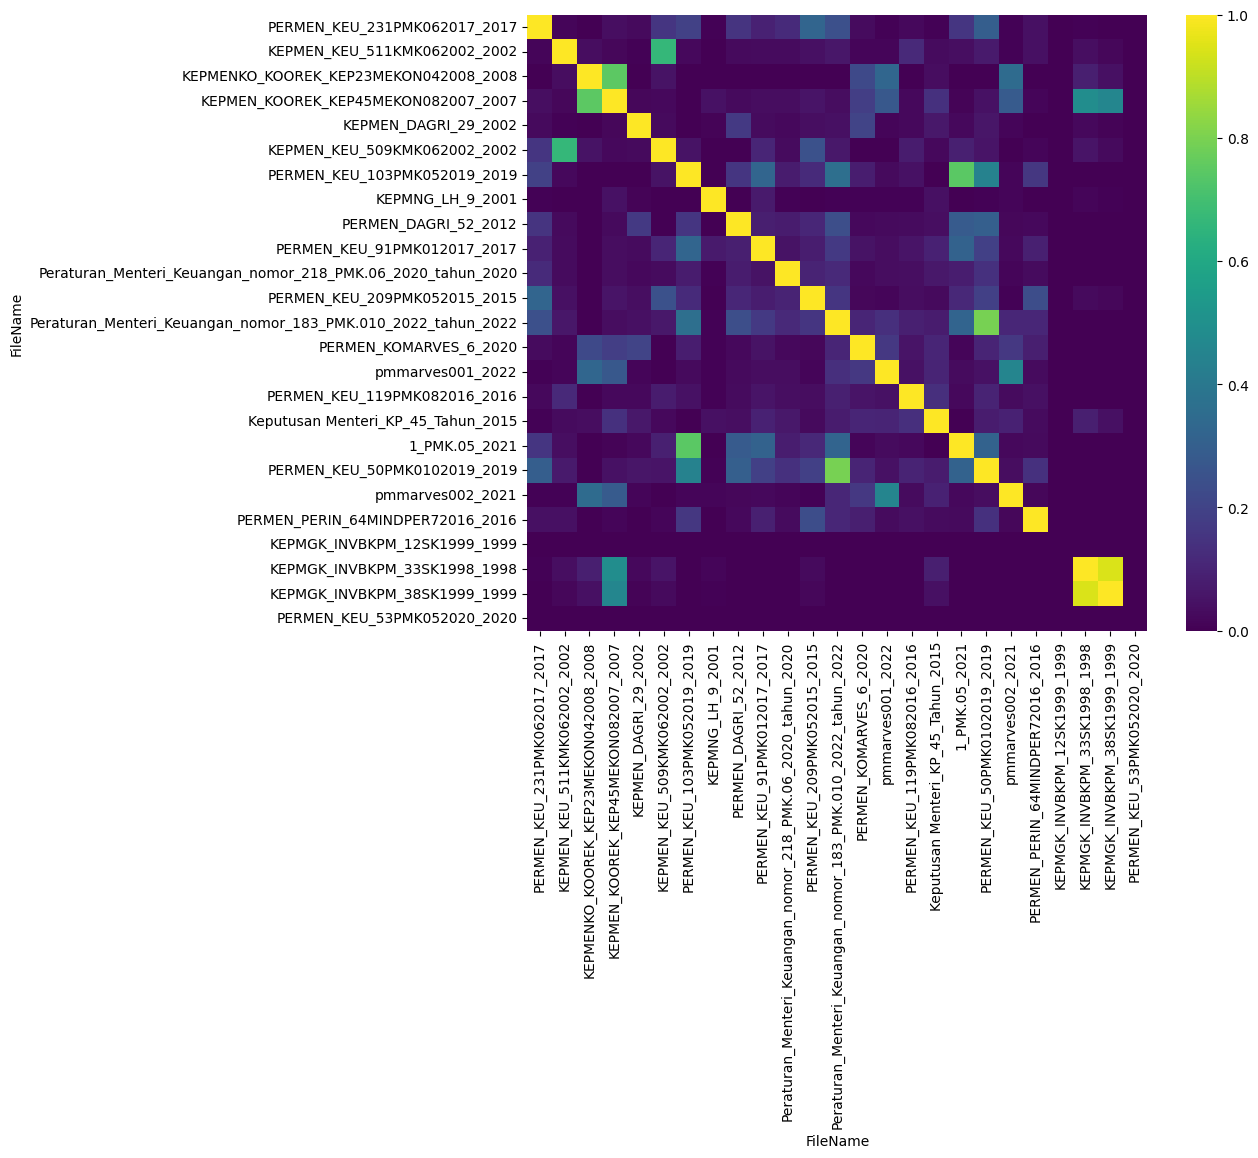

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_df, annot=False, cmap='viridis')
# Show the heatmap
plt.show()

In [ ]:
def convert_to_label(score):
  if score < 0.1:
      return 'Tidak Selaras'
  elif score < 0.4:
      return 'Netral'
  else:
      return 'Selaras'

# Apply the function element-wise to the filtered_df DataFrame
label_df = cosine_similarity_df.applymap(convert_to_label)
label_df

FileName                                           PERMEN_KEU_231PMK062017_2017  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                            Selaras   
KEPMEN_KEU_511KMK062002_2002                                      Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Netral   
PERMEN_KEU_103PMK052019_2019                                             Netral   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Netral   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Netral   
PERMEN_KEU_209PMK052015_2015                                             Netral   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       Netral   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                      Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                            Netral   
PERMEN_KEU_50PMK0102019_2019                                             Netral   
pmmarves002_2021                                                  Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                  Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                      Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                      Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                      Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                       Tidak Selaras   

FileName                                           KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                      Tidak Selaras   
KEPMEN_KEU_511KMK062002_2002                                            Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                            Selaras   
PERMEN_KEU_103PMK052019_2019                                      Tidak Selaras   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                              Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                      Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                Tidak Selaras   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Netral   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                     Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                      Tidak Selaras   
pmmarves002_202

In [ ]:
# Ubah menjadi bentuk menyerupai matriks segitiga sehingga tidak terjadi duplikat
mask = np.triu(np.ones(label_df.shape, dtype=bool), k=0)

# Set the upper triangle values to NaN
label_df.mask(mask, inplace=True)

In [ ]:
label_df

FileName                                           PERMEN_KEU_231PMK062017_2017  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                                NaN   
KEPMEN_KEU_511KMK062002_2002                                      Tidak Selaras   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                             Netral   
PERMEN_KEU_103PMK052019_2019                                             Netral   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                                     Netral   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                       Netral   
PERMEN_KEU_209PMK052015_2015                                             Netral   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                       Netral   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                      Tidak Selaras   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                            Netral   
PERMEN_KEU_50PMK0102019_2019                                             Netral   
pmmarves002_2021                                                  Tidak Selaras   
PERMEN_PERIN_64MINDPER72016_2016                                  Tidak Selaras   
KEPMGK_INVBKPM_12SK1999_1999                                      Tidak Selaras   
KEPMGK_INVBKPM_33SK1998_1998                                      Tidak Selaras   
KEPMGK_INVBKPM_38SK1999_1999                                      Tidak Selaras   
PERMEN_KEU_53PMK052020_2020                                       Tidak Selaras   

FileName                                           KEPMEN_KEU_511KMK062002_2002  \
FileName                                                                          
PERMEN_KEU_231PMK062017_2017                                                NaN   
KEPMEN_KEU_511KMK062002_2002                                                NaN   
KEPMENKO_KOOREK_KEP23MEKON042008_2008                             Tidak Selaras   
KEPMEN_KOOREK_KEP45MEKON082007_2007                               Tidak Selaras   
KEPMEN_DAGRI_29_2002                                              Tidak Selaras   
KEPMEN_KEU_509KMK062002_2002                                            Selaras   
PERMEN_KEU_103PMK052019_2019                                      Tidak Selaras   
KEPMNG_LH_9_2001                                                  Tidak Selaras   
PERMEN_DAGRI_52_2012                                              Tidak Selaras   
PERMEN_KEU_91PMK012017_2017                                       Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_218_PMK.06_202...                Tidak Selaras   
PERMEN_KEU_209PMK052015_2015                                      Tidak Selaras   
Peraturan_Menteri_Keuangan_nomor_183_PMK.010_20...                Tidak Selaras   
PERMEN_KOMARVES_6_2020                                            Tidak Selaras   
pmmarves001_2022                                                  Tidak Selaras   
PERMEN_KEU_119PMK082016_2016                                             Netral   
Keputusan Menteri_KP_45_Tahun_2015                                Tidak Selaras   
1_PMK.05_2021                                                     Tidak Selaras   
PERMEN_KEU_50PMK0102019_2019                                      Tidak Selaras   
pmmarves002_202

### Total

In [ ]:
counts = label_df.apply(pd.Series.value_counts).fillna(0)
counts.loc['Netral', 'Total'] = counts.loc['Netral'].sum()
counts.loc['Selaras', 'Total'] = counts.loc['Selaras'].sum()
counts.loc['Tidak Selaras', 'Total'] = counts.loc['Tidak Selaras'].sum()
# Sum result
pd.DataFrame(counts['Total'])

Total
Netral          49.0
Selaras          9.0
Tidak Selaras  242.0

### Peraturan Menteri yang Selaras

In [ ]:
row_indices, col_indices = np.where(label_df == 'Selaras')
row_names = label_df.index[row_indices]
col_names = label_df.columns[col_indices]
df_selaras = pd.DataFrame({'Perundangan1': row_names, 'Perundangan2': col_names})
df_selaras

Perundangan1  \
0  KEPMEN_KOOREK_KEP45MEKON082007_2007   
1         KEPMEN_KEU_509KMK062002_2002   
2                        1_PMK.05_2021   
3         PERMEN_KEU_50PMK0102019_2019   
4         PERMEN_KEU_50PMK0102019_2019   
5                     pmmarves002_2021   
6         KEPMGK_INVBKPM_33SK1998_1998   
7         KEPMGK_INVBKPM_38SK1999_1999   
8         KEPMGK_INVBKPM_38SK1999_1999   

                                        Perundangan2  
0              KEPMENKO_KOOREK_KEP23MEKON042008_2008  
1                       KEPMEN_KEU_511KMK062002_2002  
2                       PERMEN_KEU_103PMK052019_2019  
3                       PERMEN_KEU_103PMK052019_2019  
4  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...  
5                                   pmmarves001_2022  
6                KEPMEN_KOOREK_KEP45MEKON082007_2007  
7                KEPMEN_KOOREK_KEP45MEKON082007_2007  
8                       KEPMGK_INVBKPM_33SK1998_1998

In [ ]:
for i in range(len(df_selaras)):
  res = df_selaras.iloc[i,0]
  df_selaras.loc[i, 'Topic1'] = df['cleaned_text'][df.query('FileName == @res').index[0]][0]

  res2 = df_selaras.iloc[i,1]
  df_selaras.loc[i, 'Topic2'] = df['cleaned_text'][df.query('FileName == @res2').index[0]][0]

In [ ]:
df_selaras

Perundangan1  \
0  KEPMEN_KOOREK_KEP45MEKON082007_2007   
1         KEPMEN_KEU_509KMK062002_2002   
2                        1_PMK.05_2021   
3         PERMEN_KEU_50PMK0102019_2019   
4         PERMEN_KEU_50PMK0102019_2019   
5                     pmmarves002_2021   
6         KEPMGK_INVBKPM_33SK1998_1998   
7         KEPMGK_INVBKPM_38SK1999_1999   
8         KEPMGK_INVBKPM_38SK1999_1999   

                                        Perundangan2  \
0              KEPMENKO_KOOREK_KEP23MEKON042008_2008   
1                       KEPMEN_KEU_511KMK062002_2002   
2                       PERMEN_KEU_103PMK052019_2019   
3                       PERMEN_KEU_103PMK052019_2019   
4  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
5                                   pmmarves001_2022   
6                KEPMEN_KOOREK_KEP45MEKON082007_2007   
7                KEPMEN_KOOREK_KEP45MEKON082007_2007   
8                       KEPMGK_INVBKPM_33SK1998_1998   

                                              Topic1  \
0  bentuk tim kembang sistem layan informasi izin...   
1  putus menteri uang lapor uang dana pensiun men...   
2  atur menteri uang tarif layan badan layan pusa...   
3                                  atur menteri uang   
4                                  atur menteri uang   
5  tetap atur menteri koordinator bidang maritim ...   
6  tetap putus menteri negara investasi kepala ba...   
7  tetap putus menteri negara investasi kepala ba...   
8  tetap putus menteri negara investasi kepala ba...   

                                              Topic2  
0  putus menteri koordinator bidang ekonomi ketua...  
1  putus menteri uang investasi dana pensiun ment...  
2  tetap atur menteri uang standar layan minimum ...  
3  tetap atur menteri uang standar layan minimum ...  
4  tetap atur menteri uang tambah investasi perin...  
5  tetap atur menteri koordinator bidang maritim ...  
6  bentuk tim kembang sistem layan informasi izin...  
7  bentuk tim kembang sistem layan informasi izin...  
8  tetap putus menteri negara investasi kepala ba...

In [ ]:
all_selaras = pd.concat([all_selaras, df_selaras], ignore_index=True)
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
..                                     ...   
80            PERMEN_KEU_50PMK0102019_2019   
81                        pmmarves002_2021   
82            KEPMGK_INVBKPM_33SK1998_1998   
83            KEPMGK_INVBKPM_38SK1999_1999   
84            KEPMGK_INVBKPM_38SK1999_1999   

                                         Perundangan2  \
0                     Undang-Undang_No._24_Tahun_2011   
1                       Undang-Undang_No.8_Tahun_1995   
2                       Undang-Undang_No.4_Tahun_2016   
3                     Undang-Undang_No._24_Tahun_2011   
4                     Undang-Undang_No._24_Tahun_2011   
..                                                ...   
80  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
81                                   pmmarves001_2022   
82                KEPMEN_KOOREK_KEP45MEKON082007_2007   
83                KEPMEN_KOOREK_KEP45MEKON082007_2007   
84                       KEPMGK_INVBKPM_33SK1998_1998   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
..                                                ...   
80                                  atur menteri uang   
81  tetap atur menteri koordinator bidang maritim ...   
82  tetap putus menteri negara investasi kepala ba...   
83  tetap putus menteri negara investasi kepala ba...   
84  tetap putus menteri negara investasi kepala ba...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
..                                                ...  
80  tetap atur menteri uang tambah investasi perin...  
81  tetap atur menteri koordinator bidang maritim ...  
82  bentuk tim kembang sistem layan informasi izin...  
83  bentuk tim kembang sistem layan informasi izin...  
84  tetap putus menteri negara investasi kepala ba...  

[85 rows x 4 columns]

# Graph

In [ ]:
# Create a graph and add edges based on the similarities between 'Perundangan1' and 'Perundangan2'
G = nx.Graph()
for idx, row in all_selaras.iterrows():
  G.add_edge(row['Perundangan1'], row['Perundangan2'])

# Find connected components (topics) in the graph
topics = list(nx.connected_components(G))

# Convert the topics to a dictionary with keys as 'Topic1', 'Topic2', etc.
topics_dict = {f"Klaster{i+1}": list(topic) for i, topic in enumerate(topics)}

In [ ]:
topics

[{'Inpres Nomor 2 Tahun 2021',
  'PP_55_2015',
  'Peraturan_Pemerintah_No.53_Tahun_2018',
  'Peraturan_Pemerintah_No.73_Tahun_2016',
  'Peraturan_Pemerintah_No.99_Tahun_2013',
  'Peraturan_Presiden_No.44_Tahun_2008',
  'Undang-Undang_No._24_Tahun_2011'},
 {'Peraturan_Pemerintah_No._45_Tahun_1995', 'Undang-Undang_No.8_Tahun_1995'},
 {'Peraturan_Pemerintah_No.25_Tahun_2020', 'Undang-Undang_No.4_Tahun_2016'},
 {'Peraturan_Pemerintah_No.73_Tahun_1992', 'Undang-Undang_No.40_Tahun_2014'},
 {'Inpres No 6 Tahun 2014',
  'Inpres_11_2011',
  'KEPMENKO_KOOREK_KEP23MEKON042008_2008',
  'KEPMEN_KOOREK_KEP45MEKON082007_2007',
  'KEPMGK_INVBKPM_33SK1998_1998',
  'KEPMGK_INVBKPM_38SK1999_1999',
  'Keppres Nomor 11 Tahun 2021',
  'Keppres0541993',
  'Keputusan_Presiden_No.117_Tahun_1999',
  'Keputusan_Presiden_No.121_Tahun_1999',
  'Keputusan_Presiden_No.12_Tahun_2006',
  'Keputusan_Presiden_No.28_Tahun_2010',
  'Keputusan_Presiden_No.37_Tahun_1970',
  'PERPRES_49_2011',
  'Peraturan_Pemerintah_No.33_T

<ipython-input-381-93901a5dc6db>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


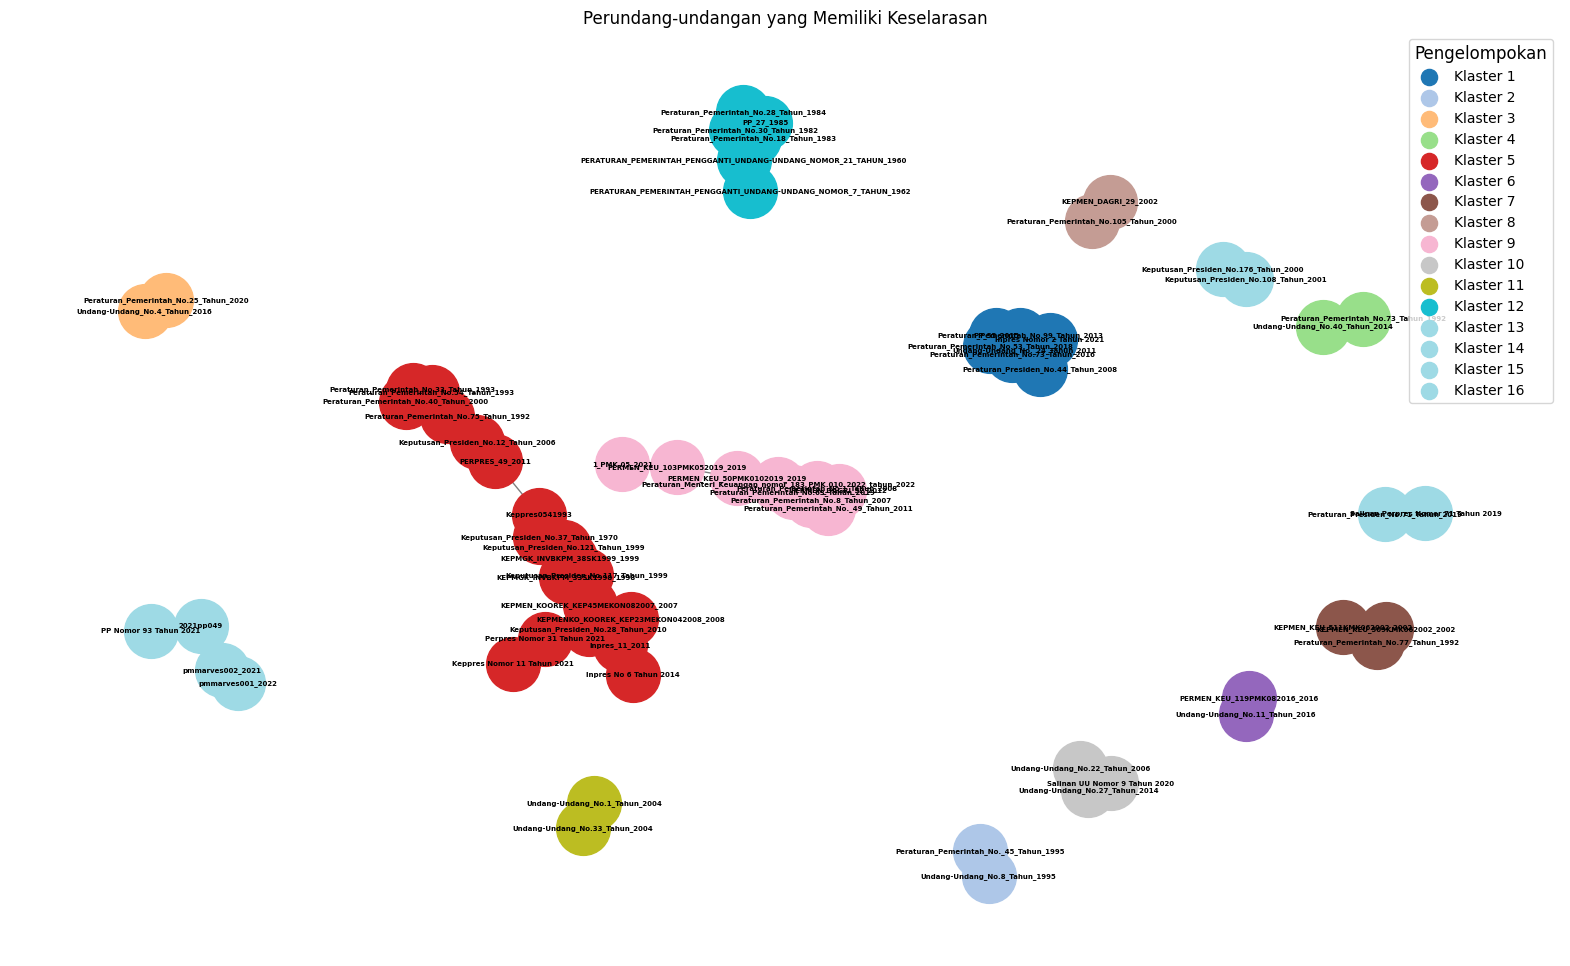

In [ ]:
# Visualize the graph
pos = nx.spring_layout(G, seed = 55)
plt.figure(figsize=(20, 12))
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)
for i, topic in enumerate(topics):
  color = colormap(i)
  nx.draw_networkx_nodes(G, pos, nodelist=topic, node_color=color, label=f"Klaster {i+1}", node_size=1500)
nx.draw_networkx_edges(G, pos, alpha=0.5)

label_pos = {node: (x, y) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=5, font_color='black', font_weight='bold')

legend = plt.legend(markerscale=0.3, fontsize=10)
legend.set_title("Pengelompokan", prop={"size": 12})
legend._legend_box.align = "left"
plt.axis('off')
plt.title("Perundang-undangan yang Memiliki Keselarasan")
plt.show()

In [ ]:
topics_dict

{'Topic1': ['Inpres Nomor 2 Tahun 2021',
  'Undang-Undang_No._24_Tahun_2011',
  'Peraturan_Pemerintah_No.53_Tahun_2018',
  'Peraturan_Pemerintah_No.73_Tahun_2016',
  'Peraturan_Presiden_No.44_Tahun_2008',
  'Peraturan_Pemerintah_No.99_Tahun_2013',
  'PP_55_2015'],
 'Topic2': ['Peraturan_Pemerintah_No._45_Tahun_1995',
  'Undang-Undang_No.8_Tahun_1995'],
 'Topic3': ['Undang-Undang_No.4_Tahun_2016',
  'Peraturan_Pemerintah_No.25_Tahun_2020'],
 'Topic4': ['Undang-Undang_No.40_Tahun_2014',
  'Peraturan_Pemerintah_No.73_Tahun_1992'],
 'Topic5': ['Perpres Nomor 31 Tahun 2021',
  'Peraturan_Pemerintah_No.54_Tahun_1993',
  'Peraturan_Pemerintah_No.75_Tahun_1992',
  'KEPMEN_KOOREK_KEP45MEKON082007_2007',
  'Keputusan_Presiden_No.37_Tahun_1970',
  'KEPMENKO_KOOREK_KEP23MEKON042008_2008',
  'Keputusan_Presiden_No.12_Tahun_2006',
  'KEPMGK_INVBKPM_33SK1998_1998',
  'Peraturan_Pemerintah_No.40_Tahun_2000',
  'Keputusan_Presiden_No.121_Tahun_1999',
  'Peraturan_Pemerintah_No.33_Tahun_1993',
  'Inpres

**Note** : Peraturan pada topic 5 tidak semuanya memiliki keselarasan antar satu sama lain. Yang artinya antar perundangan-undangan memiliki keselarasan tidak secara langsung satu sama lain. Seperti

In [ ]:
all_selaras

Perundangan1  \
0    Peraturan_Pemerintah_No.99_Tahun_2013   
1   Peraturan_Pemerintah_No._45_Tahun_1995   
2    Peraturan_Pemerintah_No.25_Tahun_2020   
3    Peraturan_Pemerintah_No.53_Tahun_2018   
4                               PP_55_2015   
..                                     ...   
80            PERMEN_KEU_50PMK0102019_2019   
81                        pmmarves002_2021   
82            KEPMGK_INVBKPM_33SK1998_1998   
83            KEPMGK_INVBKPM_38SK1999_1999   
84            KEPMGK_INVBKPM_38SK1999_1999   

                                         Perundangan2  \
0                     Undang-Undang_No._24_Tahun_2011   
1                       Undang-Undang_No.8_Tahun_1995   
2                       Undang-Undang_No.4_Tahun_2016   
3                     Undang-Undang_No._24_Tahun_2011   
4                     Undang-Undang_No._24_Tahun_2011   
..                                                ...   
80  Peraturan_Menteri_Keuangan_nomor_183_PMK.010_2...   
81                                   pmmarves001_2022   
82                KEPMEN_KOOREK_KEP45MEKON082007_2007   
83                KEPMEN_KOOREK_KEP45MEKON082007_2007   
84                       KEPMGK_INVBKPM_33SK1998_1998   

                                               Topic1  \
0                          tetap atur perintah kelola   
1   tetap atur perintah selenggara giat bidang pas...   
2        atur perintah selenggara tabung rumah rakyat   
3   atur perintah ubah atur perintah nomor 87 2013...   
4   atur perintah ubah atur perintah nomor 99 2013...   
..                                                ...   
80                                  atur menteri uang   
81  tetap atur menteri koordinator bidang maritim ...   
82  tetap putus menteri negara investasi kepala ba...   
83  tetap putus menteri negara investasi kepala ba...   
84  tetap putus menteri negara investasi kepala ba...   

                                               Topic2  
0         undang undang badan selenggara jamin sosial  
1                     tetap undang undang pasar modal  
2                   undang undang tabung rumah rakyat  
3         undang undang badan selenggara jamin sosial  
4         undang undang badan selenggara jamin sosial  
..                                                ...  
80  tetap atur menteri uang tambah investasi perin...  
81  tetap atur menteri koordinator bidang maritim ...  
82  bentuk tim kembang sistem layan informasi izin...  
83  bentuk tim kembang sistem layan informasi izin...  
84  tetap putus menteri negara investasi kepala ba...  

[85 rows x 4 columns]

<ipython-input-369-e938d53fed7a>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


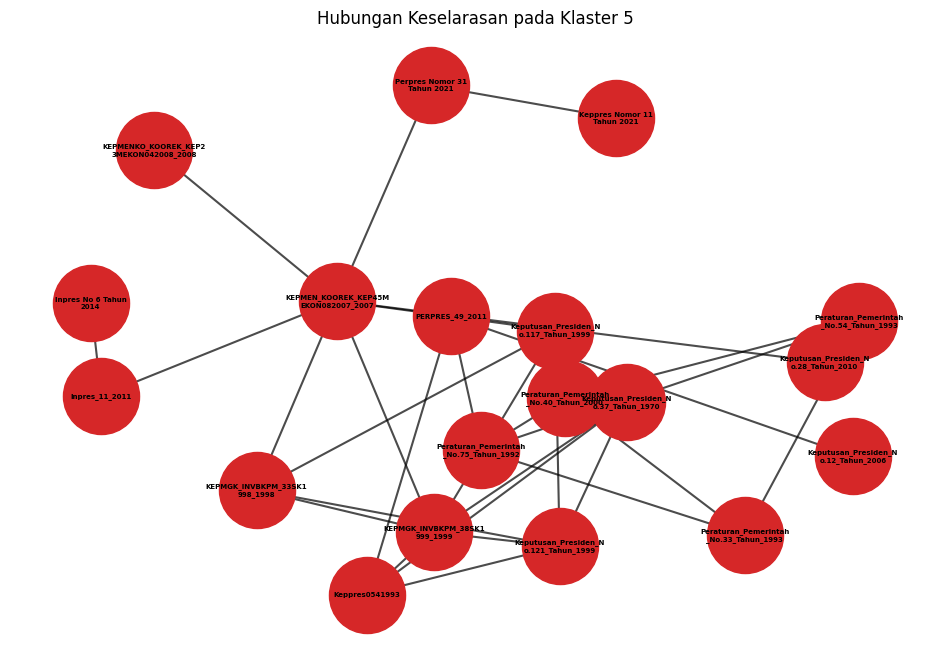

In [ ]:
# Extract nodes for Topic 5
topic5 = list(topics[4])

# Create a subgraph containing only nodes from Topic 5
G_topic5 = G.subgraph(topic5)

# Visualize the subgraph for Topic 5 with larger size and 13 different colors
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic5, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 13 colors
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(4)  # Get the color for Topic 5
nx.draw_networkx_nodes(G_topic5, pos, node_color=color, node_size=3000, label=f"Topik 5")

nx.draw_networkx_edges(G_topic5, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic5.nodes()}
nx.draw_networkx_labels(G_topic5, label_pos, labels=wrapped_labels, font_size=5, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 5")
plt.show()

<ipython-input-370-b8f227a2c24d>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


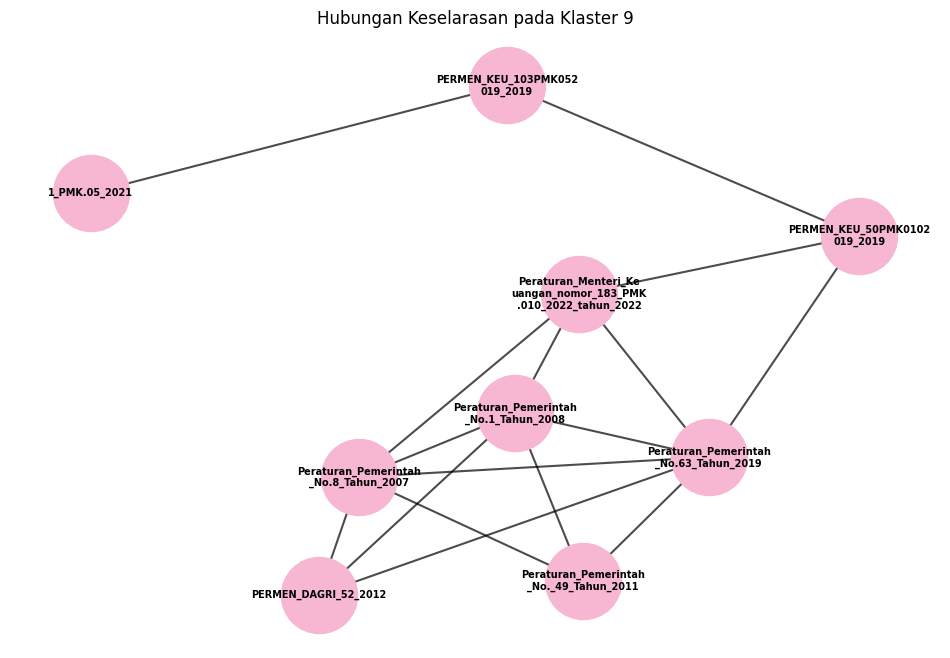

In [ ]:
# Extract nodes for Topic 9
topic9 = list(topics[8])

# Create a subgraph containing only nodes from Topic 9
G_topic9 = G.subgraph(topic9)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic9, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 13 colors
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(8)  # Get the color for Topic 9
nx.draw_networkx_nodes(G_topic9, pos, node_color=color, node_size=3000, label=f"Topic 9")

nx.draw_networkx_edges(G_topic9, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic9.nodes()}
nx.draw_networkx_labels(G_topic9, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 9")
plt.show()

<ipython-input-405-990390a403ed>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


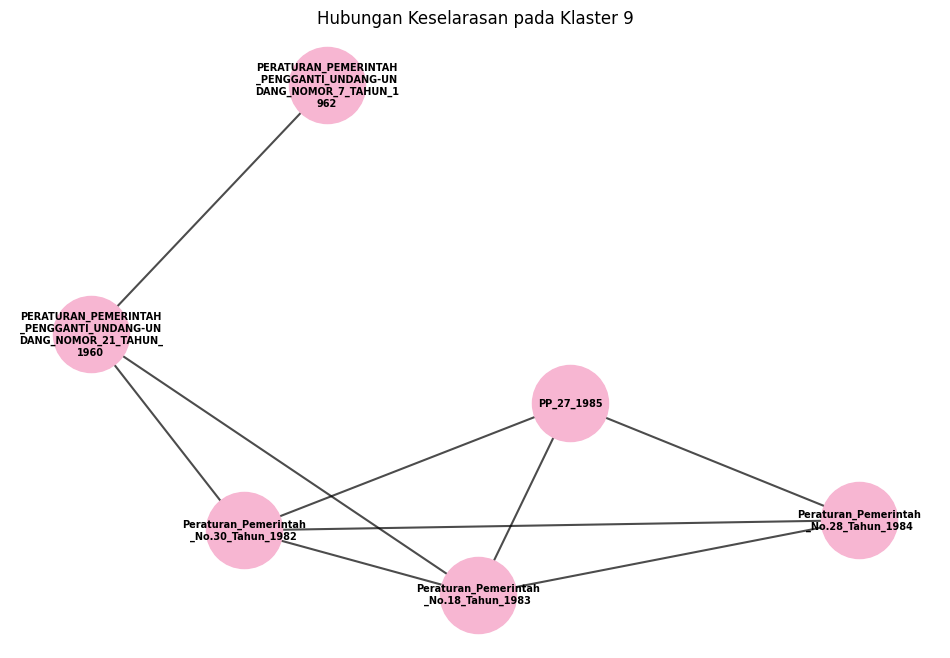

In [ ]:
# Extract nodes for Topic 9
topic9 = list(topics[11])

# Create a subgraph containing only nodes from Topic 9
G_topic9 = G.subgraph(topic9)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_topic9, seed=42, k=1.5)

# Choose a colormap with 20 distinct colors and select the first 13 colors
num_colors = 13
colormap = plt.cm.get_cmap('tab20', num_colors)

color = colormap(8)  # Get the color for Topic 9
nx.draw_networkx_nodes(G_topic9, pos, node_color=color, node_size=3000, label=f"Topic 9")

nx.draw_networkx_edges(G_topic9, pos, width=1.5, alpha=0.7)
label_pos = {node: (x, y) for node, (x, y) in pos.items()}
wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic9.nodes()}
nx.draw_networkx_labels(G_topic9, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')

plt.axis('off')
plt.title("Hubungan Keselarasan pada Klaster 9")
plt.show()

In [ ]:
filtered_nodes = [node for node, degree in topics_dict.items() if len(degree) <= 3]
filtered_nodes

['Topic2',
 'Topic3',
 'Topic4',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic10',
 'Topic11',
 'Topic13',
 'Topic14',
 'Topic15',
 'Topic16']

<ipython-input-424-3c2943271e91>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', num_colors)


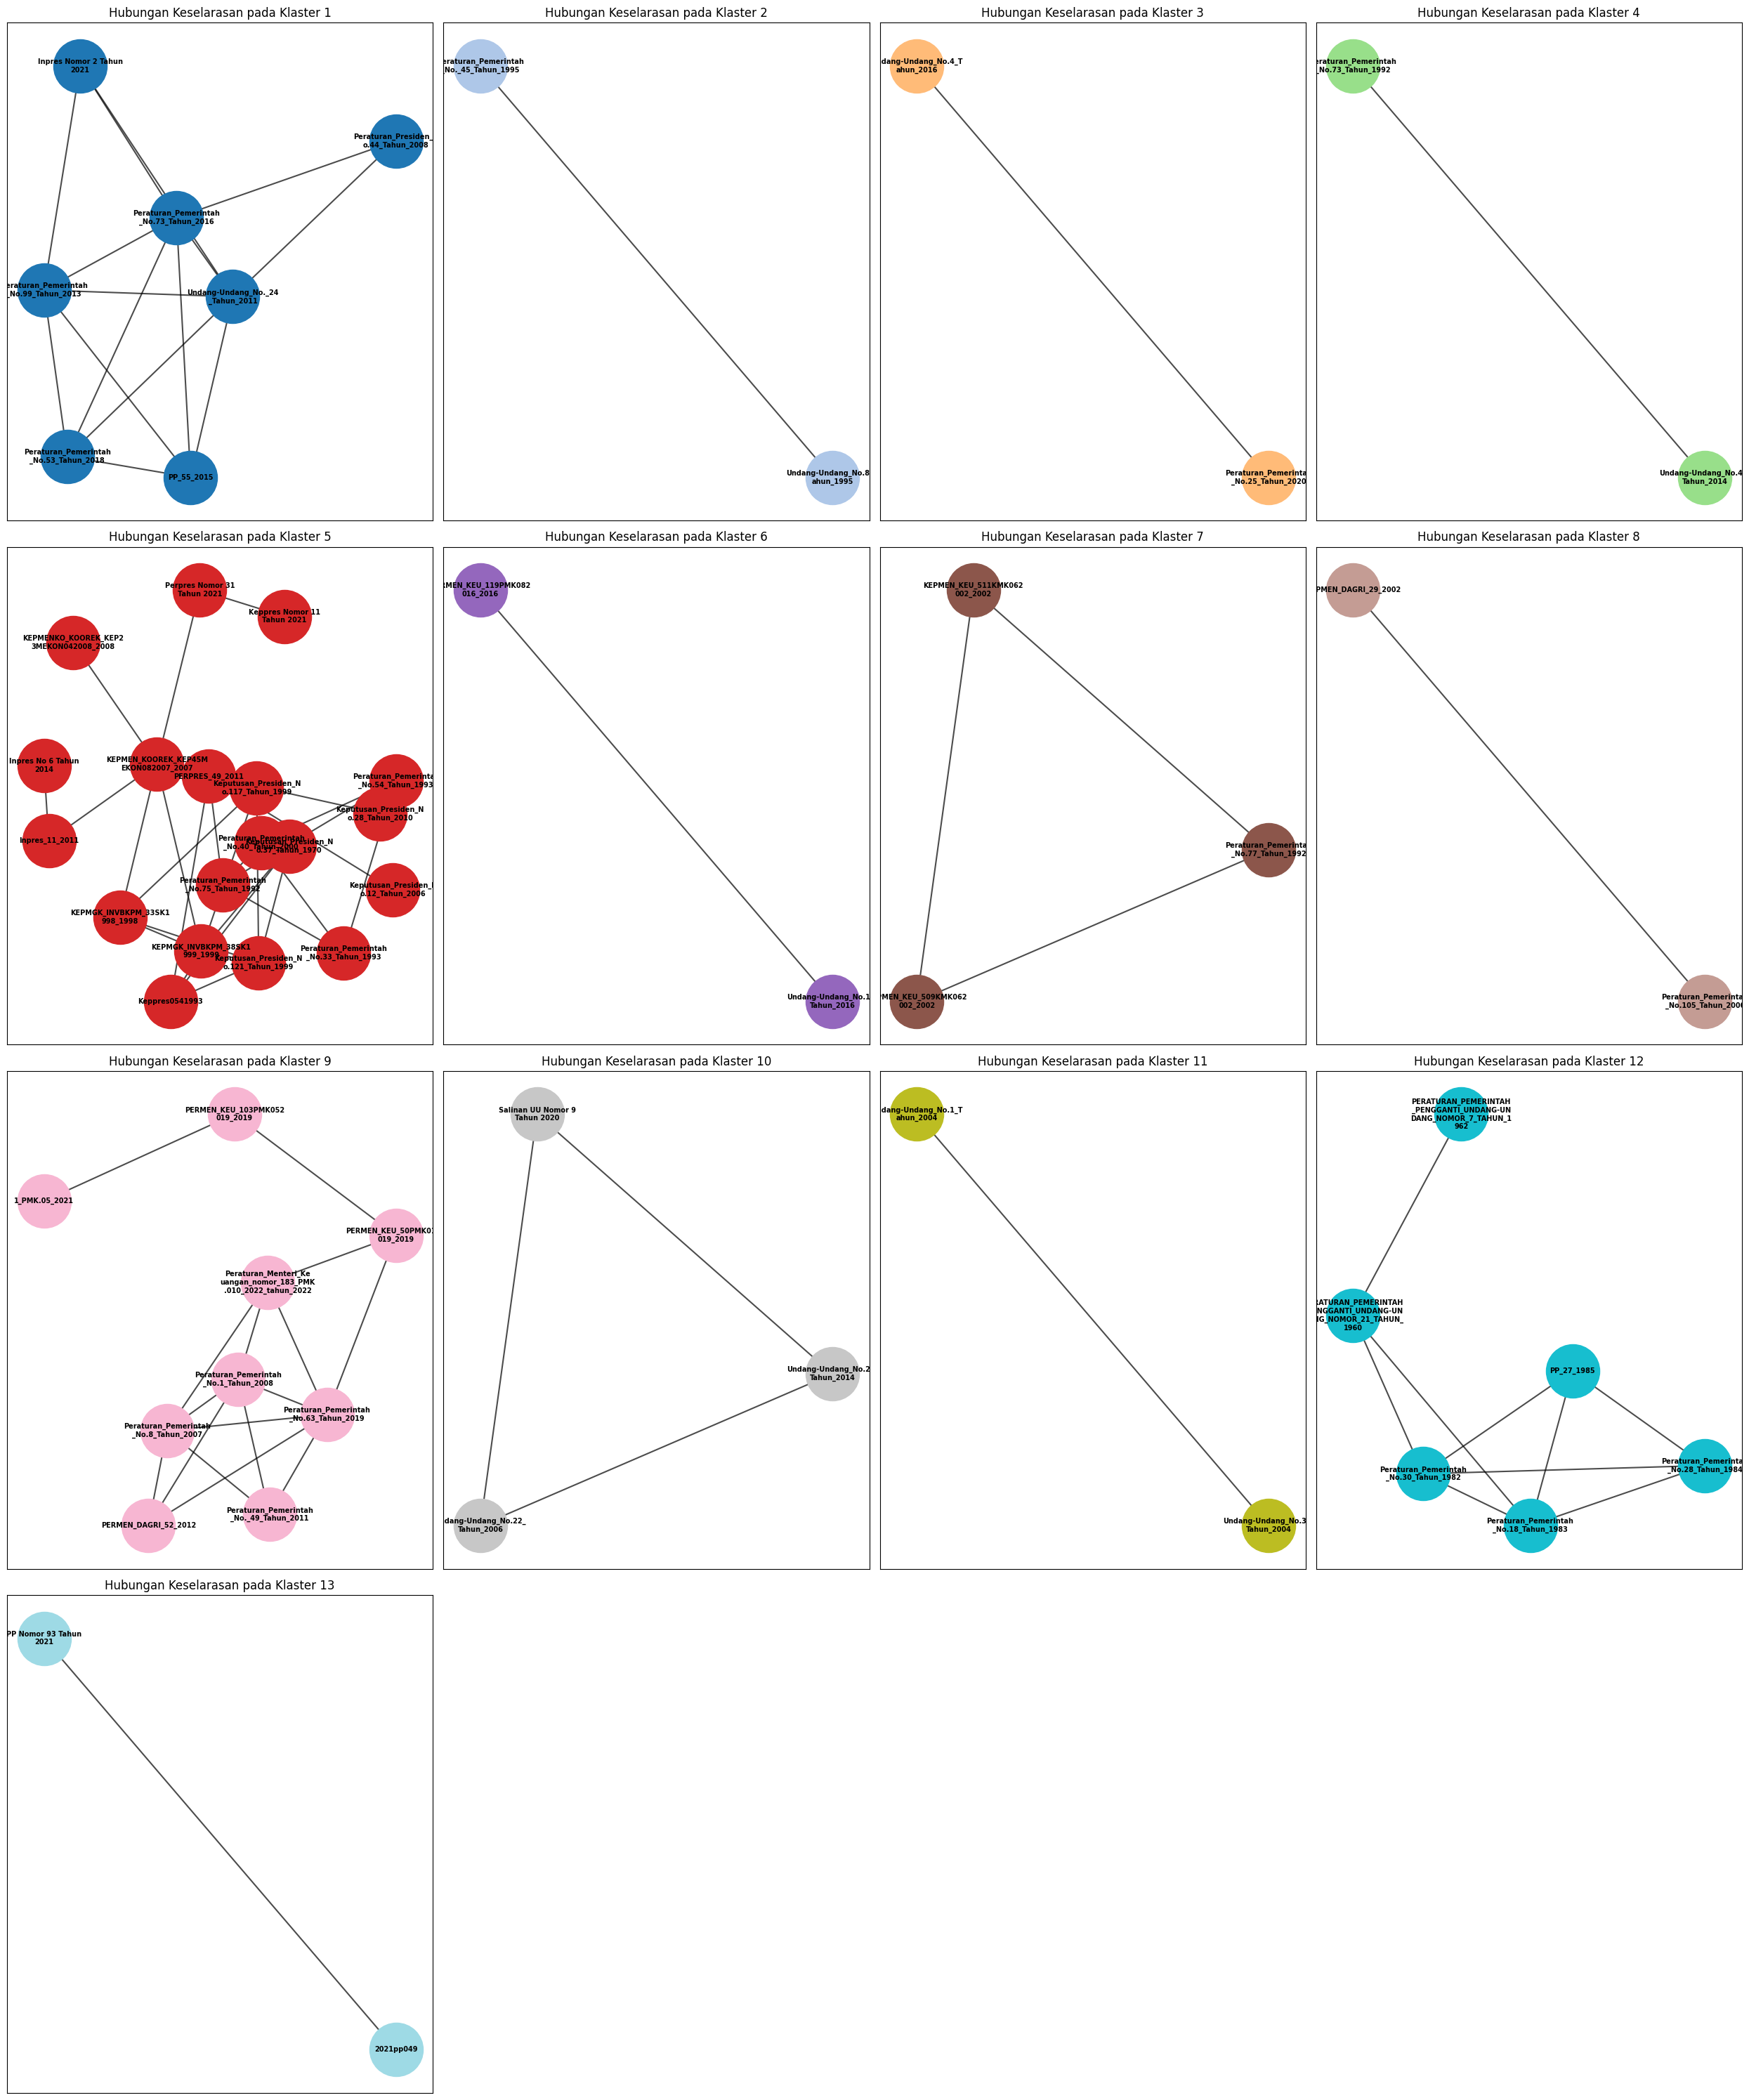

In [ ]:
def plot_subgraph(G, topics, index, subplot_index):
    # Extract nodes for Topic
    topic = list(topics[index])

    # Create a subgraph containing only nodes from the topic
    G_topic = G.subgraph(topic)

    plt.subplot(4, 4, subplot_index)  # 3 rows and 4 columns, subplot_index specifies the position
    pos = nx.spring_layout(G_topic, seed=42, k=1.5)

    # Choose a colormap with 20 distinct colors and select the color for the topic
    num_colors = 13
    colormap = plt.cm.get_cmap('tab20', num_colors)
    color = colormap(index)
    nx.draw_networkx_nodes(G_topic, pos, node_color=color, node_size=3000, label=f"Topic {index}")

    nx.draw_networkx_edges(G_topic, pos, width=1.5, alpha=0.7)
    label_pos = {node: (x, y) for node, (x, y) in pos.items()}
    wrapped_labels = {node: '\n'.join(textwrap.wrap(node, width=20)) for node in G_topic.nodes()}
    nx.draw_networkx_labels(G_topic, label_pos, labels=wrapped_labels, font_size=7, font_color='black', font_weight='bold')
    plt.title(f"Hubungan Keselarasan pada Klaster {index+1}")


# Topics list
index = [1, 2, 3, 5, 6, 7, 9,
          10, 11, 12, 13, 14, 15]

# Create subplots for each selected topic
plt.figure(figsize=(25, 30))
for k, i in enumerate(index):
    plot_subgraph(G, topics, k, k+1)

plt.tight_layout()
plt.show()
